# Longitudinal Exploratory Data Analysis

**Carlos Stefano Filho** <br>
*Data Scientist, PhD*

___
This notebook contains a longitudinal exploratory data analysis (LEDA).

The general idea is to infer relations between socioeconomical and educational budget indicators with students' performance in ENEM. We do that, however, with a time-varying approach, attempting to identify trends and overall patterns that might occur throughout several years of ENEM data.

Years analyzed in this study range from 2015 - 2022.

The general pipeline of analysis in this notebook can be extended to other years as well.

___

In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import linregress, spearmanr
from sklearn.decomposition import PCA
from preprocess import load_and_preprocess_ENEM_raw_data
from external_data_loading import get_metrics_from_inep_education_summary, get_residencial_earnings_per_capita_gini_index, get_public_safety_metrics, get_siope_data, SIOPE_METRICS_DICT

## 1. Data loading

##### General definitions

In [2]:
years_to_analyze = np.arange(2015, 2023)
# common_path = "../Datasets/enem-inep-data/"
common_path = "D:/students_performance_project/Datasets/enem-inep-data"

### 1.1. Evaluating raw data

In [6]:
registrations_and_absences = {'year': [], 'absences': [], 'registrations': []} # to store students' absences and registrations in ENEM for each year
UF_nan_values = {'year': [], 'UF_nan': []} # to store UF's NaN values for each year, separately

for year in [2015]:
    print(f"Running for {year} ")
    df = pd.read_csv(f"D:/students_performance_project/Datasets/enem-inep-data/{year}/DADOS/MICRODADOS_ENEM_{year}.csv", sep = ';', encoding = 'latin1')
    
    print("Preprocessing data...")
    registrations_and_absences['year'].append(year)
    registrations_and_absences['registrations'].append(df.shape[0])
    registrations_and_absences['absences'].append(df[(df['TP_PRESENCA_CN'].isin([0,2])) | (df['TP_PRESENCA_CH'].isin([0,2]))
    | (df['TP_PRESENCA_MT'].isin([0,2])) | (df['TP_PRESENCA_LC'].isin([0,2])) 
    | (df['TP_STATUS_REDACAO'] != 1)].shape[0])

    UF_nan_values['year'].append(year)
    UF_nan_values['UF_nan'].append(df.isna().sum()["UF_SG_ESC"])

    del df

Running for 2015 
Preprocessing data...


KeyError: 'UF_SG_ESC'

In [8]:
df.shape

(7746427, 105)

Students' registrations and absences

<AxesSubplot: title={'center': 'Total de alunos'}, xlabel='Ano'>

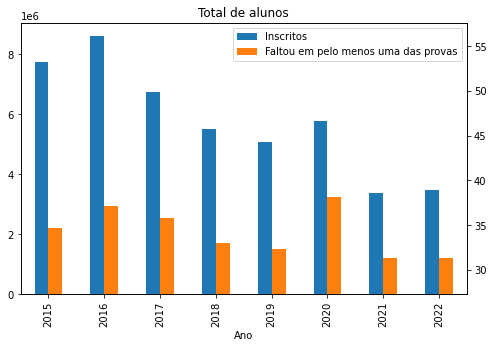

In [49]:
# Students' registrations and absences plot
df = pd.DataFrame(registrations_and_absences)

fig, ax1 = plt.subplots(1,1, figsize = (8,5))
ax2 = ax1.twinx()

df["Percentual de alunos faltantes"] = 100*df["absences"]/df["registrations"]
df.rename(columns = {"year": 'Ano', "absences": "Faltou em pelo menos uma das provas", "registrations": "Inscritos"}, inplace = True)

df.groupby("Ano")["Percentual de alunos faltantes"].mean().plot(ax = ax2)
ax2.plot(df["Ano"], df["Percentual de alunos faltantes"], 'r-.')
df.groupby("Ano")[["Inscritos", "Faltou em pelo menos uma das provas"]].mean().plot(kind = 'bar',
    figsize = (8,5),
    title = "Total de alunos",
    ax = ax1)
# ax1.set_xticklabels(labels = df["Ano"], rotation = 45)





From the graphic plotted above, we can understand students' registrations to take ENEM in each year, as well as their absences, in absolute numbers. It is worth noting the increase in absences for 2020, the year the COVID-19 pandemic ecloded.

Overall, absence ratios remained between 28 - 39 % for most years (except for 2020).

Students who missed at least one of ENEM's exams were not considered in the analysis.

In [28]:
# storing dataframe
joblib.dump(df, "inscrições_e_faltas.pkl")

['inscrições_e_faltas.pkl']

___
##### Top10 variables with the most null values

Let us plot average and standard deviation for the columns with the most null values between 2015 and 2023. This should aid us in defining which columns should be excluded due to  excess of missing data.

In [82]:
null_values_df = pd.DataFrame()
for year in years_to_analyze:
    df_year = pd.read_csv(f"../Datasets/enem-inep-data/{year}/DADOS/MICRODADOS_ENEM_{year}.csv", sep = ';', encoding = 'latin1')
    df_year = df_year.isna().sum()/df_year.shape[0]
    df_year.rename(year, inplace = True)
    null_values_df = pd.concat([null_values_df, df_year], axis = 1)
    del df_year
joblib.dump(null_values_df, "null_values_sum_2015_to_2023.pkl")

['null_values_sum_2015_to_2023.pkl']

In [86]:
# Visualizing in raw, "table", format
null_values_df.sort_values(by = 2022, ascending = False)

2015          2016      2017      2018      2019  \
TP_LOCALIZACAO_ESC      0.787094  7.819423e-01  0.734689  0.737235  0.774809   
CO_UF_ESC               0.787094  7.819423e-01  0.734689  0.737235  0.774809   
TP_SIT_FUNC_ESC         0.787322  7.819468e-01  0.735574  0.737235  0.774809   
TP_DEPENDENCIA_ADM_ESC  0.787094  7.819423e-01  0.734689  0.737235  0.774809   
SG_UF_ESC               0.787094  7.819423e-01  0.734689  0.737235  0.774809   
...                          ...           ...       ...       ...       ...   
Q046                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q047                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q048                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q049                    0.000103  4.636510e-07       NaN       NaN       NaN   
Q050                    0.000103  4.636510e-07       NaN       NaN       NaN   

                            2020      2021      2022  
TP_LOCALIZACAO_ESC      0.843584  0.759927  0.726146  
CO_UF_ESC               0.843584  0.759927  0.726146  
TP_SIT_FUNC_ESC         0.843584  0.759927  0.726146  
TP_DEPENDENCIA_ADM_ESC  0.843584  0.759927  0.726146  
SG_UF_ESC               0.843584  0.759927  0.726146  
...                          ...       ...       ...  
Q046                         NaN       NaN       NaN  
Q047                         NaN       NaN       NaN  
Q048                         NaN       NaN       NaN  
Q049                         NaN       NaN       NaN  
Q050                         NaN       NaN       NaN  

[105 rows x 8 columns]

In [94]:
nv = pd.concat([null_values_df.mean(axis = 1), null_values_df.std(axis=1)], axis = 1).rename(columns = {0: "Média", 1: "Desvio-padrão"})
nv.to_excel("../mean_and_std_null_values.xlsx") # Excel export

<ipython-input-94-2c8dcbbd1ea4>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  nv.to_excel("../mean_and_std_null_values.xlsx")


In [63]:
nan_values_2 = df[(df['TP_PRESENCA_CN'].isin([0,2])) | (df['TP_PRESENCA_CH'].isin([0,2]))
    | (df['TP_PRESENCA_MT'].isin([0,2])) | (df['TP_PRESENCA_LC'].isin([0,2])) 
    | (df['TP_STATUS_REDACAO'] != 1)].isna().sum()

In [64]:
nan_values_2[["SG_UF_ESC", "SG_UF_PROVA", "CO_UF_ESC", "CO_UF_PROVA"]]

SG_UF_ESC      937764
SG_UF_PROVA         0
CO_UF_ESC      937764
CO_UF_PROVA         0
dtype: int64

In [3]:
nan_values = joblib.load("null_values_sum_2015_to_2023.pkl")

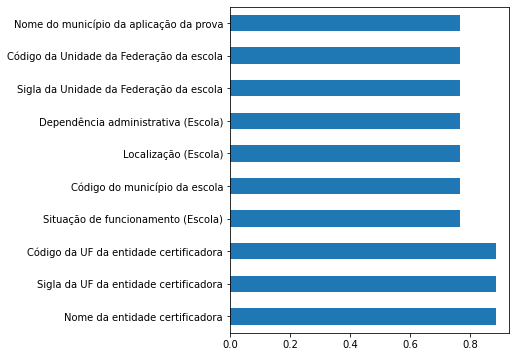

In [25]:
rects = nan_values.mean(axis = 1)\
    .sort_values(ascending = False)[0:10]\
    .rename(index = {'NO_MUNICIPIO_ESC': 'Nome do município da aplicação da prova',
        'CO_MUNICIPIO_ESC': 'Código do município da escola',
        'SG_UF_ESC': 'Sigla da Unidade da Federação da escola',
        'TP_DEPENDENCIA_ADM_ESC': 'Dependência administrativa (Escola)',
        'TP_SIT_FUNC_ESC': 'Situação de funcionamento (Escola)',
        'CO_UF_ESC': 'Código da Unidade da Federação da escola',
        'TP_LOCALIZACAO_ESC': 'Localização (Escola)',
        'CO_UF_ENTIDADE_CERTIFICACAO': 'Código da UF da entidade certificadora',
        'SG_UF_ENTIDADE_CERTIFICACAO': 'Sigla da UF da entidade certificadora',
        'NO_ENTIDADE_CERTIFICACAO': 'Nome da entidade certificadora'})\
    .plot(kind = 'barh', figsize = (5, 6))


We can see thatthere are columns with the majority (> 80%) of data missing, rendering them virtually unusable for our case, since we do not have an elaborate approach for filling in these missing values.
___

### 1.2. ENEM processed data

In [4]:
# Reading ENEM raw data, as downloaded from INEP's website, and executing a few processing steps on the data
enem_df = pd.DataFrame()
for year in [2015]:
    print(f"Processing data for {year}")
    df = load_and_preprocess_ENEM_raw_data(filepath = common_path + f"{year}/DADOS/MICRODADOS_ENEM_{year}.csv", enem_year = year)
    df['ENEM_year'] = year

    df['School type'] = df['TP_ESCOLA'].apply(lambda x: 
                                                'Public' if x == 2 
                                                else 'Private' if x == 3
                                                else 'No answer')

    joblib.dump(df, f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    print(f"Saved data for {year}!\n")

    enem_df = pd.concat([enem_df, df], axis = 0)
    del df
joblib.dump(enem_df, f"ENEM_dataframe_years_{years_to_analyze[0]}_to_{years_to_analyze[-1]}_based_on_SG_UF_PROVA")

Processing data for 2015
Saved data for 2015!

Processing data for 2016
Saved data for 2016!

Processing data for 2017
Saved data for 2017!

Processing data for 2018
Saved data for 2018!

Processing data for 2019
Saved data for 2019!

Processing data for 2020
Saved data for 2020!

Processing data for 2021
Saved data for 2021!

Processing data for 2022
Saved data for 2022!



['ENEM_dataframe_years_2015_to_2022_based_on_SG_UF_PROVA']

### 1.3. External data

We will read the external data using the functions in "external_data_loading.py".

In [3]:
siope_df = get_siope_data("../Datasets/external-data/siope-data")

In [39]:
siope_df

year metric_code  metric_value  UF  \
0     2008         2.1          0.00  RO   
1     2008        4.11         62.50  RO   
2     2008         2.3          0.00  RO   
3     2008         2.4          0.00  RO   
4     2008         2.5         78.36  RO   
...    ...         ...           ...  ..   
7393  2017        2.12          0.16  DF   
7394  2017         3.5         73.01  DF   
7395  2017         4.1       7464.85  DF   
7396  2017         4.2       9904.41  DF   
7397  2017         4.9       8465.67  DF   

                              metric_description  
0                                EI_FUNDEB_ratio  
1     EB_non_teaching_staff_per_student_expanses  
2                                EM_FUNDEB_ratio  
3                 EI_to_total_education_expanses  
4                 EF_to_total_education_expanses  
...                                          ...  
7393          education_to_total_MDE_investments  
7394                 FUNDEB_teacher_to_total_MDE  
7395                   EI_investment_per_student  
7396                   EF_investment_per_student  
7397                      investment_per_student  

[7398 rows x 5 columns]

## 2. Correlation analysis

In [2]:
# load data, if needed
enem_df = joblib.load("C:/Users/cstefano/students_performance_project/data analysis/ENEM_dataframe_years_2015_to_2022_based_on_SG_UF_PROVA.pkl")

In [3]:
enem_df.drop(columns = "TP_ESCOLA", inplace = True)

In [4]:
enem_df.shape

(29749997, 40)

In [5]:
enem_df_with_dummies = pd.get_dummies(enem_df, columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                   'Q001', 'Q002', 'Q003', 'Q004',
                                   'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                   'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                   'Q023', 'Q024', 'Q025', 'School type'])

### 2.1. Correlation of variables throughout the years - ENEM database

In [6]:
from scipy.stats import pointbiserialr

In [12]:
def pointbiserial_corr(x,y):
    return pointbiserialr(x,y)[0]

In [14]:
enem_df.columns

Index(['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
       'High school conclusion year', 'School type', 'UF', 'SG_UF_PROVA',
       'Natural Sciences score', 'Humanities score', 'Languages score',
       'Math score', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007',
       'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
       'Average score', 'ENEM_year'],
      dtype='object')

In [15]:
enem_2022 = enem_df_with_dummies[enem_df_with_dummies["ENEM_year"] == 2022].drop(columns = ["Natural Sciences score", "Humanities score",
                                                                                            "Languages score", "Math score"])

In [16]:
R = enem_2022.corr(method = pointbiserial_corr)

<ipython-input-16-c8225e3a59a4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  R = enem_2022.corr(method = pointbiserial_corr)
c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [21]:
joblib.dump(R, "./variables_results/ENEM_2022_correlations_with_UF_SG_PROVA_point_biserial.pkl")

['./variables_results/ENEM_2022_correlations_with_UF_SG_PROVA_point_biserial.pkl']

In [19]:
enem_2022.shape

(2245649, 191)

In [17]:
R["Average score"].sort_values(ascending = False)[0:15]

Average score    1.000000
Q018_B           0.309980
Q016_B           0.269638
Ethinicity_1     0.262456
Q014_B           0.257375
Q003_E           0.247566
Q004_D           0.226896
Q003_D           0.226652
Q001_G           0.223729
Q024_C           0.223499
Q002_G           0.222108
Q010_C           0.210201
Q013_B           0.209828
Q001_F           0.208959
Q004_E           0.207475
Name: Average score, dtype: float64

In [18]:
R["Average score"].sort_values(ascending = False)[0:15]

Average score             1.000000
Humanities score          0.872722
Math score                0.864417
Languages score           0.848827
Natural Sciences score    0.773551
School type_Private       0.393106
Q018_B                    0.318025
Ethinicity_1              0.280829
Q016_B                    0.269654
Q003_E                    0.259102
Q014_B                    0.258889
Q001_G                    0.237446
Q002_G                    0.234679
Q003_D                    0.223616
Q004_D                    0.223457
Name: Average score, dtype: float64

In [30]:
x = joblib.load("./variables_results/ENEM_2022_correlations_with_UF_SG_PROVA_point_biserial.pkl")
joblib.dump(x["Average score"], "./variables_results/ENEM_2022_average_score_correlations_with_UF_SG_PROVA_point_biserial.pkl")
del x

In [25]:
# Correlations within ENEM databases for each year under analysis
years_to_analyze = np.arange(2015, 2022)
for year in years_to_analyze:
    print(f"Calculating correlations for {year} data")
    correlations_enem_data = enem_df_with_dummies[enem_df_with_dummies["ENEM_year"] == year]\
        .drop(columns = "ENEM_year")\
        .corr(method = pointbiserial_corr, numeric_only = True)
    
    joblib.dump(correlations_enem_data, f"./variables_results/ENEM_{year}_correlations_with_UF_SG_PROVA_point_biserial.pkl")
    joblib.dump(correlations_enem_data["Average score"], f"./variables_results/ENEM_{year}_average_score_correlations_with_UF_SG_PROVA_point_biserial.pkl")

    del correlations_enem_data

Calculating correlations for 2015 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2016 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2017 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2018 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2019 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2020 data


c:\Users\cstefano\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating correlations for 2021 data


Evaluating correlations year-wise

##### Loading data

In [98]:
# Considering the student belongs to the same UF where they took the test
years_to_analyze = np.arange(2015, 2023)
R = pd.DataFrame()
for year in years_to_analyze:
    R_year = joblib.load(f"./variables_results/ENEM_{year}_average_score_correlations_with_UF_SG_PROVA_point_biserial.pkl")
    R_year.rename(year, inplace = True)
    R = pd.concat([R, R_year], axis = 1)
    del R_year

In [99]:
# Just to visualize how 'R' is structured
R.drop(index = "ENEM_year", inplace = True) # drop of unecessary row
R

2015      2016      2017      2018      2019  \
High school conclusion year  0.048507  0.040847  0.014119 -0.005575  0.000627   
Natural Sciences score       0.819818  0.826842  0.805349  0.813626  0.854865   
Humanities score             0.832470  0.839867  0.859202  0.827893  0.867406   
Languages score              0.814880  0.795113  0.816650  0.840443  0.834955   
Math score                   0.844209  0.835541  0.840107  0.839421  0.867821   
...                               ...       ...       ...       ...       ...   
Q025_A                      -0.287723 -0.286316 -0.287798 -0.273506 -0.264759   
Q025_B                       0.287649  0.286315  0.287799  0.273506  0.264759   
School type_No answer        0.009346  0.001471  0.043786  0.174595  0.020487   
School type_Private          0.216565  0.224168  0.220988 -0.003662  0.225278   
School type_Public          -0.130468 -0.124515 -0.173080 -0.174887 -0.139636   

                                 2020      2021      2022  
High school conclusion year  0.026224  0.074577  0.070572  
Natural Sciences score       0.859856  0.857375       NaN  
Humanities score             0.883982  0.876735       NaN  
Languages score              0.833176  0.861734       NaN  
Math score                   0.884130  0.865957       NaN  
...                               ...       ...       ...  
Q025_A                      -0.241703 -0.192561 -0.187992  
Q025_B                       0.234328  0.192562  0.187992  
School type_No answer        0.003965  0.070202  0.065117  
School type_Private          0.208722  0.190848  0.203091  
School type_Public          -0.122415 -0.189343 -0.191433  

[192 rows x 8 columns]

R, is, thus, structured as a matrix of each ENEM feature, in a row, and each year, as a column.
___

##### Result: correlations average and dispersion

The following cells are used to structure average correlations plots between 2015 and 2022. Each information originally present in the INEP databases is correlated to the students' average outcome in ENEM for that year.

In [100]:
R.rename(index = {
    'Ethinicity_1': 'Cor/raça branca',
    'School type_Private': 'Escola privada',
    'Gender_M': 'Gênero masculino',
    'Nacionality_1': 'Nacionalidade brasileira',
    'High school conclusion year': 'Ano de conclusão do EM',
    'School type_No answer': 'Tipo de escola desconhecido',
    'Age group_1': 'Menos de 17 anos',
    'Ethinicity_0': 'Cor/raça não declarada',
    'Marital state_0.0': 'Estado civil não informado',
    'Nacionality_4': 'Brasileiro(a) nascido(a) no exterior',
    'Marital state_1.0': 'Solteiro(a)',
    'Age group_3': '18 anos',
    'Ethinicity_6': 'Não dispõe de informação (cor/raça)',
    'Nacionality_3': 'Estrangeiro(a)',
    'Ethinicity_4': 'Cor/raça amarela',
    'Age group_20': 'Maior de 70 anos',
    'Age group_10': '25 anos',
    'Age group_9': '24 anos',
    'Age group_11': 'Entre 26 e 30 anos',
    'Age group_19': 'Entre 66 e 70 anos',
    'Nacionality_0': 'Nacionalidade não informada',
    'Age group_8': '23 anos',
    'Age group_7': '22 anos',
    'Age group_18': 'Entre 61 e 65 anos',
    'Age group_4': '19 anos',
    'Age group_5': '20 anos',
    'Age group_6': '21 anos',
    'Marital state_4.0': 'Viúvo(a)',
    'Age group_12': 'Entre 31 e 35 anos',
    'Age group_17': 'Entre 56 e 60 anos',
    'Marital state_3.0': 'Divorciado(a)',
    'Age group_15': 'Entre 46 e 50 anos',
    'Age group_16': 'Entre 51 e 55 anos',
    'Age group_13': 'Entre 36 e 40 anos',
    'Marital state_2.0': 'Casado(a)',
    'Age group_14': 'Entre 41 e 45 anos',
    'Ethinicity_5': 'Cor/raça indígena',
    'Nacionality_2': 'Brasileiro(a) naturalizado(a)',
    'Ethinicity_2': 'Cor/raça preta',
    'Gender_F': 'Gênero feminino',
    'School type_Public': 'Escola pública',
    'Ethinicity_3': 'Cor/raça parda',
    'Q018_B': 'Tem aspirador de pó na residência',
    'Q016_B': 'Um forno micro-ondas na residência',
    'Q014_B': 'Uma máquina de lavar roupa na residência',
    'Q025_B': 'Possui acesso à internet',
    'Q003_D': 'Ocupação do responsável homem está no Grupo 4',
    'Q004_D': 'Ocupação da responsável mulher está no Grupo 4',
    'Q023_B': 'Possui telefone fixo',
    'Q021_B': 'Possui TV por assinatura',
    'Q003_E': 'Ocupação do responsável homem está no Grupo 5',
    'Q013_B': 'Possui um freezer na residência',
    'Q024_C': 'Possui dois computadores',
    'Q010_C': 'Possui dois carros na residência',
    'Q001_F': 'Grau de instrução do responsável homem: Ensino Superior',
    'Q002_G': 'Grau de instrução da responsável mulher: Pós-Graduação',
    'Q001_G': 'Grau de instrução do responsável homem: Pós-Graduação',
    'Q004_E': 'Ocupação da responsável mulher está no Grupo 5',
    'Q002_F': 'Grau de instrução da responsável mulher: Ensino Superior',
    'Q022_E': 'Quatro ou mais telefones celulares na residência',
    'Q008_D': 'Três banheiros na residência',
    'Q002_B': 'Grau de instrução da responsável mulher: Ensino Fundamental I incompleto',
    'Q001_B': 'Grau de instrução do responsável homem: Ensino Fundamental I incompleto',
    'Q007_A': 'Não trabalha empregado(a) doméstico(a) na residência',
    'Q022_B': 'Um telefone celular na residência',
    'Q004_A': 'Ocupação da responsável mulher está no Grupo 1',
    'Q003_A': 'Ocupação do responsável homem está no Grupo 1',
    'Q021_A': 'Não há TV por assinatura na residência',
    'Q023_A': 'Não há telefone fixo na residência',
    'Q019_B': 'Há uma televisão a cores na residência',
    'Q013_A': 'Não há freezer na residência',
    'Q025_A': 'Não tem acesso à internet na residência',
    'Q014_A': 'Não há máquina de lavar roupa na residência',
    'Q016_A': 'Não há forno micro-ondas na residência',
    'Q006_B': 'Renda mensal familiar: Até um salário mínimo',
    'Q008_B': 'Um banheiro na residência',
    'Q008_E': 'Quatro ou mais banheiros na residência',
    'Q010_A': 'Não há carro na residência',
    'Q024_A': 'Não há computador na residência',
    'Q018_A': 'Não há aspirador de pó na residência',
    'Q006_A': 'Nenhuma renda',
    'Q006_B': 'Renda até 1 salário mínimo',
    'Q006_C': 'Renda de mais de 1 e até 1,5 salários mínimos',
    'Q006_D': 'Renda de mais de 1,5 e até 2 salários mínimos',
    'Q006_E': 'Renda de mais de 2 e até 2,5 salários mínimos',
    'Q006_F': 'Renda de mais de 2,5 e até 3 salários mínimos',
    'Q006_G': 'Renda de mais de 3 e até 4 salários mínimos',
    'Q006_H': 'Renda de mais de 4 e até 5 salários mínimos',
    'Q006_I': 'Renda de mais de 5 e até 6 salários mínimos',
    'Q006_J': 'Renda de mais de 6 e até 7 salários mínimos',
    'Q006_K': 'Renda de mais de 7 e até 8 salários mínimos',
    'Q006_L': 'Renda de mais de 8 e até 9 salários mínimos',
    'Q006_M': 'Renda de mais de 9 e até 10 salários mínimos',
    'Q006_N': 'Renda de mais de 10 e até 12 salários mínimos',
    'Q006_O': 'Renda de mais de 12 e até 15 salários mínimos',
    'Q006_P': 'Renda de mais de 15 e até 20 salários mínimos',
    'Q006_Q': 'Renda acima de 20 salários mínimos'
}, inplace = True)

Let us design a correlations plot in which we can visualize correlations of all variables.

In [61]:
def plot_correlations_with_average_score(R, n_left=85, n_right = 90, figsize = (18,26), colors_left = ['b'], colors_right = ['b']):
    '''
    Plots correlation as horizontal barplots given the input correlation matrix, R.
    Inputs:
        R - correlation matrix (nFeatures x nYears)
        n_left - number of elements to display on left plot. If no value is specified, n_left is offset to 85
        n_right - number of elements to display on the right plot. If no vallue is specified, n_right is offset to 90.
        figsize - 2D-tuple specifying the figure size.
        colors_left - list of colors for the left plot.
        colors_right - list of colors for the right plot.
    Outputs:
        No outputs are provided by this function. Plot only.
    '''

    _, ax = plt.subplots(1,2,figsize = figsize)

    values_to_plot = R.mean(axis=1).sort_values(ascending = False)

    # left graph
    x_values = values_to_plot[5:5+n_left].values
    xerr = R.std(axis = 1)[R.mean(axis=1).sort_values(ascending = False).index][5:5+n_left].values
    y_pos = np.arange(0,len(x_values))[::-1]

    hbars = ax[0].barh(y = y_pos,
        width =  x_values,
        xerr = xerr,
        color = colors_left)

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)

    ax[0].set_yticks(y_pos, labels = values_to_plot[5:5+n_left].index)

    ax[0].xaxis.set_visible(False)
    ax[0].bar_label(hbars, fmt = '%.2f')
    ax[0].set_xlim([0, 0.45])

    # Creating patches to "manually" input legend
    patch_infra = mpatches.Patch(color = '#1f77b4', label = "Infraestrutura da residência")
    patch_parents = mpatches.Patch(color = '#ff7f0e', label = "Ocupação e formação dos responsáveis")
    patch_demo = mpatches.Patch(color = '#929591', label = "Características demográficas")
    plt.legend(handles = [patch_infra, patch_parents, patch_demo],
                 loc = "best",
                 ncols = 3,
                 bbox_to_anchor = (1.6, 1.04))

    # right graph
    x_values = values_to_plot[194-n_right-2:194].values
    xerr = R.std(axis = 1)[R.mean(axis=1).sort_values(ascending = False).index][194-n_right-2:194].values
    y_pos = np.arange(0,len(x_values))[::-1]


    ax[1].yaxis.tick_right()
    hbars = ax[1].barh(y = y_pos,
        width =  x_values,
        xerr = xerr,
        color = colors_right)

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)

    ax[1].set_yticks(y_pos, labels = values_to_plot[194-n_right-2:194].index)

    ax[1].xaxis.set_visible(False)
    ax[1].bar_label(hbars, fmt = '%.2f')
    ax[1].set_xlim([-0.5, 0])

    plt.suptitle('Correlações ponto-bisseriais com o desempenho médio dos estudantes')
    plt.tight_layout()

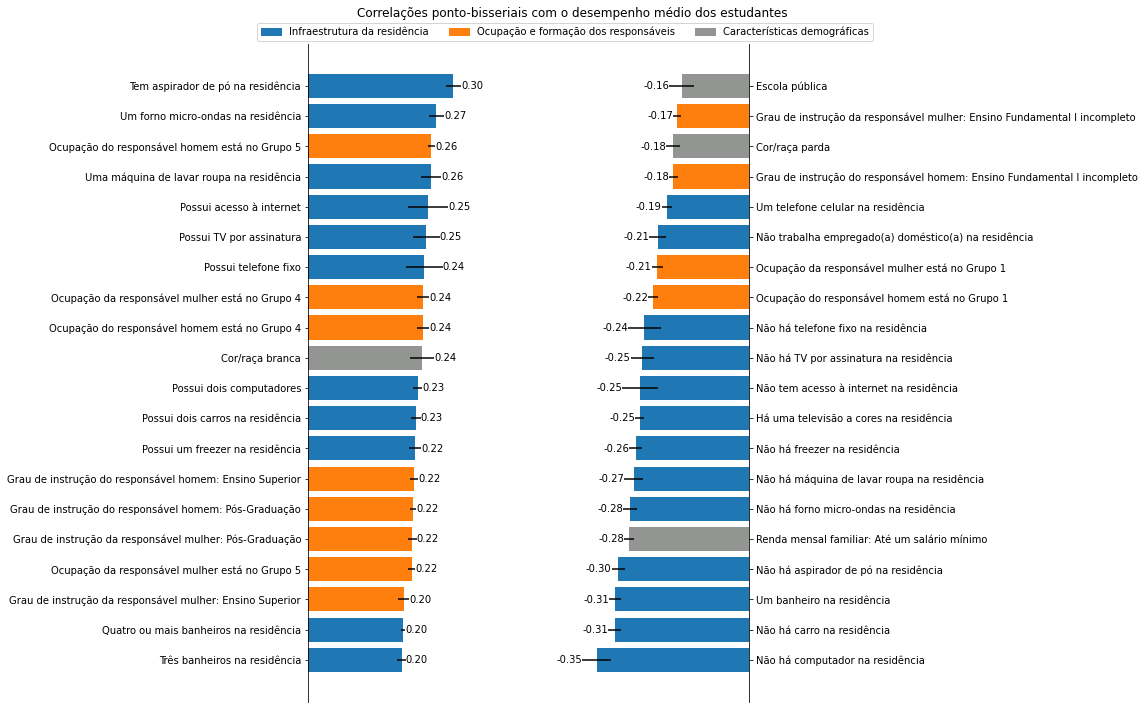

In [70]:
plot_correlations_with_average_score(R, n_left = 20, n_right = 20, figsize = (16,10),
                                     colors_left = ['#1f77b4','#1f77b4', '#ff7f0e', '#1f77b4',
                                                    '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e',
                                                    '#ff7f0e', '#929591','#1f77b4', '#1f77b4',
                                                    '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e',
                                                    '#ff7f0e', '#ff7f0e', '#1f77b4', '#1f77b4'], 
                                    colors_right = ['#929591', '#ff7f0e', '#929591', '#ff7f0e',
                                                    '#1f77b4','#1f77b4', '#ff7f0e', '#ff7f0e',
                                                    '#1f77b4','#1f77b4', '#1f77b4', '#1f77b4',
                                                    '#1f77b4', '#1f77b4', '#1f77b4', '#929591',
                                                    '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4'],
                                    )

The previous plot highlights the 20 highest, and lowest, correlations with studennts' average performance in ENEM between 2015 and 2022. Variables were categorized as "home infrastructure" (blue), "parents' occupation and education" (orange) and "other demographical data" (gray).

It is interesting to note that, generally, students that perform the best come from households with better infrastructure and whose parents usually had access to Higher Education, whereas also holding overall better-paid professions ("Grupo 5"). Almost the opposite could be stated for the negative correlations, which are associated to worse scores on the exam.

To get the whole picture, the graph that follows is the default for "plot_correlations_with_average_score()", which encompassess all variables in the original database.

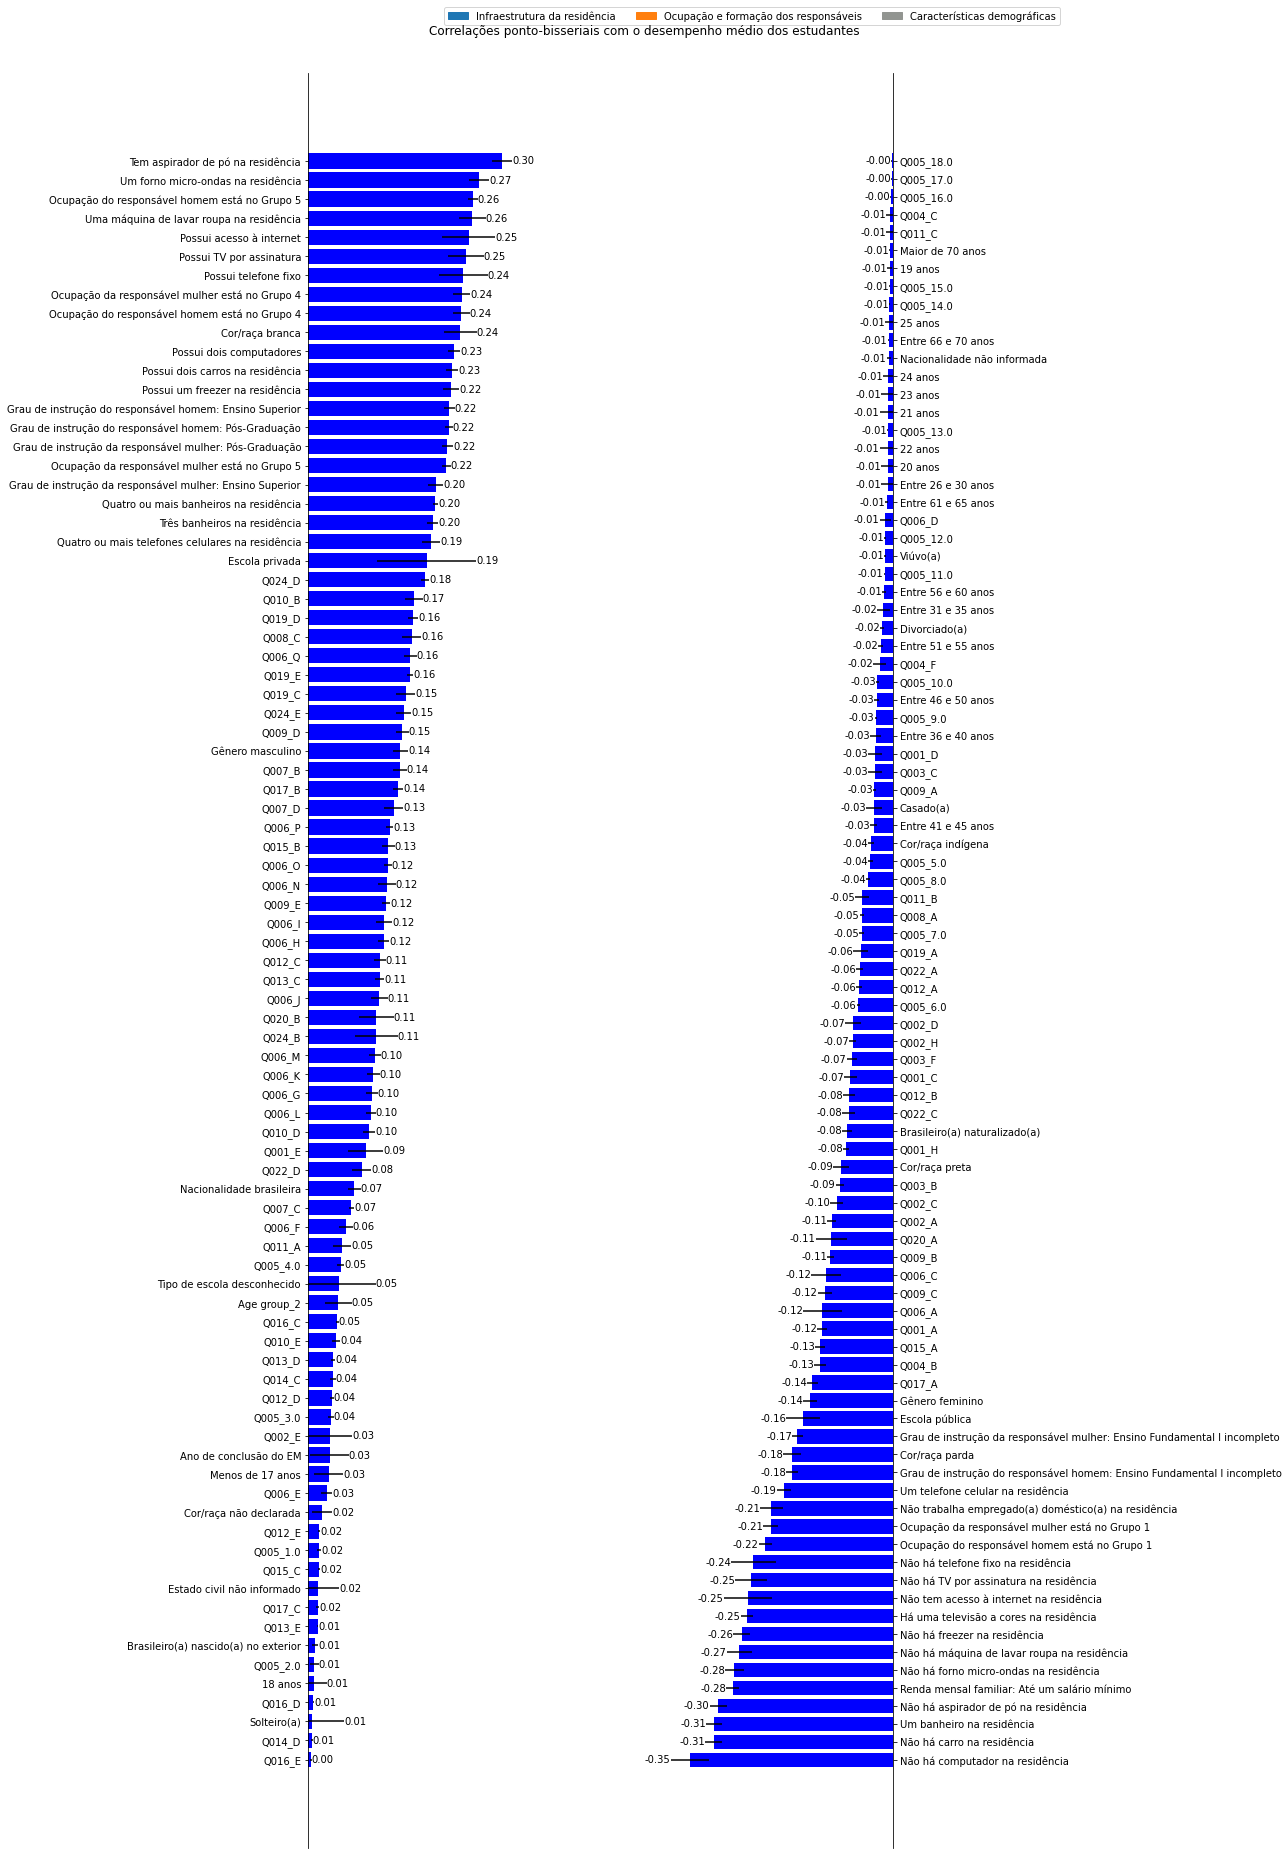

In [71]:
# Default plot - all variables
plot_correlations_with_average_score(R)

#### A special focus on correlation with family income

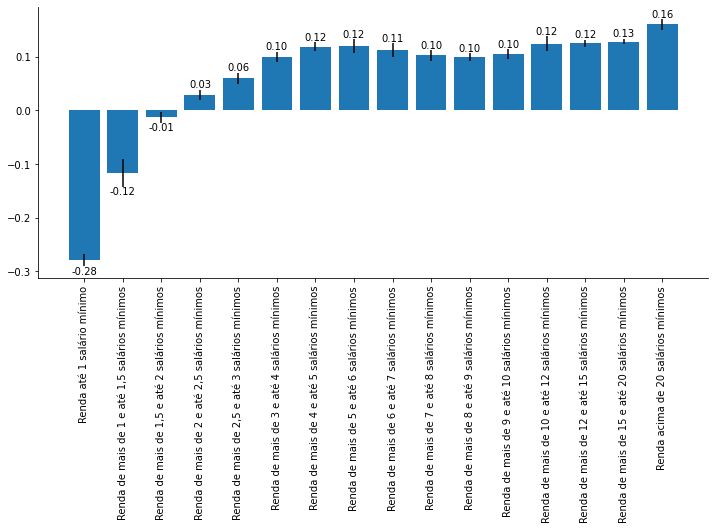

In [107]:
# Plot for correlations with family income
_, ax = plt.subplots(1,1, figsize = (12,5))

income_entries = R.filter(like='Renda', axis=0) # get only entries related to family income

values_to_plot = income_entries.mean(axis = 1)
values_to_plot_err = income_entries.std(axis = 1)
x_pos = np.arange(0, len(values_to_plot))

hbars = ax.bar(x = x_pos, height = values_to_plot, yerr = values_to_plot_err)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(x_pos, labels = values_to_plot.index, rotation = 90)
ax.bar_label(hbars, fmt = '%.2f');

In [111]:
# Saving to work with data on external tools, if needed
income_entries.to_csv("./variables_results/correlations_income.csv")

___
### 2.2 Correlations with external factors

In the previous section, we analyzed correlations with the original variables in INEP databases, only. Now, let us also evaluate correlations with the external variables.

#### 2.2.1. Preliminary tests

In [8]:
years_in_siope = siope_df['year'].unique()
years_in_siope.sort()

In [9]:
years_in_siope

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022])

Unfortunately, we don't have information about every metric for every year and state, as indicated by the draft visualization that follows.

<AxesSubplot: xlabel='metric_code', ylabel='year'>

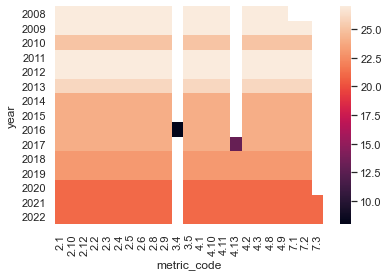

In [317]:
sns.heatmap(siope_df.groupby(["year", "metric_code"])["metric_code"].count().unstack())

To continue with the analysis, we will define time-windows of varying length that should yield average values for SIOPE's metrics, per each state of the country, that will subsequently be used for correlation analysis.

#### 2.2.2. Correlations using time-windows

For each year students took participated in the ENEM, let us calculate the correlations with these variables and their average score in the test, using a time window to analyze whether we can spot correlation patterns changes overtime.

##### 2.2.2.1. Correlation calculations

In [5]:
def merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_data, enem_data, current_year):
    metrics_added = []
    df2 = enem_data[enem_data["ENEM_year"] == current_year][["UF", "Average score", "Natural Sciences score"]].copy()

    for metric in SIOPE_METRICS_DICT.values():
        try:
            df2 = df2.merge(grouped_siope_data[metric], how = 'left', on = 'UF')
            metrics_added.append(metric)
        except:
            df2 = df2
    
    return df2

In [6]:
def reformat_external_siope_correlations(siope_correlations_data):
    siope_correlations_data.reset_index(inplace = True)
    siope_correlations_data.rename(columns = {"index": "metric"}, inplace = True)
    formatted_data = pd.DataFrame()
    i = 0
    for metric in siope_correlations_data['metric'].unique():
        aux_df = siope_correlations_data[siope_correlations_data['metric'] == metric][['window', 'Average score']]
        aux_df.rename(columns = {"Average score": metric}, inplace = True)

        if i == 0:
            formatted_data = pd.concat([formatted_data, aux_df], axis = 1)
        else:
            formatted_data = formatted_data.merge(aux_df, on = 'window', how = 'left')
        i += 1
    return formatted_data

In [7]:
def run_longitudinal_correlation_analysis(years_to_analyze, time_window):
    R_external_all_years = {}
    for year in years_to_analyze:
        R_external = pd.DataFrame()
        print(f"Running analysis for ENEM {year}")
        for window in n:
            print(f"Running for the last {window} year(s)")
            # get metrics average values over last 'window' years
            grouped_siope_df = siope_df[(siope_df['year'] >= year - window)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

            siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
            r = siope_data_with_scores_df.corr(method = 'spearman', numeric_only = True)
            r["window"] = window
            R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

            del siope_data_with_scores_df
        joblib.dump(R_external, f"siope_correlations_ENEM_{year}.pkl")

        R_external_all_years[year] = R_external
        del R_external
    
    return R_external_all_years 
    

In [27]:
enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")

In [29]:
n = np.arange(0,16)

for year in years_to_analyze:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df.drop(columns = "UF", inplace = True)
    enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)
    
    for window in n:
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()



        siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
        r = siope_data_with_scores_df.corr(method = 'spearman', numeric_only = True)
        r["window"] = window
        R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

        del siope_data_with_scores_df
    joblib.dump(R_external, f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_v3.pkl")
    del R_external

Running analysis for ENEM 2015
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s)
Running for the last 14 year(s)
Running for the last 15 year(s)
Running analysis for ENEM 2016
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s

In [22]:
joblib.load("siope_correlations_ENEM_2022_based_on_SG_UF_PROVA_v3.pkl")

Average score  window
Average score                                    1.000000       0
Natural Sciences score                           0.757797       0
EI_FUNDEB_ratio                                       NaN       0
EF_FUNDEB_ratio                                  0.164503       0
EM_FUNDEB_ratio                                 -0.159174       0
...                                                   ...     ...
EB_non_teaching_staff_per_student_expanses       0.133566      15
investment_per_student_to_PIB_per_capita              NaN      15
superavit_or_deficit                             0.044461      15
FUNDEB_balance                                   0.103238      15
FUNDEB_not_used                                 -0.099481      15

[394 rows x 2 columns]

In [8]:
def effect_size(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [12]:
columns = siope_data_with_scores_df.columns.to_list()

In [13]:
columns

['UF',
 'Average score',
 'EB_expanses_teacher_per_student',
 'EB_investment_per_student',
 'EB_non_teaching_staff_per_student_expanses',
 'EF_FUNDEB_ratio',
 'EF_investment_per_student',
 'EF_to_total_education_expanses',
 'EI_FUNDEB_ratio',
 'EI_investment_per_student',
 'EI_to_total_education_expanses',
 'EM_FUNDEB_ratio',
 'EM_investment_per_student',
 'EM_to_total_education_expanses',
 'FUNDEB_balance',
 'FUNDEB_not_used',
 'FUNDEB_teacher_to_total_MDE',
 'courseware_investment',
 'education_to_overall_expanses',
 'education_to_total_MDE_investments',
 'investment_per_student',
 'investment_per_student_to_PIB_per_capita',
 'scholar_nutrition_to_total_education_expanses',
 'superavit_or_deficit']

In [8]:
for year in [2022]:
    for window in [0]:
        enem_df = joblib.load(f"ENEM_preprocessed_2022_based_on_SG_UF_PROVA.pkl")
        enem_df.drop(columns = "UF", inplace = True)
        enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

        grouped_siope_df = siope_df[(siope_df['year'] >= 2022 - 0) & (siope_df["year"] <= 2022)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

        print("Merging data")
        siope_data_with_scores_df = enem_df[["UF", "Average score"]].merge(grouped_siope_df, on = 'UF', how = 'left')
        print("Data merged!")

Merging data
Data merged!


In [14]:
r = np.zeros((24, 24))
p = r
effect = r

for i in columns:
    print(f"Column {i}")
    for j in columns:
        r[i][j], p[i][j] = spearmanr(siope_data_with_scores_df[i],
                                             siope_data_with_scores_df[j])
        effect[i][j] = effect_size(siope_data_with_scores_df[i],
                                           siope_data_with_scores_df[j])

In [9]:
grouped_siope_df = siope_df[(siope_df['year'] >= 2022 - 0) & (siope_df["year"] <= 2022)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

In [10]:
siope_data_with_scores_df = enem_df[["UF", "Average score"]].merge(grouped_siope_df, on = 'UF', how = 'left')

In [11]:
siope_data_with_scores_df.head()

UF  Average score  EB_expanses_teacher_per_student  \
0  BA        507.800                          5189.21   
1  ES        413.275                          3728.34   
2  RJ        407.625                              NaN   
3  PE        457.625                          5634.89   
4  SE        485.875                          7110.81   

   EB_investment_per_student  EB_non_teaching_staff_per_student_expanses  \
0                   16043.05                                        0.00   
1                    9705.21                                      331.45   
2                        NaN                                         NaN   
3                   13973.60                                        0.00   
4                   13426.85                                        0.00   

   EF_FUNDEB_ratio  EF_investment_per_student  EF_to_total_education_expanses  \
0            21.87                   12478.29                           11.44   
1            48.02                   12447.86                           40.23   
2              NaN                        NaN                             NaN   
3            44.84                   11003.38                           21.79   
4            33.64                    9627.50                           31.47   

   EI_FUNDEB_ratio  EI_investment_per_student  ...  FUNDEB_balance  \
0              0.0                    9633.19  ...    3.010188e+08   
1              0.0                    1046.79  ...    1.428802e+08   
2              NaN                        NaN  ...             NaN   
3              0.0                    4626.40  ...    3.655077e+08   
4              0.0                       0.00  ...    5.187232e+05   

   FUNDEB_not_used  FUNDEB_teacher_to_total_MDE  courseware_investment  \
0     1.995258e+07                          0.0                   2.05   
1     6.412607e+07                          0.0                   0.00   
2              NaN                          NaN                    NaN   
3     3.356645e+08                          0.0                  37.78   
4     5.044878e+05                          0.0                   0.00   

   education_to_overall_expanses  education_to_total_MDE_investments  \
0                          16.48                                 0.0   
1                          12.85                                 0.0   
2                            NaN                                 NaN   
3                          13.59                                 0.0   
4                          15.39                                 0.0   

   investment_per_student  investment_per_student_to_PIB_per_capita  \
0                14345.56                                       0.0   
1                 9494.99                                       0.0   
2                     NaN                                       NaN   
3                12552.79                                       0.0   
4                13291.76                                       0.0   

   scholar_nutrition_to_total_education_expanses  superavit_or_deficit  
0                                           0.00          5.670903e+09  
1                                           2.48          1.236219e+09  
2                                            NaN                   NaN  
3                                           0.00          6.723911e+08  
4                                           0.00         -2.427053e+09  

[5 rows x 24 columns]

In [144]:
siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)

In [147]:
siope_data_with_scores_df

UF  Average score  Natural Sciences score  EI_FUNDEB_ratio  \
0        NaN        507.800                   421.1              NaN   
1        NaN        413.275                   490.7              NaN   
2        NaN        407.625                   398.1              NaN   
3        NaN        457.625                   467.5              NaN   
4        NaN        485.875                   458.7              NaN   
...      ...            ...                     ...              ...   
2245644  NaN        465.500                   444.5              NaN   
2245645  NaN        587.400                   536.1              NaN   
2245646   MG        531.525                   487.6         0.043333   
2245647  NaN        504.025                   512.5              NaN   
2245648   SC        593.825                   527.9         0.080000   

         EF_FUNDEB_ratio  EM_FUNDEB_ratio  EF_to_total_education_expanses  \
0                    NaN              NaN                             NaN   
1                    NaN              NaN                             NaN   
2                    NaN              NaN                             NaN   
3                    NaN              NaN                             NaN   
4                    NaN              NaN                             NaN   
...                  ...              ...                             ...   
2245644              NaN              NaN                             NaN   
2245645              NaN              NaN                             NaN   
2245646        79.430000        16.476667                       74.281667   
2245647              NaN              NaN                             NaN   
2245648        67.723333        31.044000                       43.820000   

         EI_to_total_education_expanses  EM_to_total_education_expanses  \
0                                   NaN                             NaN   
1                                   NaN                             NaN   
2                                   NaN                             NaN   
3                                   NaN                             NaN   
4                                   NaN                             NaN   
...                                 ...                             ...   
2245644                             NaN                             NaN   
2245645                             NaN                             NaN   
2245646                            0.23                       18.445000   
2245647                             NaN                             NaN   
2245648                            0.62                       20.655333   

         education_to_overall_expanses  ...  EF_investment_per_student  \
0                                  NaN  ...                        NaN   
1                                  NaN  ...                        NaN   
2                                  NaN  ...                        NaN   
3                                  NaN  ...                        NaN   
4                                  NaN  ...                        NaN   
...                                ...  ...                        ...   
2245644                            NaN  ...                        NaN   
2245645                            NaN  ...                        NaN   
2245646                         16.290  ...                4557.041667   
2245647                            NaN  ...                        NaN   
2245648                         21.192  ...                5330.933333   

         EM_investment_per_student  EB_investment_per_student  \
0                              NaN                        NaN   
1                              NaN                        NaN   
2                              NaN                        NaN   
3                              NaN                        NaN   
4                              NaN                        NaN   
...                            ...      

In [156]:
enem_df.drop(columns = "UF", inplace = True)
enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)
siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)

In [159]:
siope_data_with_scores_df.head()

UF  Average score  Natural Sciences score  EI_FUNDEB_ratio  \
0  BA        507.800                   421.1         0.013333   
1  ES        413.275                   490.7         0.000000   
2  RJ        407.625                   398.1         0.025833   
3  PE        457.625                   467.5         0.024667   
4  SE        485.875                   458.7         0.001333   

   EF_FUNDEB_ratio  EM_FUNDEB_ratio  EF_to_total_education_expanses  \
0        34.378000        63.403333                       23.780667   
1        55.632667        42.639333                       49.733333   
2        47.840000        50.339167                       37.319167   
3        63.006000        33.575333                       52.842667   
4        45.096667        52.612000                       36.163333   

   EI_to_total_education_expanses  EM_to_total_education_expanses  \
0                        0.066000                       48.205333   
1                        0.441333                       39.832667   
2                        5.261667                       34.245000   
3                        0.307333                       34.892000   
4                        0.134667                       58.571333   

   education_to_overall_expanses  ...  EF_investment_per_student  \
0                      13.449333  ...                5018.958667   
1                      12.550667  ...                7276.948000   
2                      10.129167  ...                7797.210000   
3                      12.711333  ...                8025.060000   
4                      13.811333  ...                4453.403333   

   EM_investment_per_student  EB_investment_per_student  \
0                5191.389333                5506.271333   
1                6755.352667                6201.308000   
2                5027.366667                6579.660000   
3                4983.055333                5933.111333   
4                9643.494667                6173.620000   

   investment_per_student  EB_expanses_teacher_per_student  \
0             6351.024667                      3005.346000   
1             6147.724000                      2556.263333   
2             7574.906667                      2965.517500   
3             5962.110000                      2700.392000   
4             6146.470000                      3707.605333   

   EB_non_teaching_staff_per_student_expanses  \
0                                  166.709333   
1                                  712.836000   
2                                  300.236667   
3                                 1006.748667   
4                                 1001.064000   

   investment_per_student_to_PIB_per_capita  superavit_or_deficit  \
0                                       0.0          1.303817e+09   
1                                       0.0          4.376361e+08   
2                                       0.0         -2.921392e+09   
3                                       0.0         -3.088673e+07   
4                                       0.0          1.230985e+08   

   FUNDEB_balance  FUNDEB_not_used  
0    1.626691e+08     1.908919e+08  
1    5.890442e+07     4.989603e+07  
2    1.415854e+08              NaN  
3    1.028276e+08     3.026724e+08  
4    3.834269e+07     2.768641e+07  

[5 rows x 26 columns]

In [ ]:
n = np.arange(0,16)

for year in [2022]:
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    for window in [0]:
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        print("Grouping SIOPE data")
        grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

        print("Dropping and renaming")
        enem_df.drop(columns = "UF", inplace = True)
        enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

        print("Merging data")
        # siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)

        siope_data_with_scores_df = enem_df[["UF", "Average score"]].merge(grouped_siope_df, on = 'UF', how = 'left')

        print("Initializing arrays")
        r = np.zeros((siope_data_with_scores_df.shape[1], siope_data_with_scores_df.shape[1]))
        p = r
        effect = r

        for i in siope_data_with_scores_df.columns:
            print(f"Column {i}")
            for j in siope_data_with_scores_df.columns:
                r[i][j], p[i][j] = spearmanr(siope_data_with_scores_df[i],
                                             siope_data_with_scores_df[j])
                effect[i][j] = effect_size(siope_data_with_scores_df[i],
                                           siope_data_with_scores_df[j])

Running analysis for ENEM 2022
Running for the last 0 year(s)
Grouping SIOPE data
Dropping and renaming
Merging data


In [35]:
siope_df["year"].min()

2008

In [ ]:
# p-values and effect size
n = np.arange(0,16)

for year in years_to_analyze:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    for window in n:=
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

        enem_df.drop(columns = "UF", inplace = True)
        enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)
        siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)

        r = np.zeros(siope_data_with_scores_df.shape[1], siope_data_with_scores_df.shape[1])
        p = r
        effect = r

        for i in siope_data_with_scores_df.columns:
            for j in siope_data_with_scores_df.columns:
                r[i][j], p[i][j] = spearmanr(siope_data_with_scores_df[i],
                                             siope_data_with_scores_df[j])
                effect[i][j] = effect_size(siope_data_with_scores_df[i],
                                           siope_data_with_scores_df[j])

        
        r["window"] = window
        R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

        del siope_data_with_scores_df
    joblib.dump(R_external, f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_v2.pkl")
    del R_external

##### Visualizaing results

###### Each year as a figure

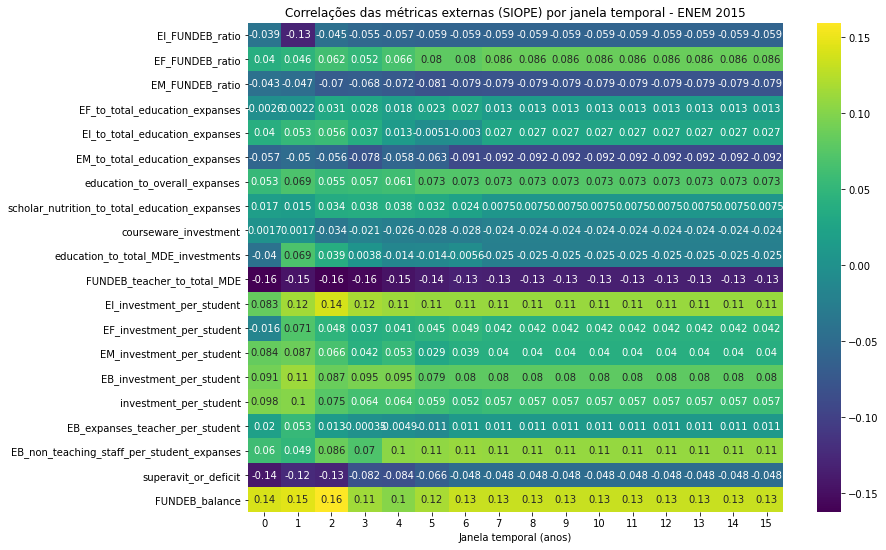

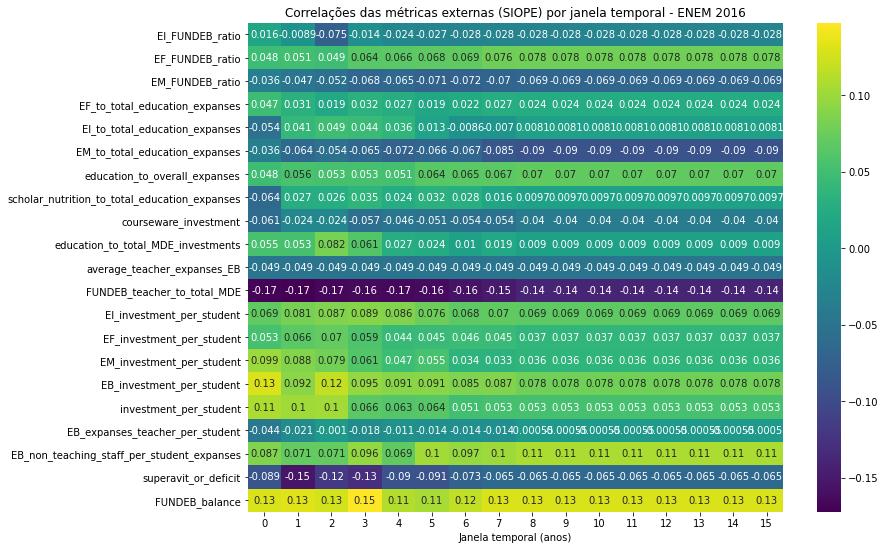

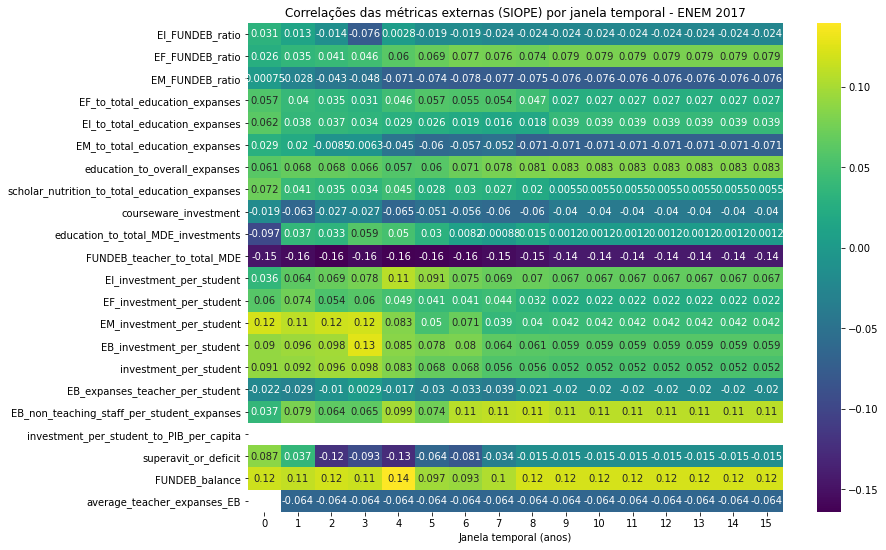

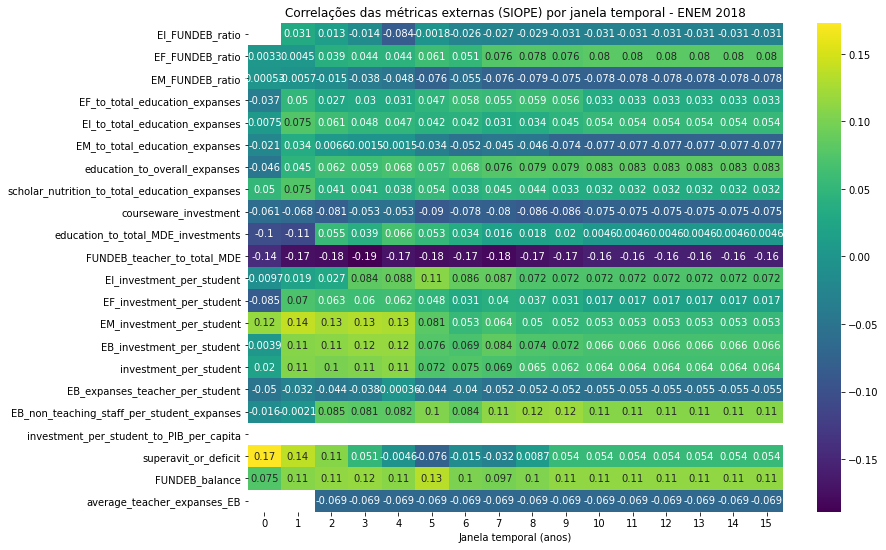

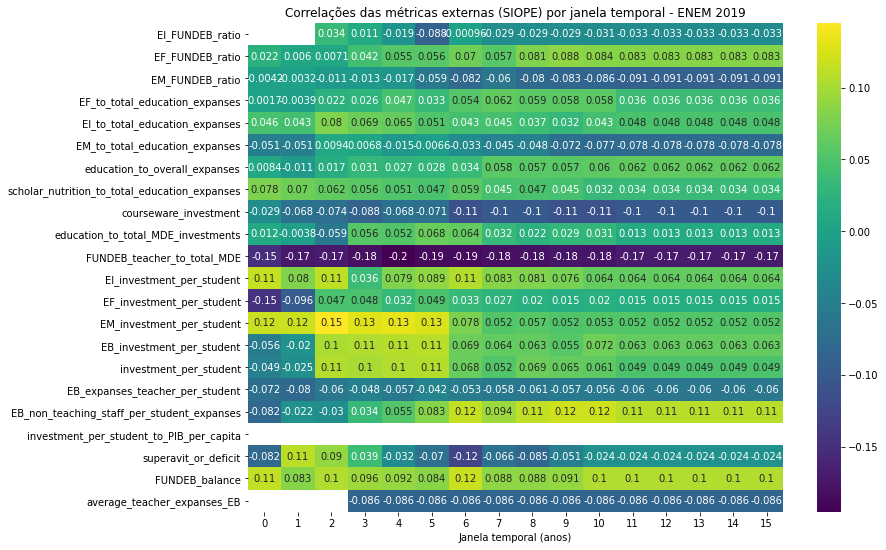

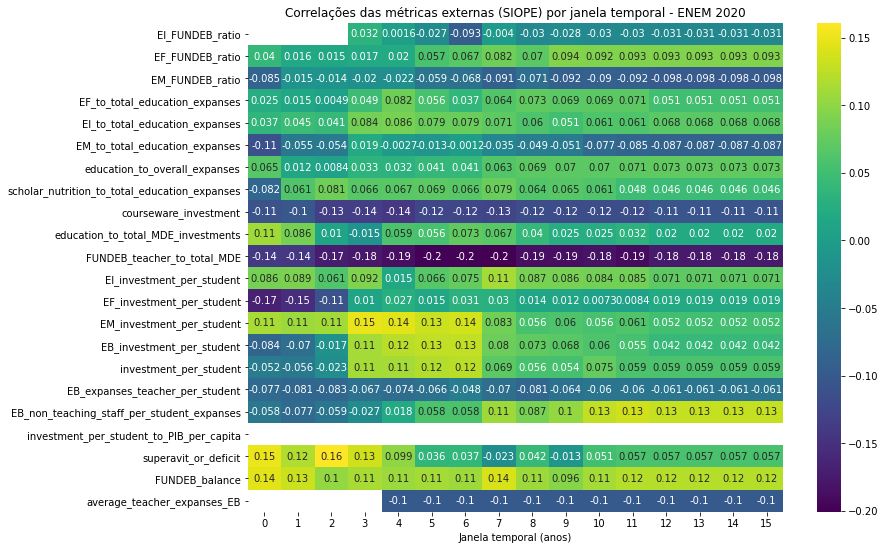

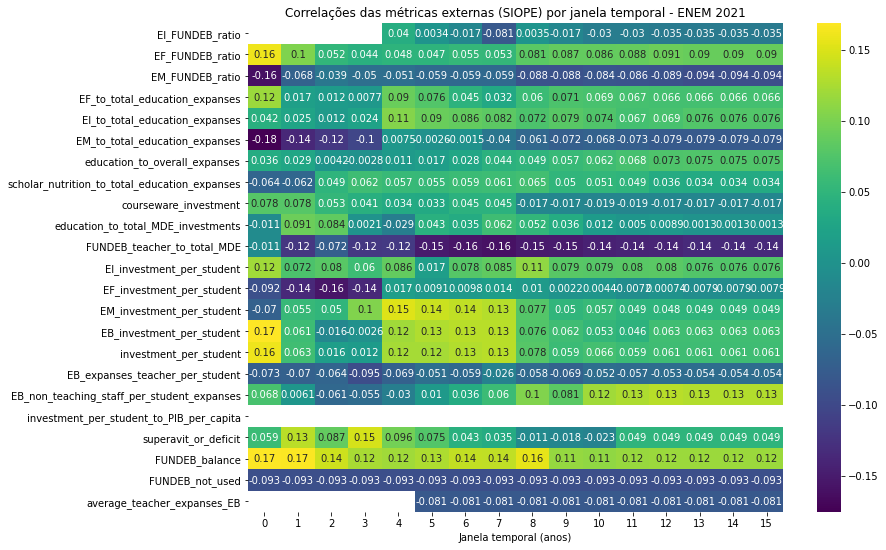

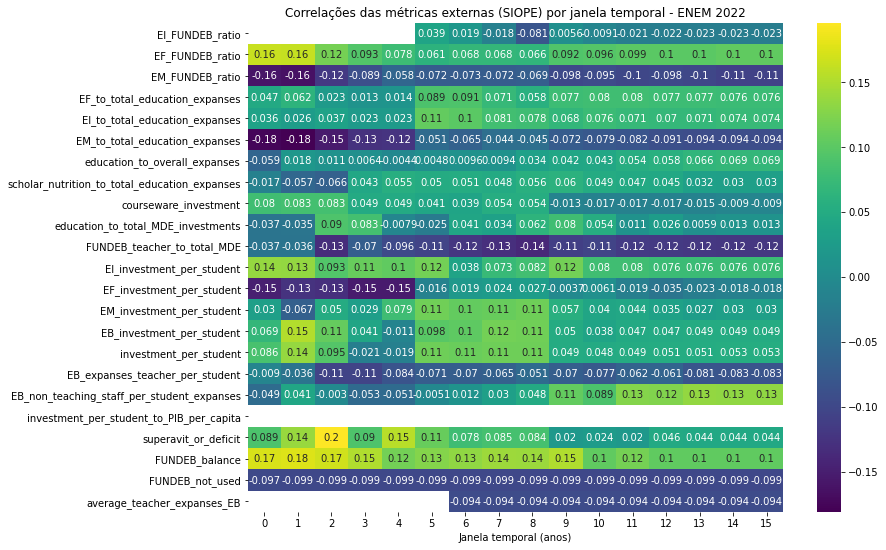

In [33]:
for year in years_to_analyze:
    R_ext = joblib.load(f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_v3.pkl")
    R_ext = reformat_external_siope_correlations(R_ext)
    R_ext.drop(columns = ["window", "Average score", "Natural Sciences score"], inplace = True)

    plt.figure(figsize = (12,9))
    sns.heatmap(R_ext.transpose(),
    cmap = 'viridis',
    annot = True)
    plt.xlabel("Janela temporal (anos)")
    plt.title(f"Correlações das métricas externas (SIOPE) por janela temporal - ENEM {year}")
    plt.show()

In [13]:
metrics_to_use = ["EI_FUNDEB_ratio", "EF_FUNDEB_ratio", "EM_FUNDEB_ratio", "EF_to_total_education_expanses", "EI_to_total_education_expanses",
                  "EM_to_total_education_expanses", "education_to_overall_expanses", "scholar_nutrition_to_total_education_expanses",
                  "courseware_investment", "education_to_total_MDE_investments", "FUNDEB_teacher_to_total_MDE", "EI_investiment_per_student",
                  "EF_investment_per_student", "EB_investment_per_student", "EB_investment_per_student", "investment_per_student",
                  "EB_expanses_teacher_per_student", "EB_non_teaching_staff_per_student_expanses", "superavit_or_deficit", "FUNDEB_balance",
                  "FUNDEB_not_used", "avereage_teacher_expanses_EB"]

In [15]:
years_to_analyze

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [30]:
siope_corr_df = pd.DataFrame()
for year in years_to_analyze:
    R_ext = joblib.load(f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_v3.pkl")
    R_ext["year"] = year

    siope_corr_df = pd.concat([siope_corr_df, R_ext], axis = 0)

In [31]:
siope_corr_df = siope_corr_df.reset_index().rename(columns = {"index": "metric"})

###### Each metric as a figure

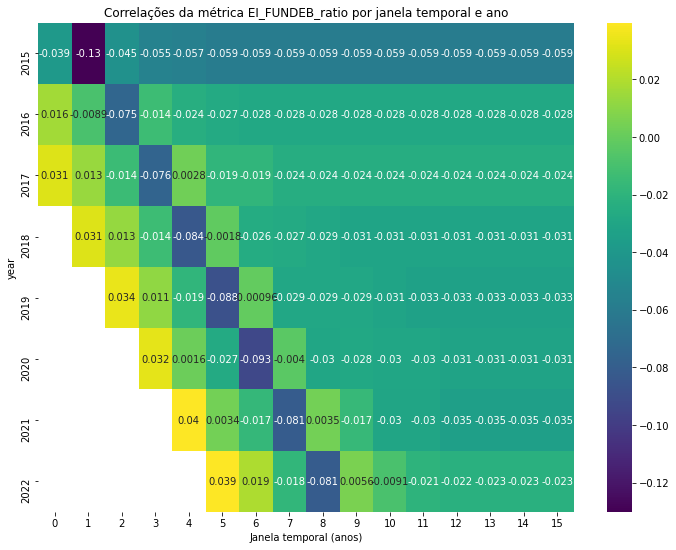

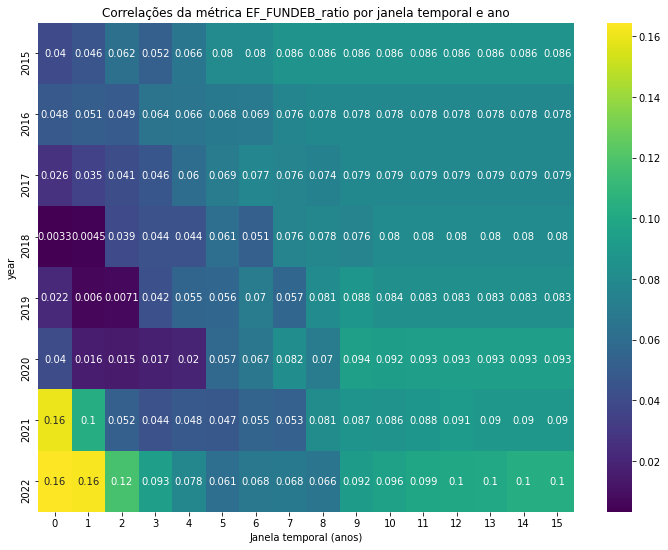

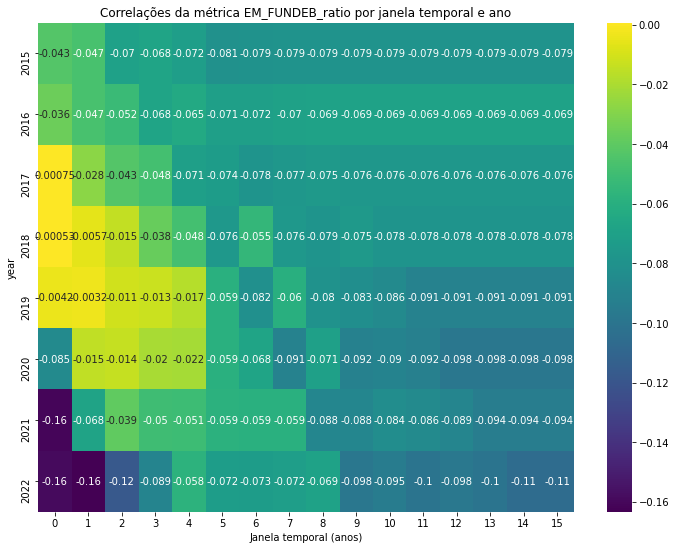

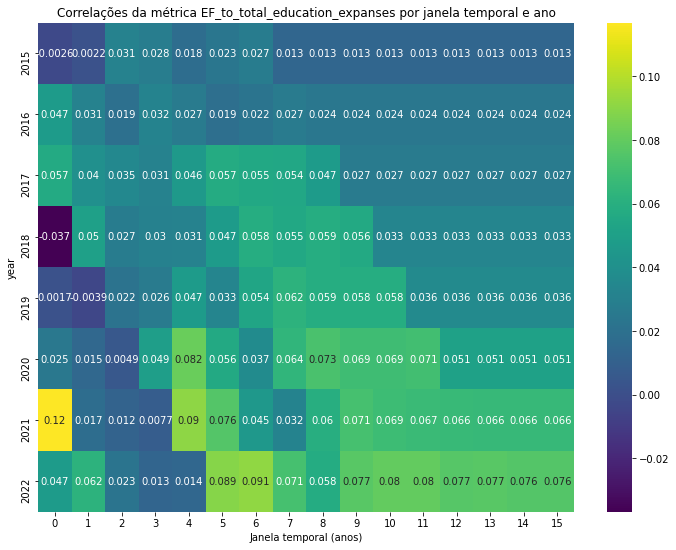

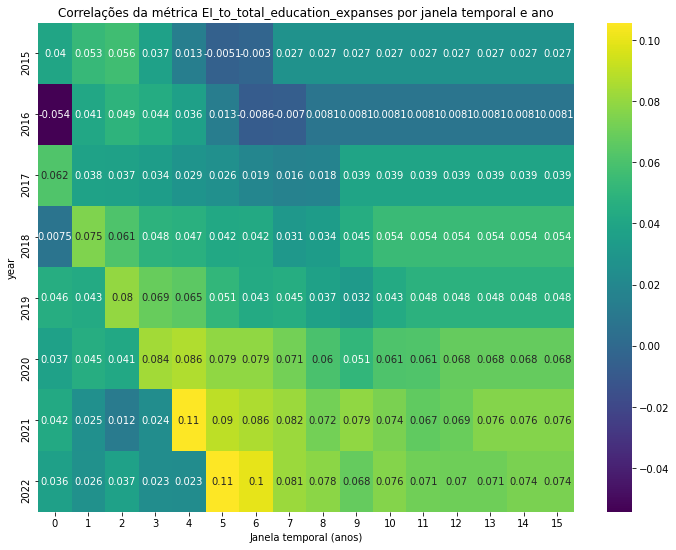

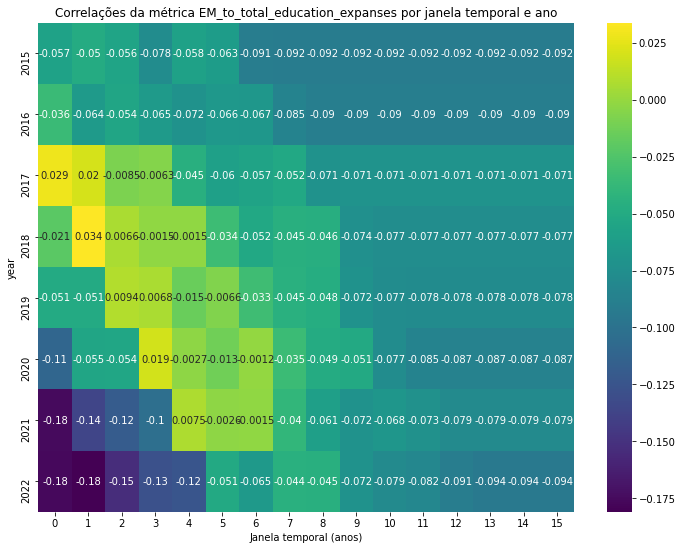

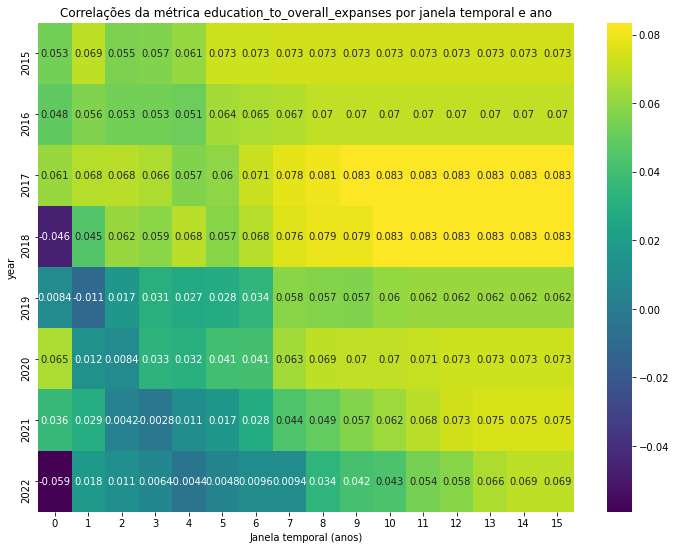

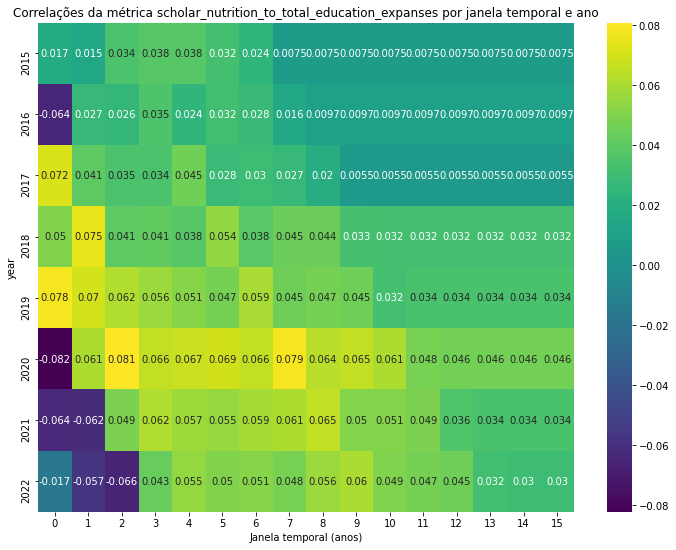

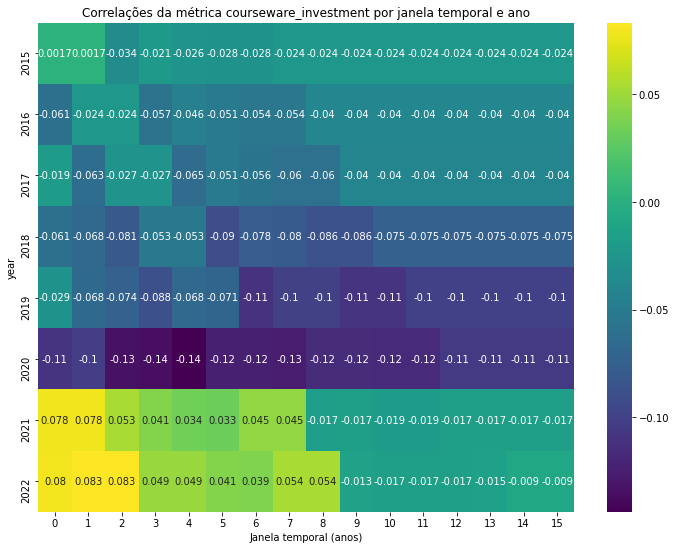

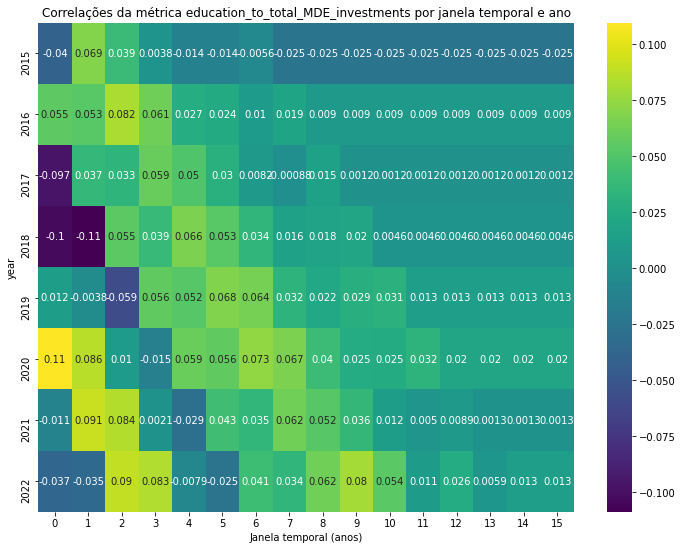

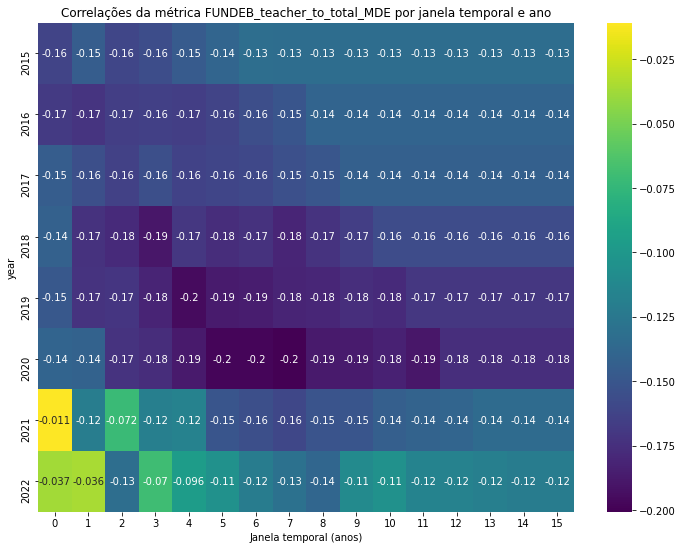

Couldn't plot for EI_investiment_per_student


<Figure size 864x648 with 0 Axes>

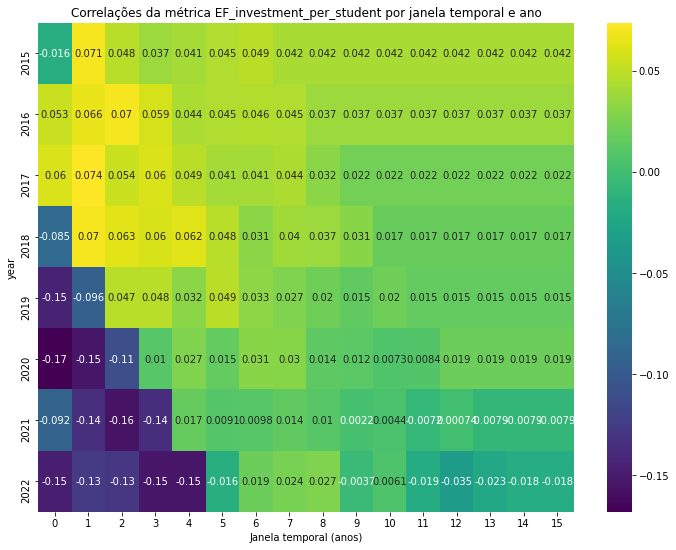

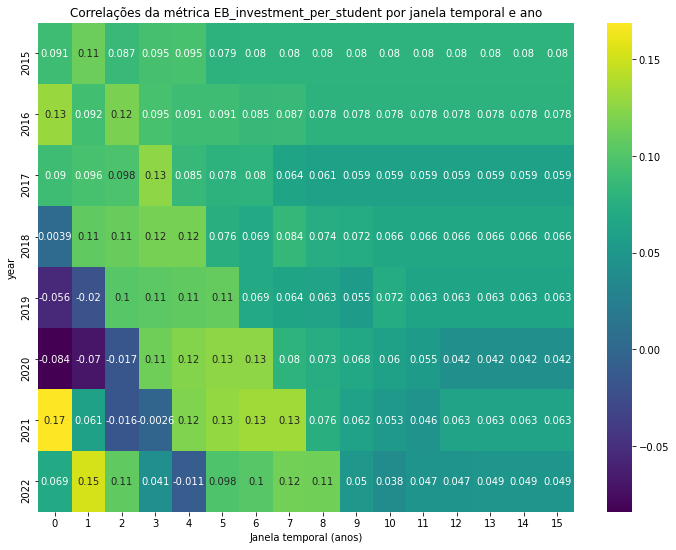

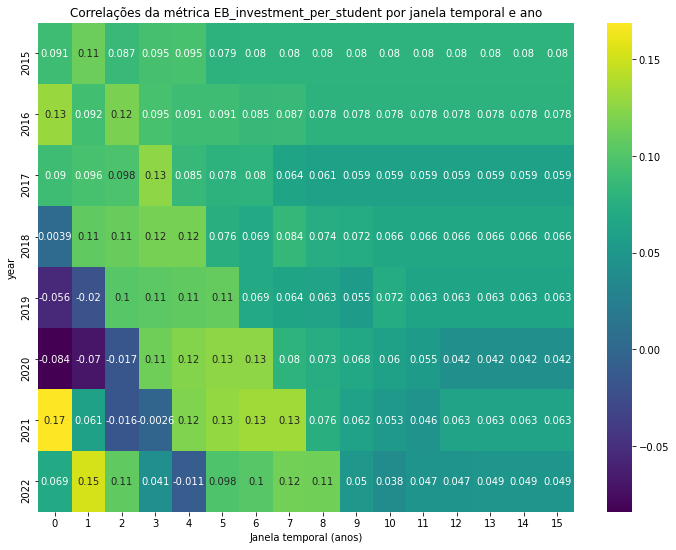

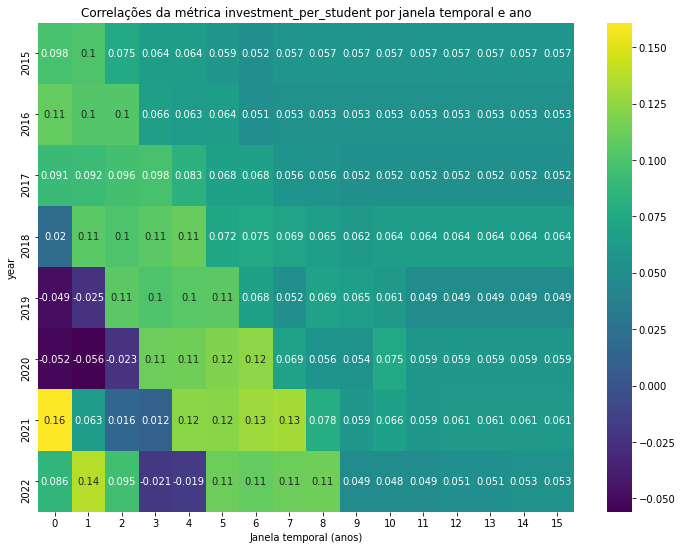

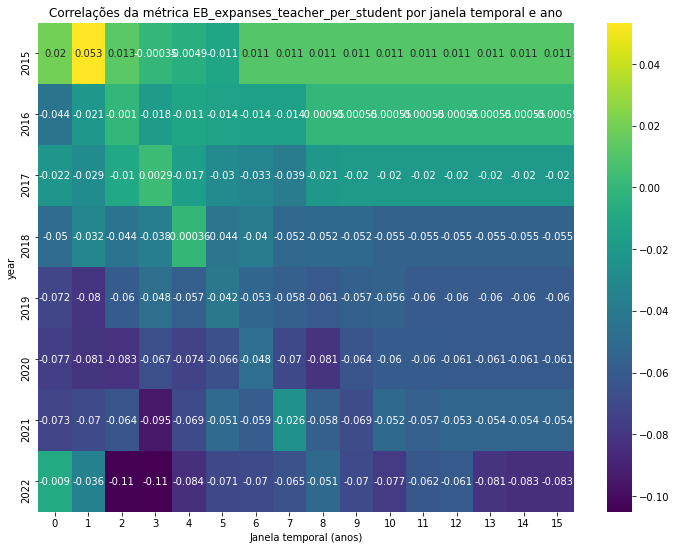

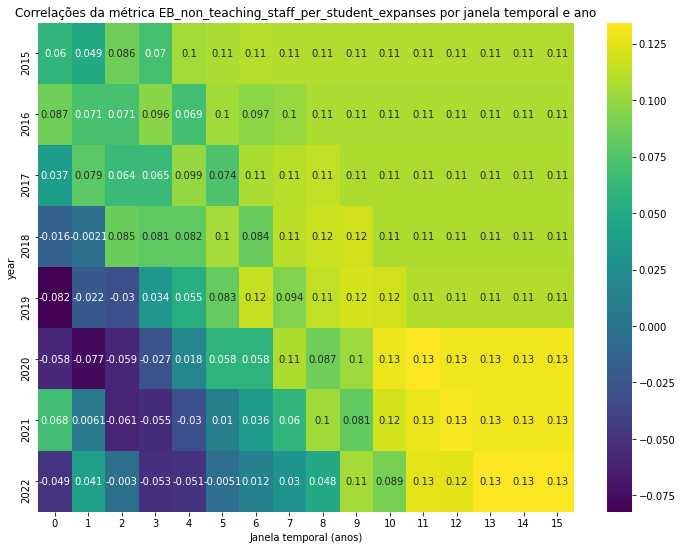

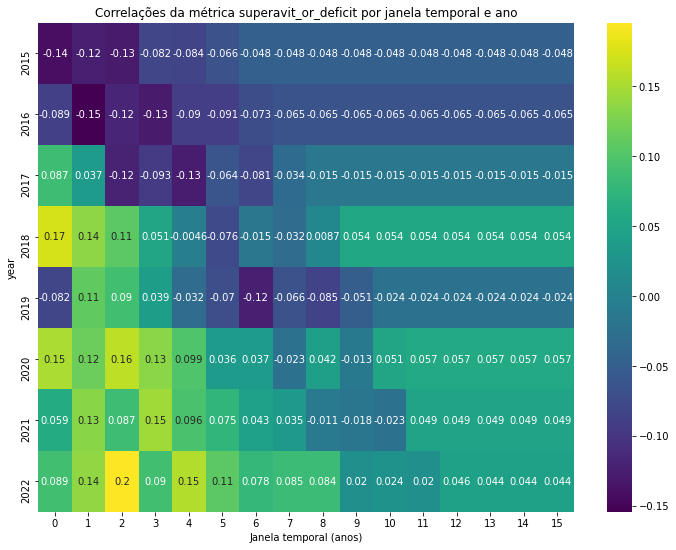

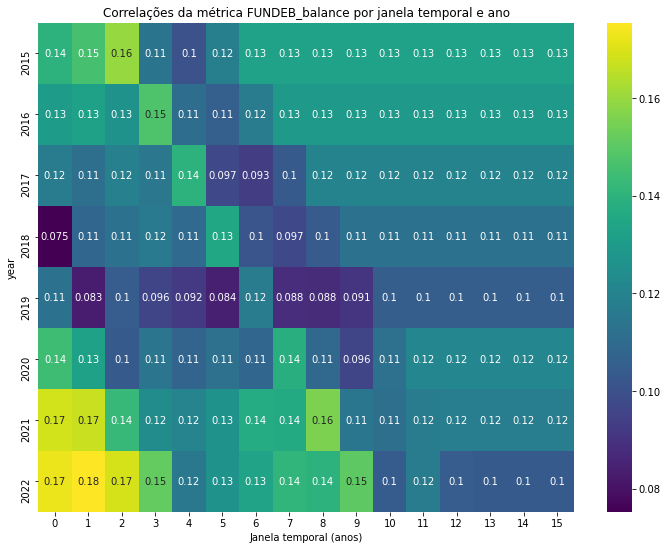

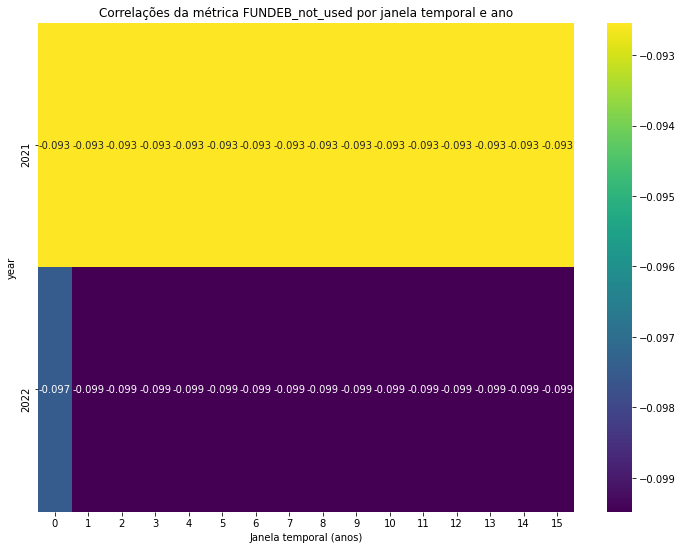

Couldn't plot for avereage_teacher_expanses_EB


<Figure size 864x648 with 0 Axes>

In [32]:
for metric in metrics_to_use:
    plt.figure(figsize = (12,9))
    df = siope_corr_df[siope_corr_df["metric"] == metric]
    try:
        sns.heatmap(df.pivot(columns = "window", index = "year", values = "Average score"), annot = True, cmap = 'viridis')
        plt.xlabel("Janela temporal (anos)")
        plt.title(f"Correlações da métrica {metric} por janela temporal e ano")
        plt.show()
    except:
        print(f"Couldn't plot for {metric}")

In [37]:
siope_dict_pt = {
    'superavit_or_deficit': "Superávit/Déficit da UF",
    "investment_per_student": "Investimento por estudante",
    "FUNDEB_balance": "Saldo financeiro do FUNDEB",
    "EB_expanses_teacher_per_student": "Despesa com professores por aluno da EB",
    "EB_non_teaching_staff_per_student_expanses": "Despesa com pessoal não docente por aluno da EB",
    "education_to_overall_expanses": "Fração de despesas com Educação"
}

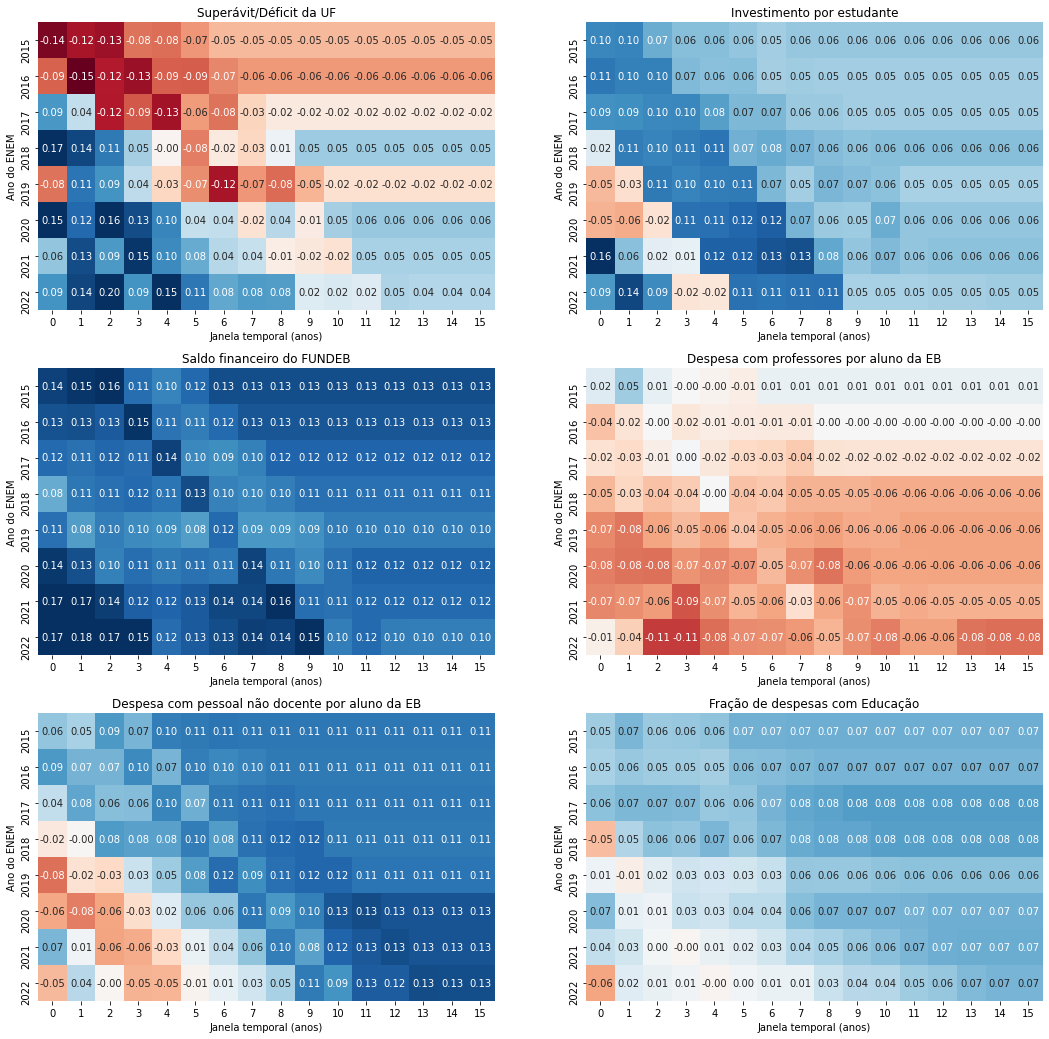

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

In [38]:
metrics_to_plot = ["superavit_or_deficit", "investment_per_student", "FUNDEB_balance", "EB_expanses_teacher_per_student", "EB_non_teaching_staff_per_student_expanses", "education_to_overall_expanses"]
fig, ax = plt.subplots(3,2, figsize = (18,18))
ax = np.reshape(ax, (1,6))

#plt.suptitle("Correlações entre indicadores orçamentários educacionais e desempenho médio no ENEM")

i = 0
for metric in metrics_to_plot:
    plt.figure(figsize = (12,9))
    df = siope_corr_df[siope_corr_df["metric"] == metric]
    # try:
    sns.heatmap(df.pivot(columns = "window", index = "year", values = "Average score"),
                    annot = True,
                    cmap = 'RdBu',
                    ax = ax[0,i],
                    cbar = False,
                    fmt = '.2f',
                    vmin = -0.15,
                    vmax = 0.15
                    )
    ax[0,i].set_xlabel("Janela temporal (anos)")
    ax[0,i].set_ylabel("Ano do ENEM")
    ax[0,i].set_title(f"{siope_dict_pt[metric]}")
    # except:
    #     print(f"Couldn't plot for {metric}")
    i += 1

plt.tight_layout()

In [40]:
siope_df["Region"] = siope_df["UF"].apply(lambda x:
                                    'Norte' if x in ["AC", "AM", "AP", "RO", "RR", "PA", "TO"]
                                    else 'Nordeste' if x in["MA", "PI", "BA", "CE", "PB", "RN", "PE", "AL", "SE"]
                                    else "Centro-Oeste" if x in ["MT", "GO", "DF", "MS"]
                                    else "Sudeste" if x in ["SP", "RJ", "MG", "ES"]
                                    else "Sul" if x in ["PR", "SC", "RS"]
                                    else "Nada")

In [214]:
siope_df[siope_df["metric_description"] == metric].groupby(["year","Region"])["metric_value"].mean().unstack()

Region  Centro-Oeste   Nordeste      Norte    Sudeste        Sul
year                                                            
2008       20.027500  14.746667  18.295714  14.017500  20.953333
2009       20.122500  14.914444  16.734286  13.355000  21.883333
2010       20.170000  15.214444  16.908000  13.950000  21.650000
2011       19.382500  16.923333  17.792857  14.005000  21.780000
2012       19.730000  16.172222  16.271429  14.165000  20.680000
2013       18.352500  14.852222  16.521429  14.142500  20.290000
2014       22.457500  15.443750  16.521429  13.836667  21.075000
2015       19.187500  14.642500  18.687143  13.950000  18.735000
2016       18.262500  14.853750  18.345714  14.360000  20.100000
2017       17.997500  14.550000  18.104286  13.946667  27.350000
2018       18.596667  15.016250  20.731429  13.100000  22.300000
2019       17.680000  16.626250  19.034286  14.373333  19.950000
2020       16.343333  14.758571  17.542857  13.980000  20.905000
2021       17.496667  17.515714  17.591429  13.880000  29.080000
2022       15.813333  17.130000  20.145714  14.155000  29.895000

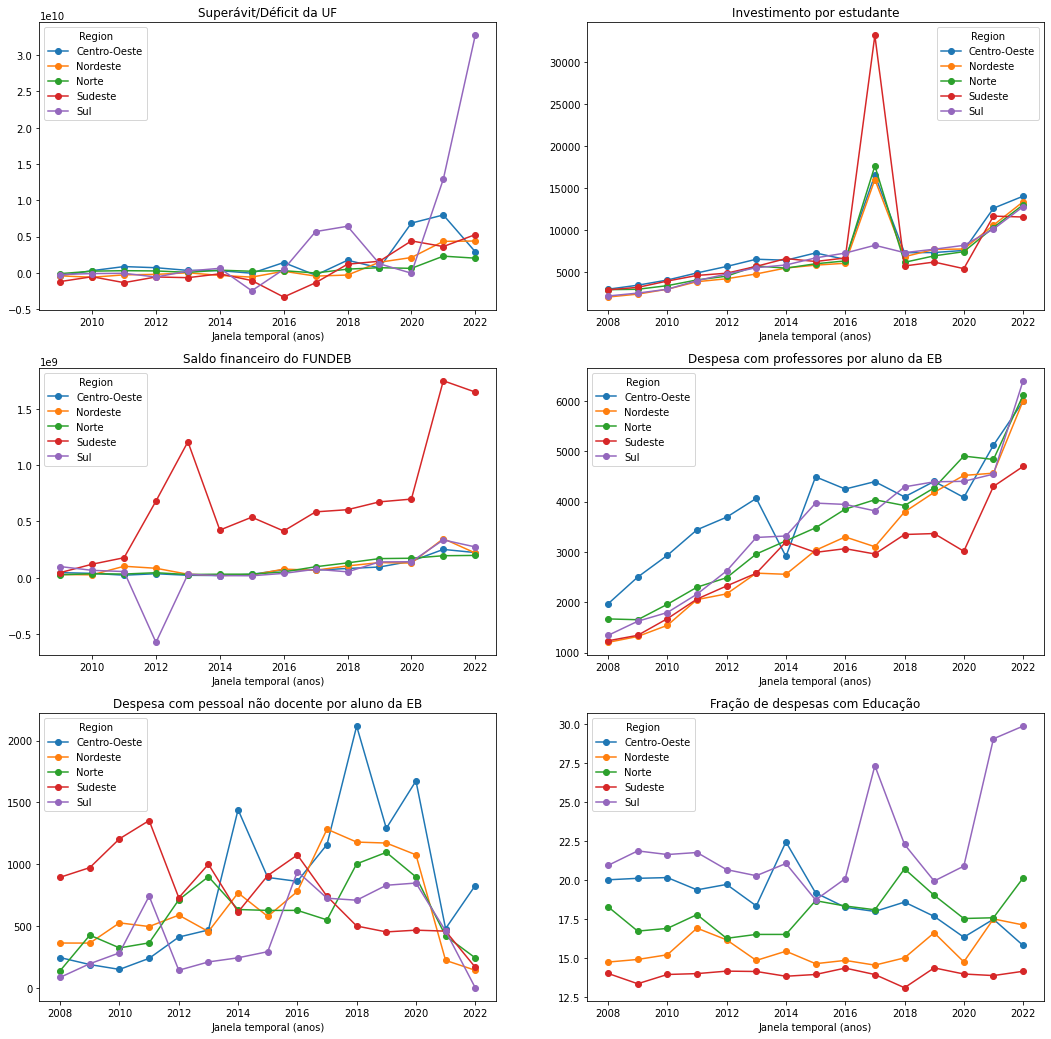

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

In [41]:
metrics_to_plot = ["superavit_or_deficit", "investment_per_student", "FUNDEB_balance", "EB_expanses_teacher_per_student", "EB_non_teaching_staff_per_student_expanses", "education_to_overall_expanses"]
fig, ax = plt.subplots(3,2, figsize = (18,18))
ax = np.reshape(ax, (1,6))

#plt.suptitle("Correlações entre indicadores orçamentários educacionais e desempenho médio no ENEM")

i = 0
for metric in metrics_to_plot:
    plt.figure(figsize = (12,9))

    siope_df[siope_df["metric_description"] == metric].groupby(["year","Region"])["metric_value"].mean().unstack().plot(marker = 'o',
                                                                                                                                    ax = ax[0,i])

    ax[0,i].set_xlabel("Janela temporal (anos)")
    ax[0,i].set_ylabel("")
    ax[0,i].set_title(f"{siope_dict_pt[metric]}")
    i += 1

plt.tight_layout()

In [17]:
enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")

In [22]:
x = enem_df.groupby(["UF", "ENEM_year"])["Average score"].mean().unstack()
x["ENEM_year"] = 2022

In [23]:
x

ENEM_year        2022  ENEM_year
UF                              
AC         500.941579       2022
AL         512.743883       2022
AM         492.254220       2022
AP         495.929105       2022
BA         519.265226       2022
CE         498.527925       2022
DF         541.336009       2022
ES         536.361601       2022
GO         520.060609       2022
MA         493.138612       2022
MG         550.237539       2022
MS         522.928453       2022
MT         515.108975       2022
PA         500.616448       2022
PB         515.831051       2022
PE         521.584773       2022
PI         513.005297       2022
PR         535.984980       2022
RJ         542.709208       2022
RN         527.648552       2022
RO         502.833553       2022
RR         514.555936       2022
RS         539.186444       2022
SC         543.311559       2022
SE         515.966445       2022
SP         544.318620       2022
TO         502.237260       2022

In [25]:
grouped_siope_df

metric_description  EB_expanses_teacher_per_student  \
UF                                                    
AC                                          5697.53   
AM                                          4189.81   
AP                                          7586.02   
BA                                          5189.21   
CE                                          6525.66   
ES                                          3728.34   
GO                                          4936.79   
MA                                          5683.77   
MS                                          6420.61   
MT                                          6615.72   
PA                                          6058.88   
PB                                          6310.62   
PE                                          5634.89   
PI                                          5563.17   
PR                                          6883.06   
RO                                          5387.84   
RR                                          7433.23   
SC                                          5919.57   
SE                                          7110.81   
SP                                          5667.77   
TO                                          6433.40   

metric_description  EB_investment_per_student  \
UF                                              
AC                                   14949.16   
AM                                   11094.61   
AP                                   14946.68   
BA                                   16043.05   
CE                                   15696.78   
ES                                    9705.21   
GO                                   12205.79   
MA                                   13296.03   
MS                                   17595.56   
MT                                   13920.42   
PA                                   10514.01   
PB                                   16374.27   
PE                                   13973.60   
PI                                   15270.90   
PR                                   14218.80   
RO                                   11634.82   
RR                                   15009.61   
SC                                   14007.18   
SE                                   13426.85   
SP                                   15431.09   
TO                                   14496.05   

metric_description  EB_non_teaching_staff_per_student_expanses  \
UF                                                               
AC                                                        0.00   
AM                                                       91.46   
AP                                                        0.00   
BA                                                        0.00   
CE                                                        0.00   
ES                                                      331.45   
GO                                                      715.74   
MA                                                        0.00   
MS                                                     1169.76   
MT                                                      595.31   
PA                                                        0.00   
PB                                                        0.00   
PE                                                        0.00   
PI                                                      988.37   
PR                                                        0.00   
RO                                                      688.29   
RR                                                      825.08   
SC                                                        0.00   
SE                                                        0.00   
SP                                                        0.00   
TO                                                       85.44   

metric_description  EF_FUNDEB_ratio  EF_investment_per_student  \
UF                   

In [38]:
n = np.arange(0,16)
siope_and_enem_scores_df = pd.DataFrame()

for year in years_to_analyze:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df = enem_df.groupby(["UF", "ENEM_year"])["Average score"].mean().unstack()

    for window in n:
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df['year'] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()
        grouped_siope_df["window"] = window

        siope_data_with_scores_df = grouped_siope_df.merge(enem_df, on = ["UF"], how = 'left')

        siope_and_enem_scores_df = pd.concat([siope_and_enem_scores_df, siope_data_with_scores_df], axis = 0)

        del siope_data_with_scores_df
    del enem_df

Running analysis for ENEM 2015
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s)
Running for the last 14 year(s)
Running for the last 15 year(s)
Running analysis for ENEM 2016
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s

In [51]:
siope_and_enem_scores_df

EB_expanses_teacher_per_student  EB_investment_per_student  \
UF                                                               
AC                      3917.130000                5798.230000   
AM                      2491.270000                4824.880000   
AP                      3813.820000                7235.230000   
BA                      3044.780000                5151.160000   
CE                      2810.690000                5450.060000   
..                              ...                        ...   
RS                      1746.614000                3271.778000   
SC                      3223.777333                5343.191333   
SE                      3707.605333                6173.620000   
SP                      2809.122000                8572.593333   
TO                      4124.467333                6504.285333   

    EB_non_teaching_staff_per_student_expanses  EF_FUNDEB_ratio  \
UF                                                                
AC                                    6.880000        79.000000   
AM                                  226.670000        82.280000   
AP                                 1761.270000        74.980000   
BA                                  113.530000        31.550000   
CE                                  807.250000        12.770000   
..                                         ...              ...   
RS                                  788.528000        65.604000   
SC                                  129.644000        67.723333   
SE                                 1001.064000        45.096667   
SP                                 1092.695333        57.009333   
TO                                  519.125333        64.540000   

    EF_investment_per_student  EF_to_total_education_expanses  \
UF                                                              
AC                5698.600000                       64.930000   
AM                6795.190000                       72.710000   
AP                9462.140000                       78.720000   
BA                5086.010000                       22.760000   
CE                3838.290000                        7.200000   
..                        ...                             ...   
RS                3783.262000                       62.416000   
SC                5330.933333                       43.820000   
SE                4453.403333                       36.163333   
SP                5595.066000                       40.095333   
TO                6765.227333                       60.030667   

    EI_FUNDEB_ratio  EI_investment_per_student  \
UF                                               
AC         0.160000               13976.530000   
AM         0.000000               15576.280000   
AP         0.000000                1590.100000   
BA         0.020000                4385.060000   
CE         0.040000                9612.140000   
..              ...                        ...   
RS         0.000000                 858.292000   
SC         0.080000              152577.490000   
SE         0.001333                 528.954667   
SP         0.008000               14624.493333   
TO         0.001333                 156.628000   

    EI_to_total_education_expanses  EM_FUNDEB_ratio  ...  \
UF                                                   ...   
AC                        1.110000        20.890000  ...   
AM                        0.000000        19.350000  ...   
AP                        0.040000        25.430000  ...   
BA                        0.050000        69.090000  ...   
CE                        0.320000        86.530000  ...   
..                             ...              ...  ...   
RS                        0.352000        28.450000  ...   
SC                        0.620000        31.044000  ...   
SE                        0.134667        52.612000  ...   
SP                        4.748667        41.254000  ...   
TO                        0.012667        34.025333  ...

In [52]:
# relações
df = joblib.load("ENEM_preprocessed_2020_based_on_SG_UF_PROVA.pkl")

In [67]:
enem_scores = df.groupby(["UF"])["Average score"].mean().reset_index()
metric_values = siope_df[(siope_df["metric_description"] == 'investment_per_student') & (siope_df["year"] >= 2008) & (siope_df["year"] <= 2020)].groupby("UF")["metric_value"].mean().reset_index()

dg = metric_values.merge(enem_scores, on = "UF", how = 'inner')

In [89]:
df_test\
    .sort_values(by = ["year"])\
    .groupby("UF")\
    ["metric_value"]\
    .shift(1)

15           NaN
6604         NaN
913          NaN
6298         NaN
6200         NaN
          ...   
2706     9970.19
6178     9426.00
1198     9487.90
278      9891.18
5019    10824.87
Name: metric_value, Length: 364, dtype: float64

In [124]:
ipca = pd.DataFrame({'year': [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                     'ipca': [0.059, 0.0431, 0.0591, 0.065, 0.0584, 0.0591, 0.0641, 0.1067, 0.0629, 0.0295, 0.0375, 0.0431, 0.0452, 0.1006, 0.0579, 0.0299]})

In [125]:
ipca

year    ipca
0   2007  0.0590
1   2008  0.0431
2   2009  0.0591
3   2010  0.0650
4   2011  0.0584
5   2012  0.0591
6   2013  0.0641
7   2014  0.1067
8   2015  0.0629
9   2016  0.0295
10  2017  0.0375
11  2018  0.0431
12  2019  0.0452
13  2020  0.1006
14  2021  0.0579
15  2022  0.0299

In [126]:
siope_df_2 = siope_df.merge(ipca, on = 'year', how = 'inner')

In [127]:
siope_df_2

year metric_code  metric_value  UF  \
0     2008         2.1  0.000000e+00  RO   
1     2008        4.11  6.250000e+01  RO   
2     2008         2.3  0.000000e+00  RO   
3     2008         2.4  0.000000e+00  RO   
4     2008         2.5  7.836000e+01  RO   
...    ...         ...           ...  ..   
7393  2010         4.9  5.267750e+03  DF   
7394  2010        4.10  4.615200e+03  DF   
7395  2010        4.11  1.458800e+02  DF   
7396  2010         7.1  1.871715e+09  DF   
7397  2010         2.2  8.752000e+01  DF   

                              metric_description        Region    ipca  
0                                EI_FUNDEB_ratio         Norte  0.0431  
1     EB_non_teaching_staff_per_student_expanses         Norte  0.0431  
2                                EM_FUNDEB_ratio         Norte  0.0431  
3                 EI_to_total_education_expanses         Norte  0.0431  
4                 EF_to_total_education_expanses         Norte  0.0431  
...                                          ...           ...     ...  
7393                      investment_per_student  Centro-Oeste  0.0650  
7394             EB_expanses_teacher_per_student  Centro-Oeste  0.0650  
7395  EB_non_teaching_staff_per_student_expanses  Centro-Oeste  0.0650  
7396                        superavit_or_deficit  Centro-Oeste  0.0650  
7397                             EF_FUNDEB_ratio  Centro-Oeste  0.0650  

[7398 rows x 7 columns]

In [128]:
df_test = siope_df_2[siope_df_2["metric_description"] == "investment_per_student"]
df_test["previous_year_metric"] = df_test\
    .sort_values(by = ["year"])\
    .groupby("UF")\
    ["metric_value"]\
    .shift(1)

df_test["corrected_metric"] = ((1 + (df_test["metric_value"]/df_test["previous_year_metric"]))/(1 + df_test["ipca"]))

<ipython-input-128-72293e3ebde5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["previous_year_metric"] = df_test\
<ipython-input-128-72293e3ebde5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["corrected_metric"] = ((1 + (df_test["metric_value"]/df_test["previous_year_metric"]))/(1 + df_test["ipca"]))


In [129]:
df_test

year metric_code  metric_value  UF      metric_description  \
15    2008         4.9       2257.50  RO  investment_per_student   
33    2008         4.9       3221.30  AC  investment_per_student   
51    2008         4.9       2728.37  AM  investment_per_student   
69    2008         4.9       4390.40  RR  investment_per_student   
87    2008         4.9       1556.13  PA  investment_per_student   
...    ...         ...           ...  ..                     ...   
7313  2010         4.9       2688.60  RS  investment_per_student   
7333  2010         4.9       4452.53  MS  investment_per_student   
7353  2010         4.9       2973.39  MT  investment_per_student   
7373  2010         4.9       3647.82  GO  investment_per_student   
7393  2010         4.9       5267.75  DF  investment_per_student   

            Region    ipca  previous_year_metric  corrected_metric  
15           Norte  0.0431                   NaN               NaN  
33           Norte  0.0431                   NaN               NaN  
51           Norte  0.0431                   NaN               NaN  
69           Norte  0.0431                   NaN               NaN  
87           Norte  0.0431                   NaN               NaN  
...            ...     ...                   ...               ...  
7313           Sul  0.0650               2364.66          2.006565  
7333  Centro-Oeste  0.0650               3781.45          2.044569  
7353  Centro-Oeste  0.0650               2538.27          2.038896  
7373  Centro-Oeste  0.0650               2734.12          2.191722  
7393  Centro-Oeste  0.0650               4818.67          1.965442  

[364 rows x 9 columns]

In [76]:
siope_df[siope_df["metric_description"] == 'investment_per_student']\
    .groupby(["year", "UF"])\
    ["metric_value"]\
    .mean().unstack()

UF          AC       AL        AM        AP        BA        CE       DF  \
year                                                                       
2008   3221.30  2170.32   2728.37   3556.54   2027.62   2183.13  3926.27   
2009   3289.72  2130.27   1884.01   3732.21   2273.93   3063.56  4818.67   
2010   3866.43  2919.09   2833.59       NaN   2928.35   3787.39  5267.75   
2011   4301.40  3247.86   3243.91   4855.60   3725.96   5473.82  7038.25   
2012   4639.77  4447.79   3673.89   5977.64   4212.74   5019.47  6749.84   
2013   7135.79  3356.06   4669.41   7425.63   4940.43   5667.66  7794.34   
2014   6278.82      NaN   4743.77   6188.10   5704.60   6338.86  7710.55   
2015   5783.22      NaN   5141.91   7186.00   6483.36   6287.46  9216.96   
2016   6137.27      NaN   5005.76   8034.23   6356.75   6634.55  6597.23   
2017  11663.73      NaN   5121.40  43035.57  10219.74   7430.68  8465.67   
2018   5445.62      NaN   4886.80   8882.74   6255.49   8484.54      NaN   
2019   6054.18      NaN   5712.34   9258.10   7736.69   8983.98      NaN   
2020   6336.08      NaN   6001.81  10108.34   7690.10   8859.24      NaN   
2021  11298.35      NaN   9070.76  12006.78  10364.05  12291.72      NaN   
2022  14837.00      NaN  10856.83  14700.58  14345.56  12971.03      NaN   

UF          ES        GO        MA  ...        PR        RJ       RN  \
year                                ...                                
2008   3109.16   2502.84   2032.84  ...   2609.46   2711.64  2464.22   
2009   3697.95   2734.12   2204.43  ...   2886.97   2953.82  2396.03   
2010   4957.63   3647.82   2566.55  ...   3318.06   3454.28  2806.64   
2011   5295.83   3862.24   3423.20  ...   4064.32   4073.61  4221.71   
2012   5719.89   4958.13   4151.33  ...   4711.70   3642.99  4345.34   
2013   6380.10   5579.17   5777.93  ...   6309.57   4569.89  4284.69   
2014   7433.74   5616.33   5834.54  ...   6592.64   5885.76  4772.76   
2015   6783.52   6390.87   6207.52  ...   7724.75   4531.85  5657.89   
2016   6722.48   6252.55   6337.56  ...   8827.49   5473.19  6355.66   
2017   7290.91   5745.90  54910.44  ...  10418.56  41091.69  5830.74   
2018   4641.80   7238.58   8273.57  ...   8491.66   6242.69  6361.74   
2019   5284.31   7492.08   8255.41  ...   8507.75   6267.47  7175.85   
2020   4578.68   6840.09   9240.16  ...   8979.57       NaN      NaN   
2021  10824.87  11726.38  10122.30  ...  10853.09       NaN      NaN   
2022   9494.99  12074.60  12313.79  ...  13341.48       NaN      NaN   

UF          RO        RR       RS        SC        SE        SP        TO  
year                                                                       
2008   2257.50   4390.40  1567.58   2382.27   2398.13   3357.53   2861.18  
2009   2408.12   4448.47  2364.66   2342.14   3109.37   3709.22   2990.36  
2010       NaN   4431.70  2688.60   2959.20   3954.38   4453.23   3263.02  
2011   3604.77   5249.45  4460.61   3526.17   4445.79   5211.33   4082.82  
2012   3890.64   5450.64  5169.91   4506.12   4650.76   5704.65   4739.40  
2013   4536.63   7753.91      NaN   4794.69   5220.12   6810.51   5277.19  
2014   5188.79   6969.57      NaN   5156.12   5502.29   6580.41   5119.20  
2015   5398.02   8377.59      NaN   5711.04   5890.04   7556.07   5926.50  
2016   6017.13   8585.17      NaN   5753.92   6328.17   7926.22   6724.96  
2017  41441.86   9995.70      NaN   6015.94   6409.19  51142.92   6853.88  
2018   5612.58   6707.69      NaN   6197.69   7038.11   6383.79   7651.91  
2019   6466.01   8388.91      NaN   6988.27   7603.90   7114.21   8202.91  
2020   7059.91   8468.72      NaN   7437.24   7827.91   6300.09   8897.42  
2021   9891.18   9487.90      NaN   9426.00   8527.13  12548.86  11908.93  
2022  11621.95  14540.35      NaN  12286.96  13291.76  13663.72  14281.91  

[15 rows x 27 columns]

Text(6000, 530, 'y = -0.0014*x + 524.8222\n r = -0.11 \n p = 0.57 \n se = 0.0')

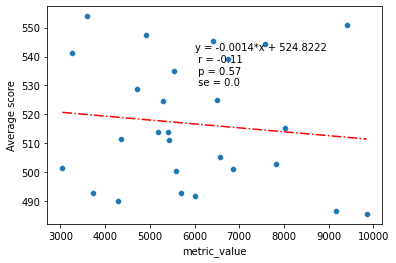

In [68]:
sns.scatterplot(data = dg,
                x = "metric_value",
                y = "Average score")

a, b, r, p, se = linregress(dg["metric_value"], dg["Average score"])

#popt, pcov = curve_fit(lambda x,a,b: a + b*np.log(x), dg[dg["metric_value"] > 0]["metric_value"], dg[dg["metric_value"] > 0]["Average score"])

x = np.linspace(dg["metric_value"].min(), dg["metric_value"].max())
# y = popt[1]*np.log(x) + popt[0]
y = a*x + b

plt.plot(x,y, '-.r')

plt.text(x = 6000, y = 530, s = f"y = {np.round(a,4)}*x + {np.round(b,4)}\n r = {np.round(r,2)} \n p = {np.round(p,2)} \n se = {np.round(se,2)}")


<AxesSubplot: xlabel='year'>

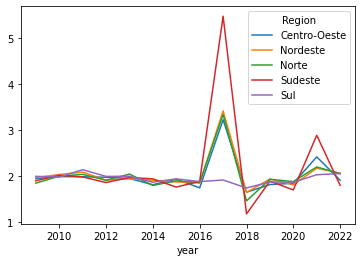

In [98]:
df_test.groupby(["year", "Region"])["corrected_metric"].mean().unstack().plot()

In [112]:
df2 = joblib.load("ENEM_preprocessed_2020_based_on_SG_UF_PROVA.pkl")
df1 = joblib.load("ENEM_preprocessed_2015_based_on_SG_UF_PROVA.pkl")

In [138]:
# enem_scores = (df2.groupby(["UF"])["Average score"].mean() - df1.groupby(["UF"])["Average score"].mean())/df1.groupby(["UF"])["Average score"].mean()
# enem_scores = enem_scores.reset_index()

enem_scores = df2.groupby("UF")["Average score"].mean().reset_index()

df_test = siope_df_2[siope_df_2["metric_description"] == "investment_per_student"]
df_test["previous_year_metric"] = df_test\
    .sort_values(by = ["year"])\
    .groupby("UF")\
    ["metric_value"]\
    .shift(1)

df_test["corrected_metric"] = ((-1 + (df_test["metric_value"]/df_test["previous_year_metric"]))/(1 + df_test["ipca"]))

# metric_values = siope_df[(siope_df["metric_description"] == 'investment_per_student') & (siope_df["year"] >= 2008) & (siope_df["year"] <= 2020)].groupby("UF")["metric_value"].mean().reset_index()
metric_values = df_test[["UF", "corrected_metric", "year"]]
metric_values = metric_values[(metric_values["year"] >= 2015) & (metric_values["year"] <= 2020)].groupby("UF")["corrected_metric"].mean().reset_index()

dg = metric_values.merge(enem_scores, on = "UF", how = 'inner')

<ipython-input-138-5f4b556ab690>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["previous_year_metric"] = df_test\
<ipython-input-138-5f4b556ab690>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["corrected_metric"] = ((-1 + (df_test["metric_value"]/df_test["previous_year_metric"]))/(1 + df_test["ipca"]))


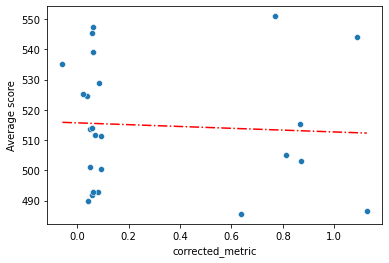

In [139]:
sns.scatterplot(data = dg,
                x = 'corrected_metric',
                y = 'Average score')


X = dg["corrected_metric"]
y = dg["Average score"]

a, b, r, p, se = linregress(X,y)
x = np.linspace(X.min(), X.max())
y = a*x + b
plt.plot(x,y,'-.r')

In [137]:
a, b,r,p,se

(-0.0020636837191510293,
 0.045647606662902754,
 -0.05726445625271515,
 0.7904092976114121,
 0.007670672007712214)

In [210]:
pcov

array([[486.55428043, -23.08181456],
       [-23.08181456,   1.13266384]])

In [174]:
pcov

array([[4758.28811487, -256.30857726],
       [-256.30857726,   13.8507829 ]])

In [334]:
R_ext_2021.head()

window  Average score  EI_FUNDEB_ratio  EF_FUNDEB_ratio  EM_FUNDEB_ratio  \
0       0            1.0              NaN         0.188581        -0.196231   
1       1            1.0              NaN         0.131417        -0.132362   
2       2            1.0              NaN         0.100095        -0.092784   
3       3            1.0              NaN         0.088621        -0.065150   
4       4            1.0         0.032932         0.066603        -0.073842   

   EF_to_total_education_expanses  EI_to_total_education_expanses  \
0                        0.098064                       -0.059303   
1                        0.051403                       -0.050460   
2                        0.036797                       -0.058309   
3                        0.036161                       -0.050778   
4                        0.095019                        0.116797   

   EM_to_total_education_expanses  education_to_overall_expanses  \
0                       -0.212312                      -0.029748   
1                       -0.185474                      -0.024847   
2                       -0.138482                       0.016508   
3                       -0.139403                       0.003554   
4                       -0.076959                       0.019412   

   scholar_nutrition_to_total_education_expanses  ...  \
0                                      -0.129630  ...   
1                                      -0.134070  ...   
2                                      -0.043420  ...   
3                                      -0.034507  ...   
4                                      -0.039362  ...   

   EM_investment_per_student  EB_investment_per_student  \
0                  -0.086427                   0.144229   
1                  -0.002188                   0.045861   
2                  -0.013876                  -0.025145   
3                   0.073817                  -0.075643   
4                   0.129025                   0.108107   

   investment_per_student  EB_expanses_teacher_per_student  \
0                0.131483                        -0.059125   
1                0.024247                        -0.126553   
2               -0.074506                        -0.136322   
3               -0.073891                        -0.117604   
4                0.128801                        -0.099752   

   EB_non_teaching_staff_per_student_expanses  \
0                                    0.075363   
1                                    0.015223   
2                                   -0.018347   
3                                   -0.017980   
4                                    0.032717   

   investment_per_student_to_PIB_per_capita  superavit_or_deficit  \
0                                       NaN              0.094797   
1                                       NaN              0.193932   
2                                       NaN              0.051593   
3                                       NaN              0.145460   
4                                       NaN              0.103913   

   FUNDEB_balance  FUNDEB_not_used  average_teacher_expanses_EB  
0        0.173321        -0.153533                          NaN  
1        0.168890        -0.153533                          NaN  
2        0.154528        -0.153533                          NaN  
3        0.109083        -0.153533                          NaN  
4        0.133741        -0.153533                          NaN  

[5 rows x 25 columns]

In [358]:
metrics_to_use = siope_df[siope_df["year"] == 2008]["metric_description"].unique()

In [364]:
siope_df.head()

year metric_code  metric_value  UF  \
0  2008         2.1          0.00  RO   
1  2008        4.11         62.50  RO   
2  2008         2.3          0.00  RO   
3  2008         2.4          0.00  RO   
4  2008         2.5         78.36  RO   

                           metric_description  
0                             EI_FUNDEB_ratio  
1  EB_non_teaching_staff_per_student_expanses  
2                             EM_FUNDEB_ratio  
3              EI_to_total_education_expanses  
4              EF_to_total_education_expanses

In [367]:
siope_df[siope_df["metric_description"].isin(metrics_to_use)].groupby("year")["metric_description"].nunique()

year
2008    18
2009    18
2010    18
2011    18
2012    18
2013    18
2014    18
2015    18
2016    18
2017    18
2018    18
2019    18
2020    18
2021    18
2022    18
Name: metric_description, dtype: int64

Text(0.5, 1.0, 'Correlações das métricas externas (SIOPE) por janela temporal - ENEM 2021')

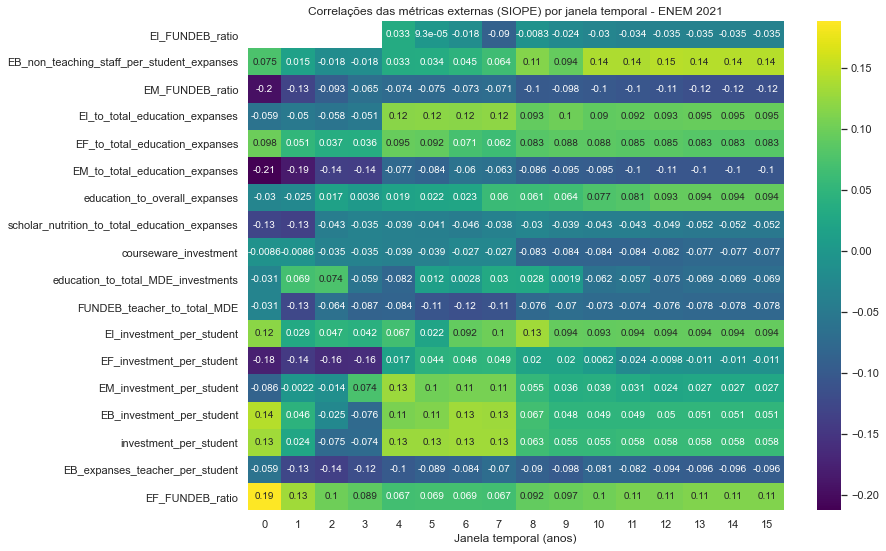

In [360]:
plt.figure(figsize = (12,9))
sns.heatmap(R_ext_2021[metrics_to_use].transpose(),
    cmap = 'viridis',
    annot = True)
plt.xlabel("Janela temporal (anos)")
plt.title("Correlações das métricas externas (SIOPE) por janela temporal - ENEM 2021")

In [40]:
grouped_siope_df = siope_df[(siope_df['year'] >= 2018 - 2)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

In [41]:
grouped_siope_df

metric_description  EB_expanses_teacher_per_student  \
UF                                                    
AC                                      4125.254286   
AM                                      2912.375714   
AP                                      6238.767143   
BA                                      4342.174286   
CE                                      4615.825714   
DF                                      6105.540000   
ES                                      2975.930000   
GO                                      4328.222857   
MA                                      5245.272857   
MS                                      4557.960000   
MT                                      4462.284286   
PA                                      3905.224286   
PB                                      3600.261429   
PE                                      3749.707143   
PI                                      3537.794286   
PR                                      4749.478571   
RJ                                      4075.812500   
RN                                      3042.010000   
RO                                      3414.192857   
RR                                      5734.635714   
SC                                      4334.955714   
SE                                      4689.941429   
SP                                      3584.667143   
TO                                      5603.920000   

metric_description  EB_investment_per_student  \
UF                                              
AC                                8646.244286   
AM                                6714.704286   
AP                               13841.918571   
BA                                8073.378571   
CE                                8943.597143   
DF                                7579.860000   
ES                                7036.448571   
GO                                7974.307143   
MA                               13531.270000   
MS                                9368.232857   
MT                               12134.824286   
PA                                6032.044286   
PB                                7810.334286   
PE                                8384.554286   
PI                               10777.507143   
PR                                8869.930000   
RJ                               12147.685000   
RN                                5550.955000   
RO                               11130.094286   
RR                                9164.748571   
SC                                7513.851429   
SE                                8200.734286   
SP                               13101.561429   
TO                                9090.040000   

metric_description  EB_non_teaching_staff_per_student_expanses  \
UF                                                               
AC                                                  307.168571   
AM                                                  534.528571   
AP                                                 1023.345714   
BA                                                  193.628571   
CE                                                  353.902857   
DF                                                  217.395000   
ES                                                  454.417143   
GO                                                  878.752857   
MA                                                  752.157143   
MS                                                 1663.312857   
MT                                                 1285.835714   
PA                                                  372.350000   
PB                                                  381.977143   
PE                                                 1563.431429   
PI                                                 1174.310000   
PR                                                 1142.725714   
RJ                                                  177.712500   
RN                                      

In [42]:
enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")

In [47]:
enem_df = enem_df.groupby("UF")["Average score"].mean().reset_index()

In [48]:
siope_data_with_scores_df = enem_df.merge(grouped_siope_df, on = 'UF', how = 'left')

In [39]:
n = np.arange(0,16)

for year in years_to_analyze:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df = enem_df.groupby("UF")["Average score"].mean().reset_index()
    for window in n:
        print(f"Running for the last {window} year(s)")
        # get metrics average values over last 'window' years
        grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df['year'] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

        siope_data_with_scores_df = enem_df.merge(grouped_siope_df, on = 'UF', how = 'left')

        r = siope_data_with_scores_df.corr(method = 'spearman', numeric_only = True)
        r["window"] = window
        R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

        del siope_data_with_scores_df
    joblib.dump(R_external, f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_with_avg_scores.pkl")
    del R_external

Running analysis for ENEM 2015
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s)
Running for the last 14 year(s)
Running for the last 15 year(s)
Running analysis for ENEM 2016
Running for the last 0 year(s)
Running for the last 1 year(s)
Running for the last 2 year(s)
Running for the last 3 year(s)
Running for the last 4 year(s)
Running for the last 5 year(s)
Running for the last 6 year(s)
Running for the last 7 year(s)
Running for the last 8 year(s)
Running for the last 9 year(s)
Running for the last 10 year(s)
Running for the last 11 year(s)
Running for the last 12 year(s)
Running for the last 13 year(s

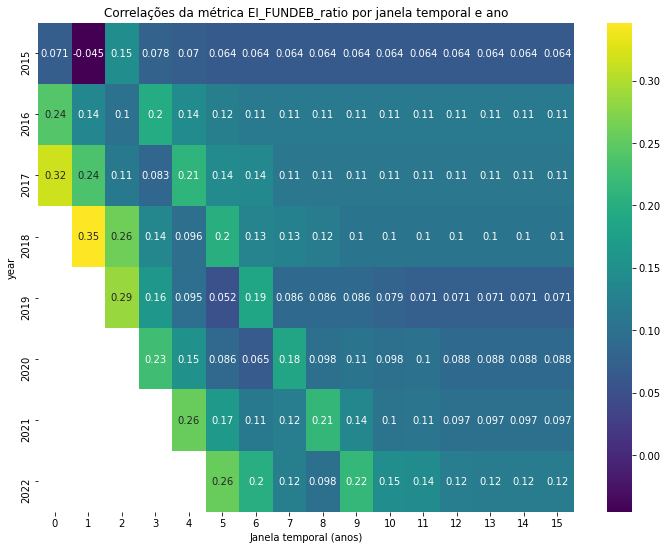

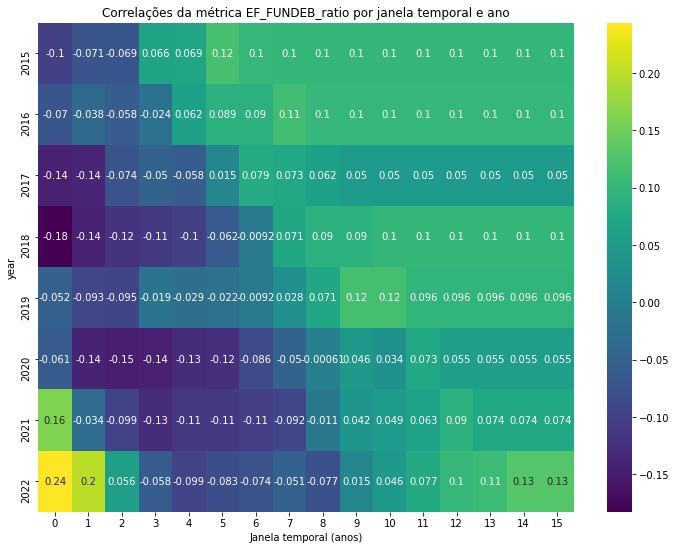

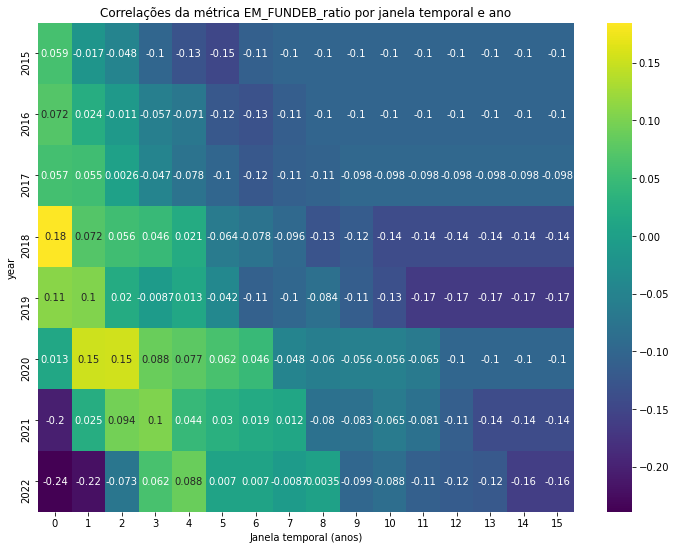

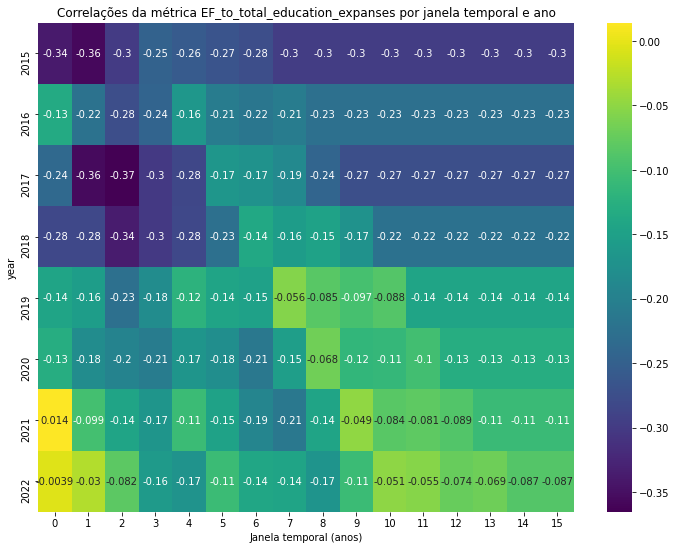

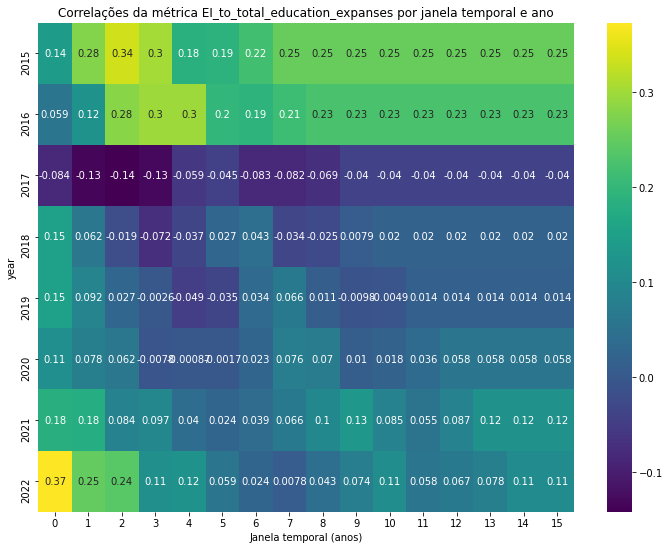

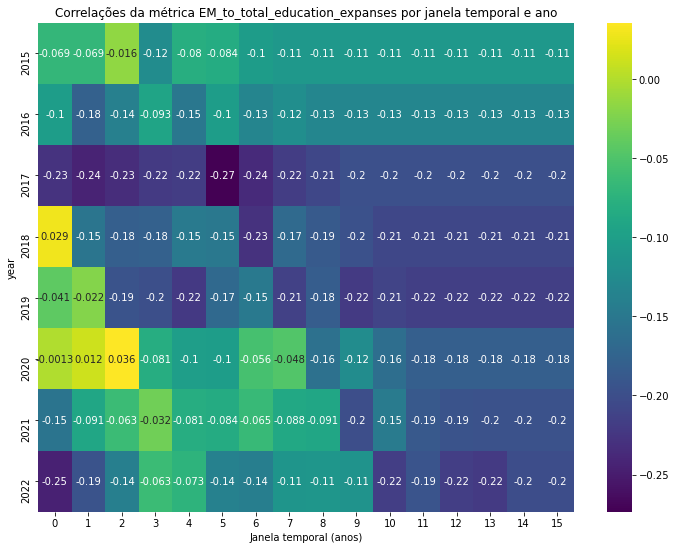

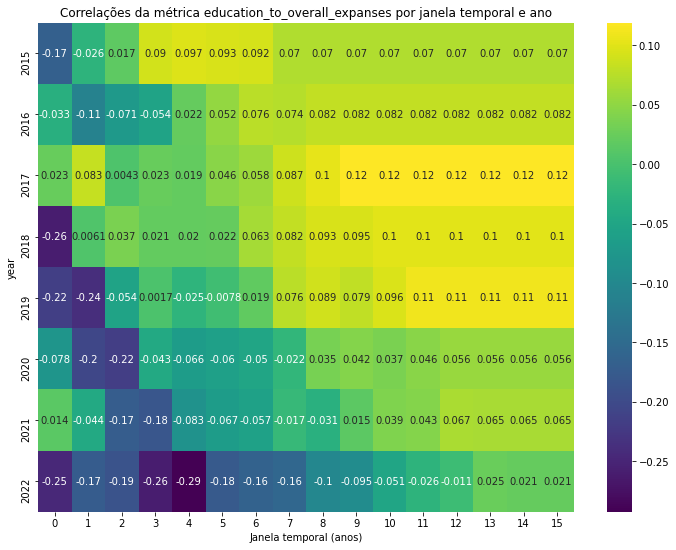

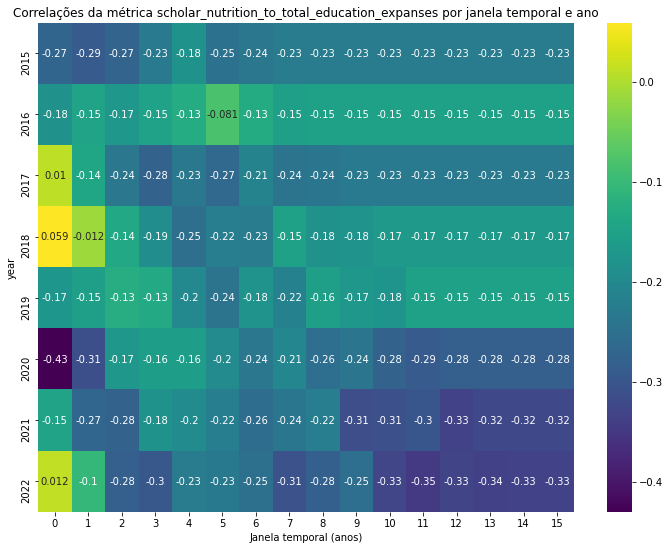

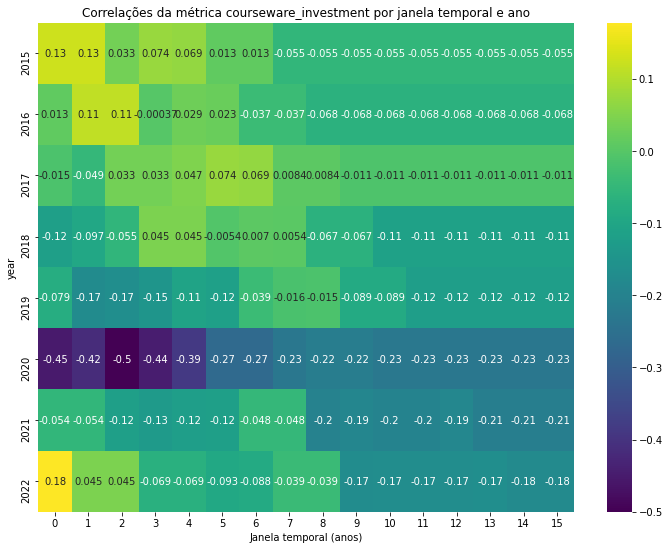

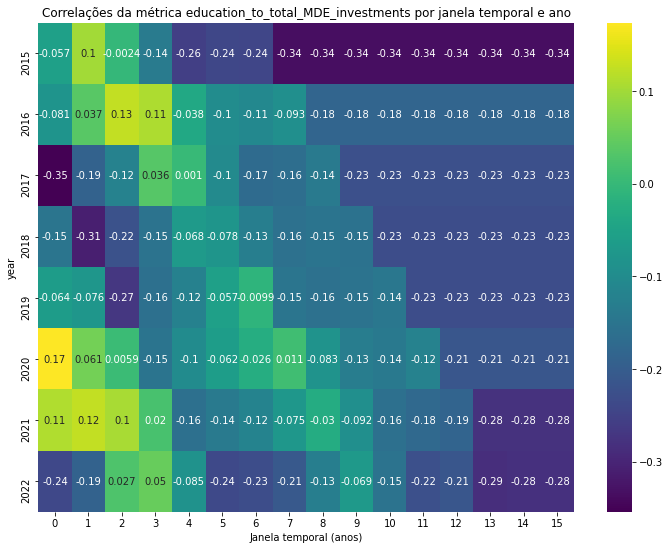

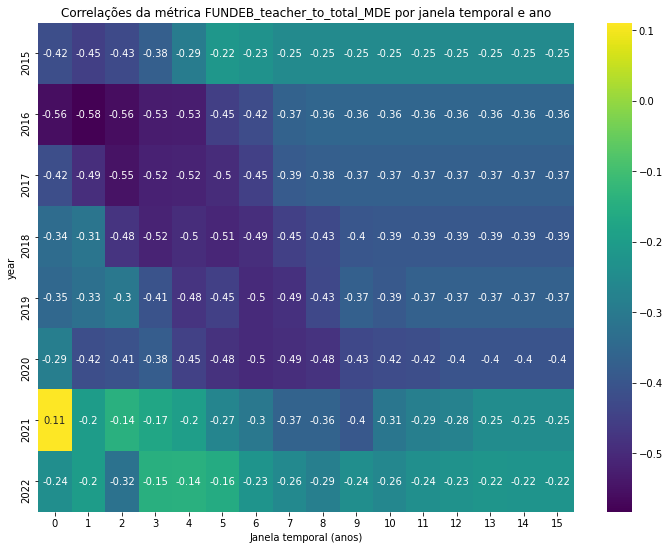

Couldn't plot for EI_investiment_per_student


<Figure size 864x648 with 0 Axes>

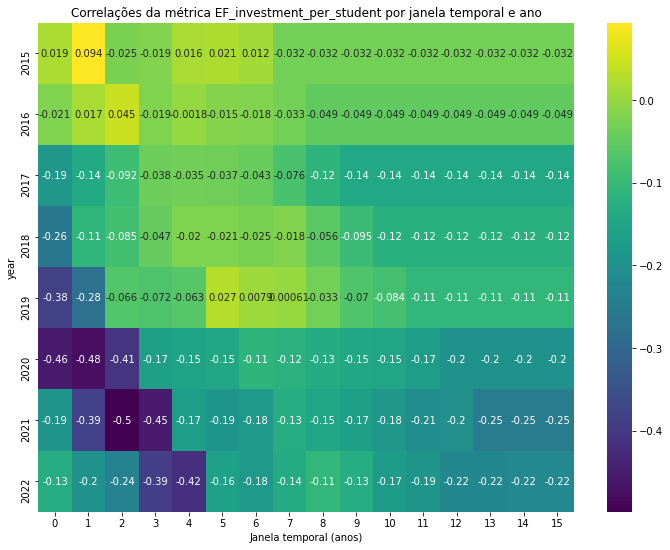

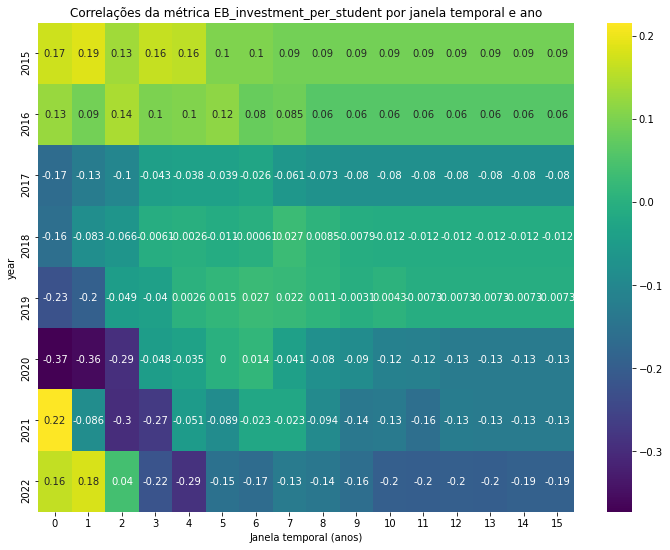

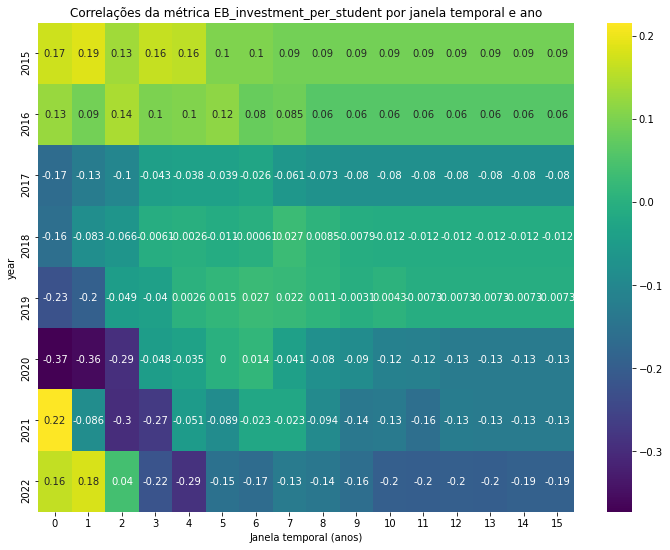

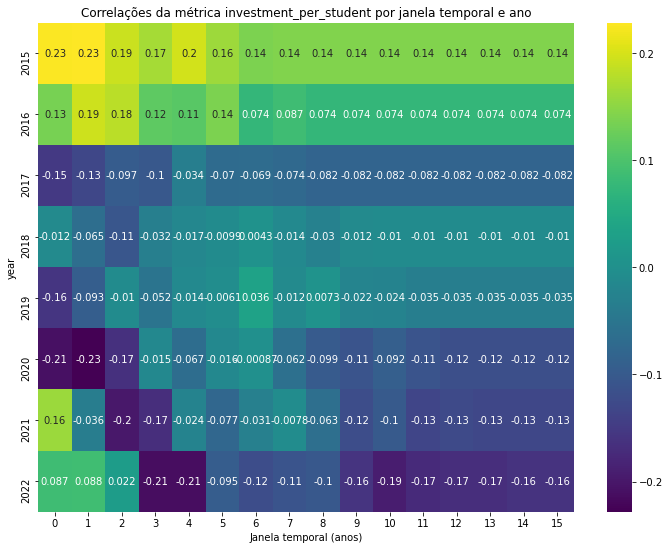

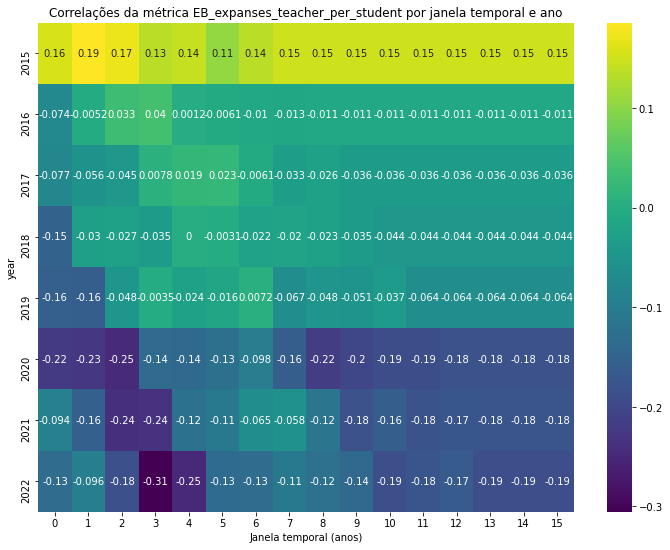

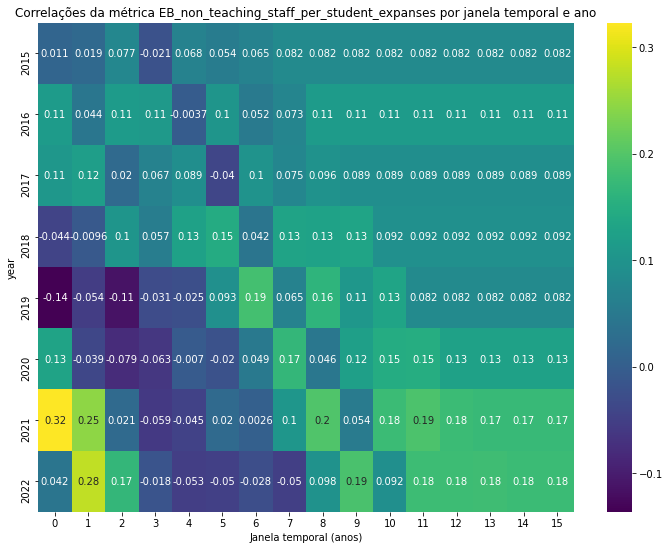

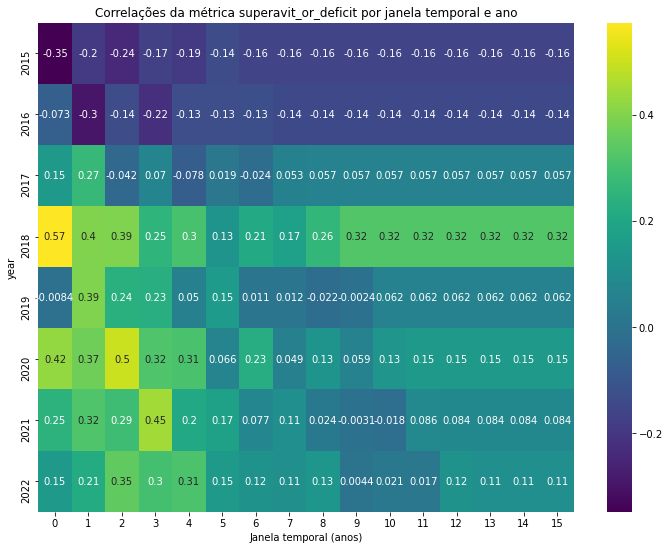

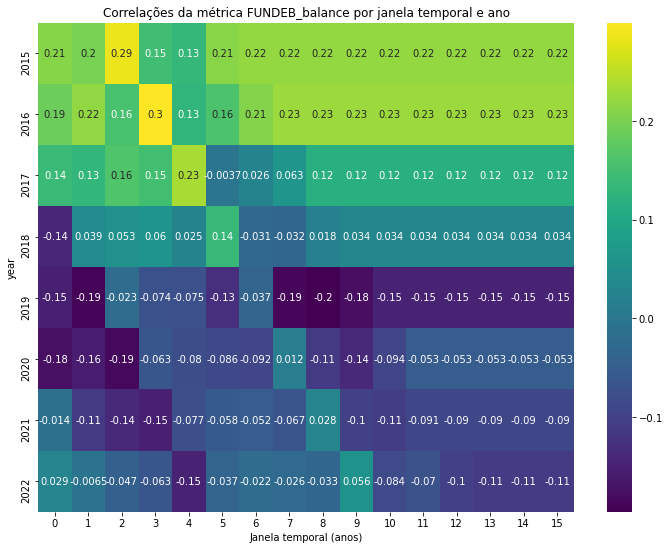

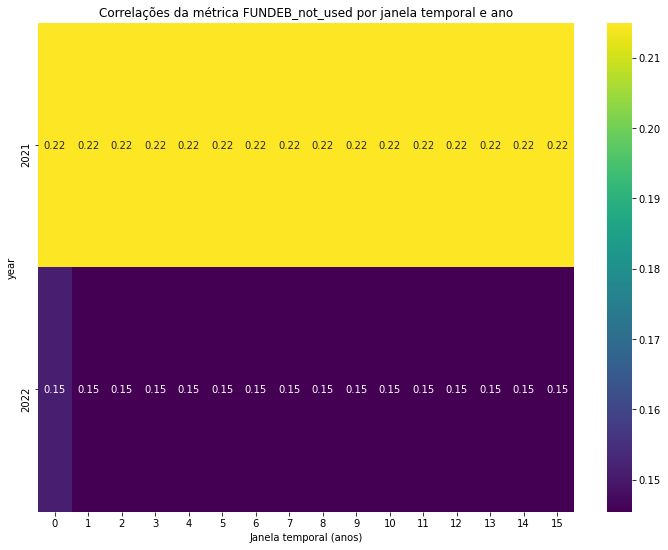

Couldn't plot for avereage_teacher_expanses_EB


<Figure size 864x648 with 0 Axes>

In [42]:
siope_corr_df = pd.DataFrame()
for year in years_to_analyze:
    R_ext = joblib.load(f"siope_correlations_ENEM_{year}_based_on_SG_UF_PROVA_with_avg_scores.pkl")
    R_ext["year"] = year

    siope_corr_df = pd.concat([siope_corr_df, R_ext], axis = 0)

siope_corr_df = siope_corr_df.drop(index = "Average score").reset_index().rename(columns = {"index": "metric"})

for metric in metrics_to_use:
    plt.figure(figsize = (12,9))
    df = siope_corr_df[siope_corr_df["metric"] == metric]
    try:
        sns.heatmap(df.pivot(columns = "window", index = "year", values = "Average score"), annot = True, cmap = 'viridis')
        plt.xlabel("Janela temporal (anos)")
        plt.title(f"Correlações da métrica {metric} por janela temporal e ano")
        plt.show()
    except:
        print(f"Couldn't plot for {metric}")

Text(0.5, 1.0, 'Correlações das métricas externas (SIOPE) por janela temporal - ENEM 2021')

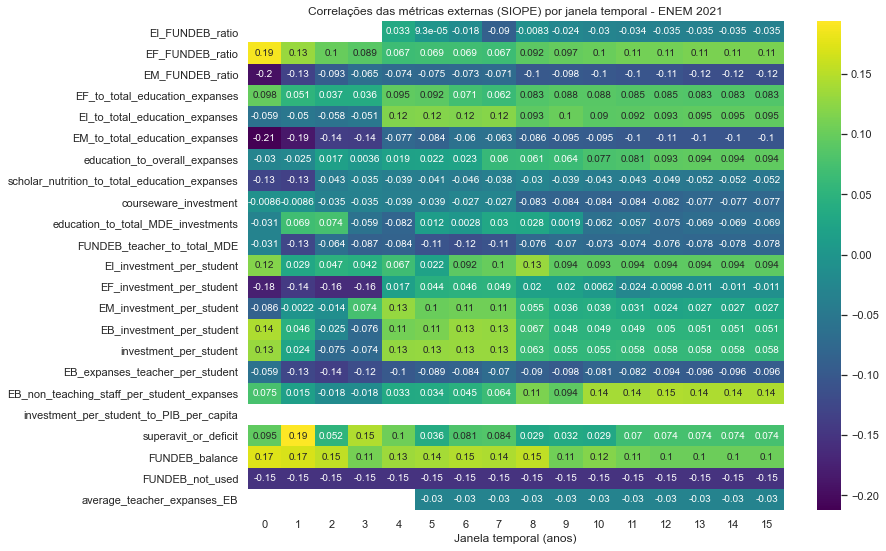

In [343]:
plt.figure(figsize = (12,9))
sns.heatmap(R_ext_2021.drop(columns = ["window", "Average score"]).transpose(),
    cmap = 'viridis',
    annot = True)
plt.xlabel("Janela temporal (anos)")
plt.title("Correlações das métricas externas (SIOPE) por janela temporal - ENEM 2021")

<AxesSubplot: xlabel='year', ylabel='UF'>

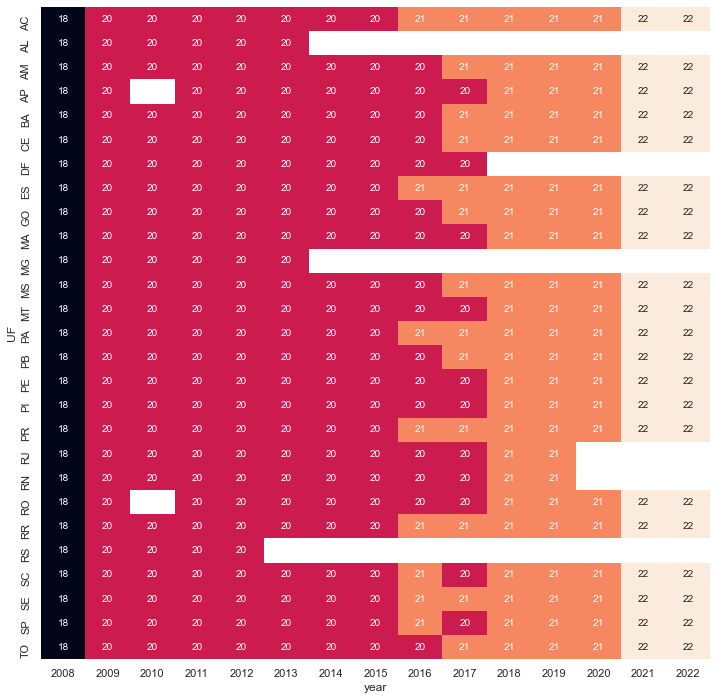

In [352]:
plt.figure(figsize = (12,12))
sns.heatmap(siope_df.groupby(["year", "UF"])["UF"].count().unstack().transpose(),
    annot = True, cbar = False)

<AxesSubplot: xlabel='year', ylabel='metric_description'>

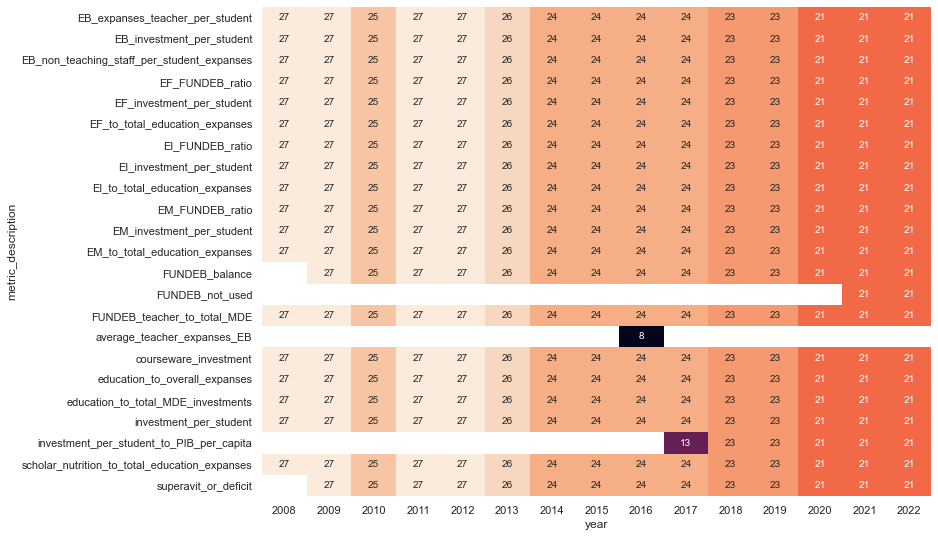

In [353]:
plt.figure(figsize = (12,9))
sns.heatmap(siope_df.groupby(["year", "metric_description"])["UF"].count().unstack().transpose(),
    annot = True, cbar = False)

In [344]:
siope_df.columns

Index(['year', 'metric_code', 'metric_value', 'UF', 'metric_description'], dtype='object')

In [160]:
current_year = 2022
window = 0

grouped_siope_df = siope_df[(siope_df['year'] >= current_year - window)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

metrics_added = []
df2 = df.copy()
for metric in SIOPE_METRICS_DICT.values():
    try:
        df2 = df2.merge(grouped_sinop_df[metric], how = 'left', on = 'UF')
        metrics_added.append(metric)
    except:
        df2 = df2

siope_data = siope_df[siope_df["year"] >= 2022 - window]
siope_data = siope_data.merge(enem_df[enem_df["ENEM_year"] == current_year][["UF", "Average score"]], how = 'left', on = ['UF'])

In [162]:
grouped_siope_df = siope_df[(siope_df['year'] >= 2008)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

In [163]:
grouped_siope_df

metric_description  EB_expanses_teacher_per_student  \
UF                                                    
AC                                      3635.519333   
AL                                      1628.285000   
AM                                      2137.502667   
AP                                      4485.423571   
BA                                      3005.346000   
CE                                      3237.058000   
DF                                      5113.448000   
ES                                      2556.263333   
GO                                      3772.728000   
MA                                      3645.473333   
MG                                      1597.071667   
MS                                      3655.800667   
MT                                      3138.040667   
PA                                      3008.834000   
PB                                      2557.092000   
PE                                      2700.392000   
PI                                      2781.662000   
PR                                      3751.600000   
RJ                                      2965.517500   
RN                                      2399.313333   
RO                                      2632.522857   
RR                                      4296.514667   
RS                                      1746.614000   
SC                                      3223.777333   
SE                                      3707.605333   
SP                                      2809.122000   
TO                                      4124.467333   

metric_description  EB_investment_per_student  \
UF                                              
AC                                6579.541333   
AL                                2920.473333   
AM                                4892.214000   
AP                                9693.315714   
BA                                5506.271333   
CE                                6307.088000   
DF                                6784.513000   
ES                                6201.308000   
GO                                5998.958667   
MA                                8340.432000   
MG                                3517.036667   
MS                                7167.770000   
MT                                7531.129333   
PA                                4366.503333   
PB                                5189.102667   
PE                                5933.111333   
PI                                6918.328000   
PR                                6231.992667   
RJ                                6579.660000   
RN                                4050.845833   
RO                                7513.250714   
RR                                7308.065333   
RS                                3271.778000   
SC                                5343.191333   
SE                                6173.620000   
SP                                8572.593333   
TO                                6504.285333   

metric_description  EB_non_teaching_staff_per_student_expanses  \
UF                                                               
AC                                                  149.376000   
AL                                                  628.688333   
AM                                                  421.335333   
AP                                                 1199.333571   
BA                                                  166.709333   
CE                                                  529.256667   
DF                                                  587.432000   
ES                                                  712.836000   
GO                                                  551.632000   
MA                                                  752.781333   
MG                                                 1491.290000   
MS                                                 1052.991333   
MT                                                  892.80

In [174]:
grouped_siope_df = siope_df[(siope_df['year'] >= 2008)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()
metrics_added = []
df2 = enem_df[enem_df["ENEM_year"] == current_year][["UF", "Average score"]].copy()

for metric in SIOPE_METRICS_DICT.values():
    try:
        df2 = df2.merge(grouped_siope_df[metric], how = 'left', on = 'UF')
        metrics_added.append(metric)
    except:
        df2 = df2

In [175]:
df2.head()

UF  Average score  EI_FUNDEB_ratio  EF_FUNDEB_ratio  EM_FUNDEB_ratio  \
0  CE        449.925         0.025333        16.782000        81.138000   
1  SP        766.925         0.008000        57.009333        41.254000   
2  GO        539.050         0.010667        72.736667        23.993333   
3  PA        457.450         0.086667        50.304000        46.482000   
4  RJ        477.075         0.025833        47.840000        50.339167   

   EF_to_total_education_expanses  EI_to_total_education_expanses  \
0                       13.908000                        0.256000   
1                       40.095333                        4.748667   
2                       56.509333                        0.116000   
3                       37.458667                        0.142667   
4                       37.319167                        5.261667   

   EM_to_total_education_expanses  education_to_overall_expanses  \
0                       64.225333                      13.992667   
1                       40.553333                      17.448000   
2                       30.692667                      16.924667   
3                       39.631333                      15.246000   
4                       34.245000                      10.129167   

   scholar_nutrition_to_total_education_expanses  ...  \
0                                       0.881333  ...   
1                                       0.342667  ...   
2                                       0.260667  ...   
3                                       0.006000  ...   
4                                       0.000000  ...   

   EF_investment_per_student  EM_investment_per_student  \
0                5307.211333                6421.892000   
1                5595.066000                8897.180667   
2                7319.495333                4554.062667   
3                5127.911333                4043.182667   
4                7797.210000                5027.366667   

   EB_investment_per_student  investment_per_student  \
0                6307.088000             6898.472667   
1                8572.593333             9897.517333   
2                5998.958667             6177.446667   
3                4366.503333             4507.713333   
4                6579.660000             7574.906667   

   EB_expanses_teacher_per_student  \
0                        3237.0580   
1                        2809.1220   
2                        3772.7280   
3                        3008.8340   
4                        2965.5175   

   EB_non_teaching_staff_per_student_expanses  \
0                                  529.256667   
1                                 1092.695333   
2                                  551.632000   
3                                  220.354000   
4                                  300.236667   

   investment_per_student_to_PIB_per_capita  superavit_or_deficit  \
0                                       0.0          1.794286e+08   
1                                       0.0          1.615154e+09   
2                                       0.0          2.006830e+09   
3                                       0.0          1.188040e+09   
4                                       0.0         -2.921392e+09   

   FUNDEB_balance  FUNDEB_not_used  
0    1.156271e+08     1.947317e+08  
1    1.691679e+09     0.000000e+00  
2    6.105089e+07     1.522104e+08  
3    5.948811e+07     5.089881e+07  
4    1.415854e+08              NaN  

[5 rows x 25 columns]

In [177]:
R_ext = df2.drop(columns = "UF").corr(method = 'spearman')

In [186]:
abs(R_ext["Average score"].sort_values(ascending = False))

Average score                                    1.000000
EB_non_teaching_staff_per_student_expanses       0.126877
EF_FUNDEB_ratio                                  0.114935
FUNDEB_balance                                   0.098419
EI_investment_per_student                        0.091229
EF_to_total_education_expanses                   0.088508
education_to_overall_expanses                    0.075390
EI_to_total_education_expanses                   0.072704
superavit_or_deficit                             0.064230
investment_per_student                           0.042045
EB_investment_per_student                        0.034432
EM_investment_per_student                        0.013053
EF_investment_per_student                        0.008874
EI_FUNDEB_ratio                                  0.024239
average_teacher_expanses_EB                      0.037458
scholar_nutrition_to_total_education_expanses    0.052523
education_to_total_MDE_investments               0.064849
courseware_inv

In [243]:
r = {}
p = {}

for i in siope_data_with_scores_df.columns:
    r[i], p[i] = spearmanr(siope_data_with_scores_df[i], siope_data_with_scores_df["Average score"])

In [261]:
R_external.reset_index(inplace = True)

In [ ]:
R_external.set_index()

In [271]:
R_external.rename(columns = {"index": "metric"}, inplace = True)

In [272]:
R_external.head()

metric  Average score  window
0                   Average score       1.000000       0
1                 EI_FUNDEB_ratio            NaN       0
2                 EF_FUNDEB_ratio       0.180427       0
3                 EM_FUNDEB_ratio      -0.176175       0
4  EF_to_total_education_expanses       0.080211       0

In [284]:
R_external_2 = pd.DataFrame()
i = 0
for metric in R_external['metric'].unique():
    aux_df = R_external[R_external['metric'] == metric][['window', 'Average score']]
    aux_df.rename(columns = {"Average score": metric}, inplace = True)

    if i == 0:
        R_external_2 = pd.concat([R_external_2, aux_df], axis = 1)
    else:
        R_external_2 = R_external_2.merge(aux_df, on = 'window', how = 'left')
    i += 1

In [295]:
R_external_2.columns

Index(['window', 'Average score', 'EI_FUNDEB_ratio', 'EF_FUNDEB_ratio',
       'EM_FUNDEB_ratio', 'EF_to_total_education_expanses',
       'EI_to_total_education_expanses', 'EM_to_total_education_expanses',
       'education_to_overall_expanses',
       'scholar_nutrition_to_total_education_expanses',
       'courseware_investment', 'education_to_total_MDE_investments',
       'FUNDEB_teacher_to_total_MDE', 'EI_investment_per_student',
       'EF_investment_per_student', 'EM_investment_per_student',
       'EB_investment_per_student', 'investment_per_student',
       'EB_expanses_teacher_per_student',
       'EB_non_teaching_staff_per_student_expanses',
       'investment_per_student_to_PIB_per_capita', 'superavit_or_deficit',
       'FUNDEB_balance', 'FUNDEB_not_used', 'average_teacher_expanses_EB'],
      dtype='object')

<AxesSubplot: xlabel='window', ylabel='EB_investment_per_student'>

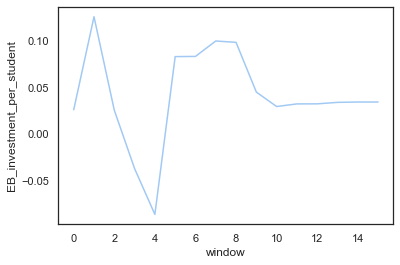

In [302]:
sns.lineplot(data = R_external_2,
    x = 'window',
    y = 'EB_investment_per_student')

In [288]:
R_external_2

window  Average score  EI_FUNDEB_ratio  EF_FUNDEB_ratio  EM_FUNDEB_ratio  \
0        0            1.0              NaN         0.180427        -0.176175   
1        1            1.0              NaN         0.178737        -0.183355   
2        2            1.0              NaN         0.133244        -0.133492   
3        3            1.0              NaN         0.103735        -0.098203   
4        4            1.0              NaN         0.092586        -0.075828   
5        5            1.0         0.036652         0.077732        -0.085625   
6        6            1.0         0.007895         0.081525        -0.086694   
7        7            1.0        -0.020513         0.081874        -0.085615   
8        8            1.0        -0.079053         0.079443        -0.082802   
9        9            1.0         0.001353         0.102880        -0.110414   
10      10            1.0        -0.013161         0.106578        -0.106945   
11      11            1.0        -0.019328         0.109001        -0.110364   
12      12            1.0        -0.023974         0.112282        -0.109718   
13      13            1.0        -0.024239         0.111784        -0.111513   
14      14            1.0        -0.024239         0.114935        -0.117614   
15      15            1.0        -0.024239         0.114935        -0.117614   

    EF_to_total_education_expanses  EI_to_total_education_expanses  \
0                         0.080211                       -0.029952   
1                         0.095289                       -0.048158   
2                         0.059102                       -0.043566   
3                         0.043131                       -0.046365   
4                         0.042653                       -0.038318   
5                         0.099731                        0.090650   
6                         0.096525                        0.091413   
7                         0.080561                        0.087289   
8                         0.071532                        0.093002   
9                         0.089549                        0.069933   
10                        0.092845                        0.076174   
11                        0.092760                        0.069174   
12                        0.090258                        0.069688   
13                        0.090632                        0.070335   
14                        0.088508                        0.072704   
15                        0.088508                        0.072704   

    EM_to_total_education_expanses  education_to_overall_expanses  \
0                        -0.185154                      -0.092013   
1                        -0.199453                      -0.036773   
2                        -0.177234                      -0.033804   
3                        -0.139112                       0.008785   
4                        -0.139404                      -0.004491   
5                        -0.084501                       0.011225   
6                        -0.090608                       0.015169   
7                        -0.075168                       0.016701   
8                        -0.076433                       0.044288   
9                        -0.098136                       0.047008   
10                       -0.102335                       0.048859   
11                       -0.102910                       0.060265   
12                       -0.109815                       0.064449   
13                       -0.113349                       0.074111   
14                       -0.114030                       0.075390   
15                       -0.114030                       0.075390   

    scholar_nutrition_to_total_education_expanses  ...  \
0                                       -0.107075  ...   
1                                       -0.134873  ...   
2                                       -0.140492  ...   
3                                       -0.048

<AxesSubplot: xlabel='window'>

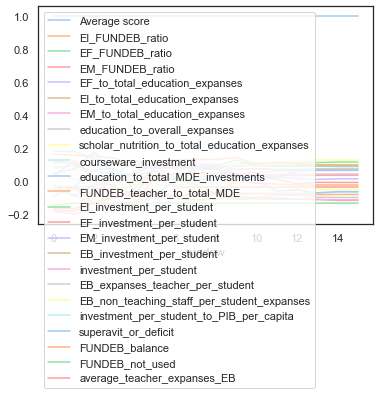

In [278]:
R_external_2

window  Average score  window  Average score  window  Average score  \
0       0.0            1.0     NaN            NaN     NaN            NaN   
23      1.0            1.0     NaN            NaN     NaN            NaN   
46      2.0            1.0     NaN            NaN     NaN            NaN   
69      3.0            1.0     NaN            NaN     NaN            NaN   
92      4.0            1.0     NaN            NaN     NaN            NaN   
..      ...            ...     ...            ...     ...            ...   
269     NaN            NaN     NaN            NaN     NaN            NaN   
293     NaN            NaN     NaN            NaN     NaN            NaN   
317     NaN            NaN     NaN            NaN     NaN            NaN   
341     NaN            NaN     NaN            NaN     NaN            NaN   
365     NaN            NaN     NaN            NaN     NaN            NaN   

     window  Average score  window  Average score  ...  window  Average score  \
0       NaN            NaN     NaN            NaN  ...     NaN            NaN   
23      NaN            NaN     NaN            NaN  ...     NaN            NaN   
46      NaN            NaN     NaN            NaN  ...     NaN            NaN   
69      NaN            NaN     NaN            NaN  ...     NaN            NaN   
92      NaN            NaN     NaN            NaN  ...     NaN            NaN   
..      ...            ...     ...            ...  ...     ...            ...   
269     NaN            NaN     NaN            NaN  ...     NaN            NaN   
293     NaN            NaN     NaN            NaN  ...     NaN            NaN   
317     NaN            NaN     NaN            NaN  ...     NaN            NaN   
341     NaN            NaN     NaN            NaN  ...     NaN            NaN   
365     NaN            NaN     NaN            NaN  ...     NaN            NaN   

     window  Average score  window  Average score  window  Average score  \
0       NaN            NaN     NaN            NaN     NaN            NaN   
23      NaN            NaN     NaN            NaN     NaN            NaN   
46      NaN            NaN     NaN            NaN     NaN            NaN   
69      NaN            NaN     NaN            NaN     NaN            NaN   
92      NaN            NaN     NaN            NaN     NaN            NaN   
..      ...            ...     ...            ...     ...            ...   
269     NaN            NaN     NaN            NaN     NaN            NaN   
293     NaN            NaN     NaN            NaN     NaN            NaN   
317     NaN            NaN     NaN            NaN     NaN            NaN   
341     NaN            NaN     NaN            NaN     NaN            NaN   
365     NaN            NaN     NaN            NaN     NaN            NaN   

     window  Average score  
0       NaN            NaN  
23      NaN            NaN  
46      NaN            NaN  
69      NaN            NaN  
92      NaN            NaN  
..      ...            ...  
269    11.0      -0.037458  
293    12.0      -0.037458  
317    13.0      -0.037458  
341    14.0      -0.037458  
365    15.0      -0.037458  

[378 rows x 48 columns]

In [259]:
R_external.groupby("window")[["EF_FUNDEB_ratio", "FUNDEB_not_used"]].mean()

KeyError: "Columns not found: 'EF_FUNDEB_ratio', 'FUNDEB_not_used'"

In [254]:
R_external["EF_FUNDEB_ratio"]

KeyError: 'EF_FUNDEB_ratio'

In [255]:
R_external

0
Average score                              1.000000
EI_FUNDEB_ratio                                 NaN
EF_FUNDEB_ratio                            0.180427
EM_FUNDEB_ratio                           -0.176175
EF_to_total_education_expanses             0.080211
...                                             ...
investment_per_student_to_PIB_per_capita        NaN
superavit_or_deficit                       0.064230
FUNDEB_balance                             0.098419
FUNDEB_not_used                           -0.134658
window                                    15.000000

[394 rows x 1 columns]

Graph considering SIOPE data from 2022 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     6.604990e+06
AL     512.743883              NaN
AM     492.254220     6.643711e+07
AP     495.929105     5.005544e+06
BA     519.265226     1.995258e+07
CE     498.527925     1.551525e+08
DF     541.336009              NaN
ES     536.361601     6.412607e+07
GO     520.060609     1.729171e+08
MA     493.138612     4.766160e+06
MG     550.237539              NaN
MS     522.928453     4.092974e+07
MT     515.108975     2.300292e+08
PA     500.616448     2.549017e+07
PB     515.831051     1.092969e+08
PE     521.584773     3.356645e+08
PI     513.005297     3.388487e+07
PR     535.984980     1.088798e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     0.000000e+00
RR     514.555936     3.245098e+07
RS     539.186444              NaN
SC     543.311559     2.059342e+07
SE     515.966445     5.044878e+05
SP     5

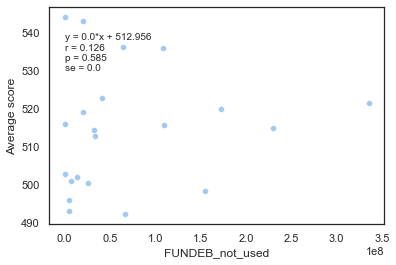

Graph considering SIOPE data from 2021 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

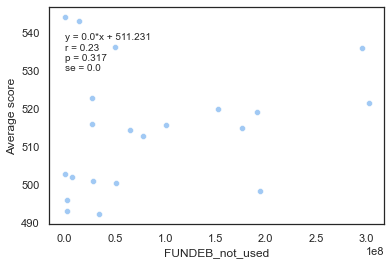

Graph considering SIOPE data from 2020 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

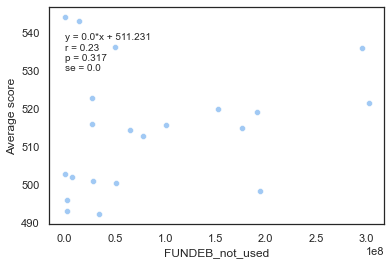

Graph considering SIOPE data from 2019 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

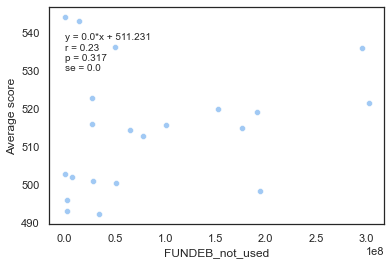

Graph considering SIOPE data from 2018 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

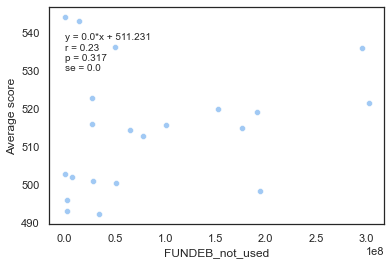

Graph considering SIOPE data from 2017 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

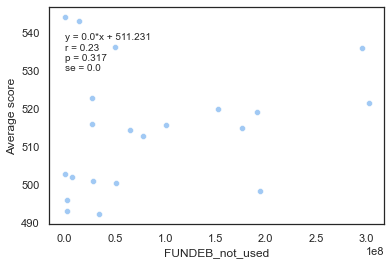

Graph considering SIOPE data from 2016 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

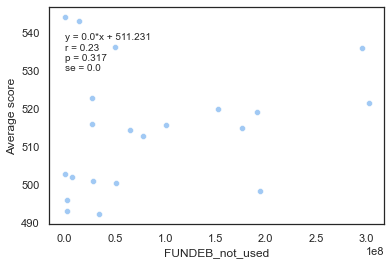

Graph considering SIOPE data from 2015 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

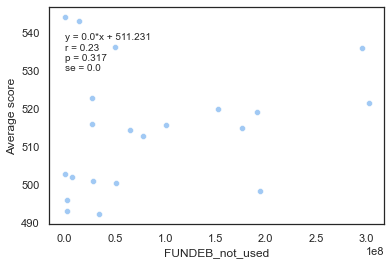

Graph considering SIOPE data from 2014 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

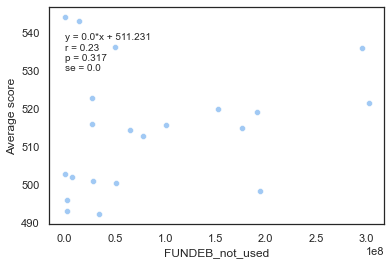

Graph considering SIOPE data from 2013 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

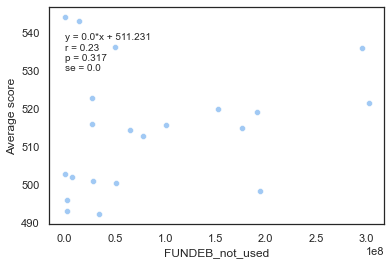

Graph considering SIOPE data from 2012 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

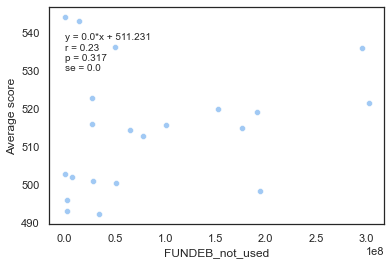

Graph considering SIOPE data from 2011 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

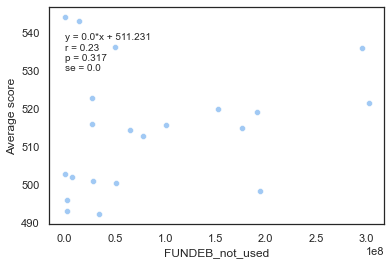

Graph considering SIOPE data from 2010 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

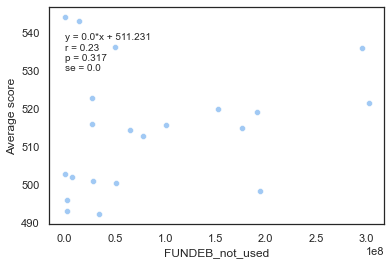

Graph considering SIOPE data from 2009 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

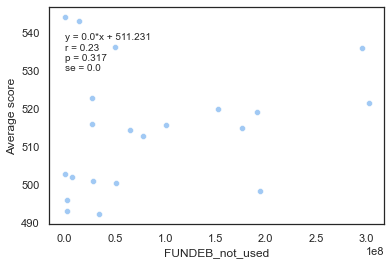

Graph considering SIOPE data from 2008 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

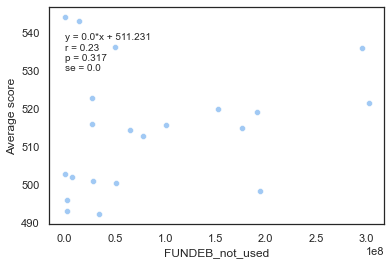

Graph considering SIOPE data from 2007 to 2022
    Average score  FUNDEB_not_used
UF                                
AC     500.941579     2.845617e+07
AL     512.743883              NaN
AM     492.254220     3.430979e+07
AP     495.929105     2.872245e+06
BA     519.265226     1.908919e+08
CE     498.527925     1.947317e+08
DF     541.336009              NaN
ES     536.361601     4.989603e+07
GO     520.060609     1.522104e+08
MA     493.138612     2.383080e+06
MG     550.237539              NaN
MS     522.928453     2.741560e+07
MT     515.108975     1.766481e+08
PA     500.616448     5.089881e+07
PB     515.831051     1.010479e+08
PE     521.584773     3.026724e+08
PI     513.005297     7.780587e+07
PR     535.984980     2.956076e+08
RJ     542.709208              NaN
RN     527.648552              NaN
RO     502.833553     2.428870e+05
RR     514.555936     6.505123e+07
RS     539.186444              NaN
SC     543.311559     1.440078e+07
SE     515.966445     2.768641e+07
SP     5

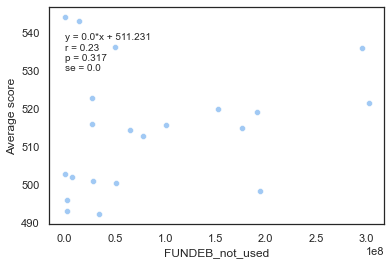

In [305]:
 n = np.arange(0,16)
# n = [0]
current_year = 2022

for window in n:
    # get metrics average values over last 'window' years
    grouped_siope_df = siope_df[(siope_df['year'] >= current_year - window)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

    siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, current_year)

    data = siope_data_with_scores_df.groupby(["UF"])[["Average score", "FUNDEB_not_used"]].mean()
    print(f"Graph considering SIOPE data from {current_year - window} to {current_year}")
    sns.scatterplot(data = data,
    x = 'FUNDEB_not_used',
    y = 'Average score'
    )

    print(data)

    data.dropna(inplace = True)
    slope, intercept, r, p, se = linregress(x = data["FUNDEB_not_used"], y = data["Average score"])

    xx = np.arange(0,100)
    yy = slope*xx + intercept
    plt.plot(xx, yy, '-.r')

    plt.text(x = 15, y = 530, s = f"y = {np.round(slope,3)}*x + {np.round(intercept,3)}\nr = {np.round(r,3)}\np = {np.round(p,3)}\nse = {np.round(se,3)}")

    plt.show()

    del siope_data_with_scores_df


Graph considering SIOPE data from 2022 to 2022


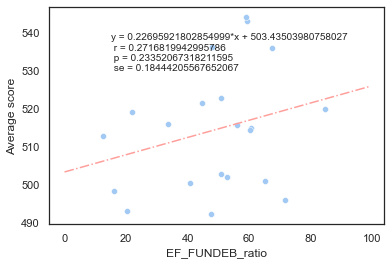

Graph considering SIOPE data from 2021 to 2022


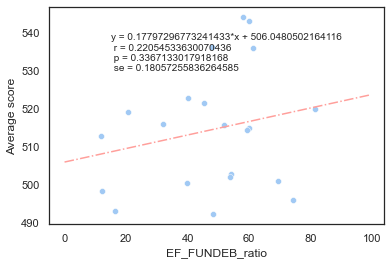

Graph considering SIOPE data from 2020 to 2022


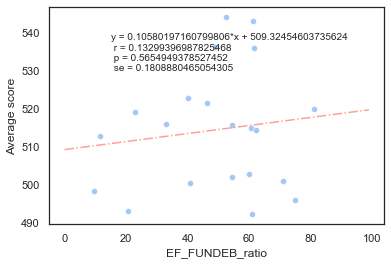

Graph considering SIOPE data from 2019 to 2022


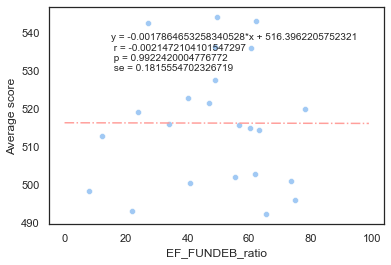

Graph considering SIOPE data from 2018 to 2022


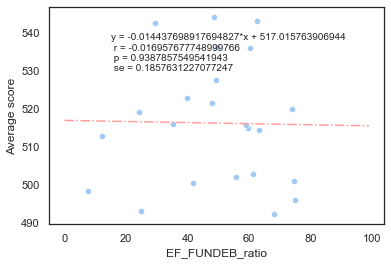

Graph considering SIOPE data from 2017 to 2022


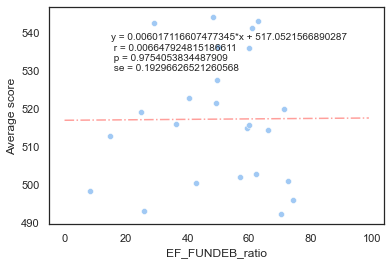

Graph considering SIOPE data from 2016 to 2022


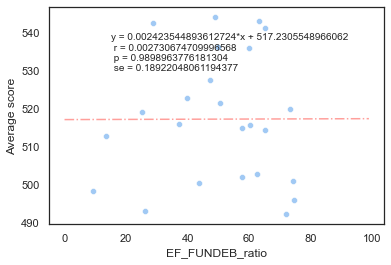

Graph considering SIOPE data from 2015 to 2022


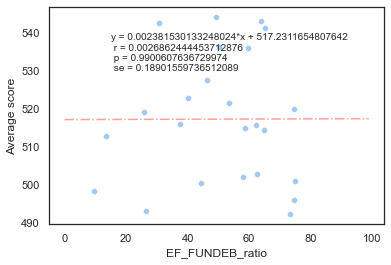

Graph considering SIOPE data from 2014 to 2022


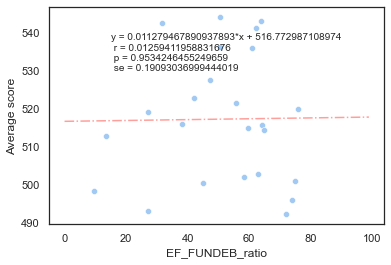

Graph considering SIOPE data from 2013 to 2022


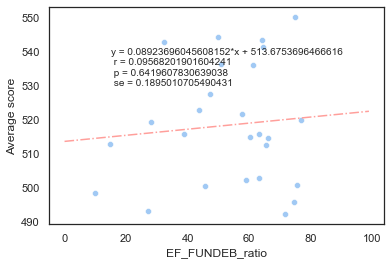

Graph considering SIOPE data from 2012 to 2022


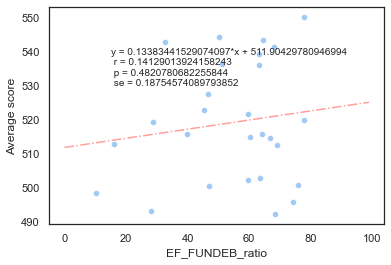

Graph considering SIOPE data from 2011 to 2022


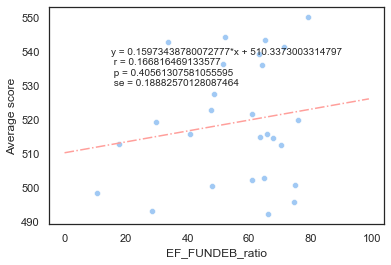

Graph considering SIOPE data from 2010 to 2022


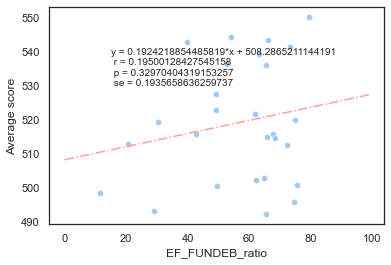

Graph considering SIOPE data from 2009 to 2022


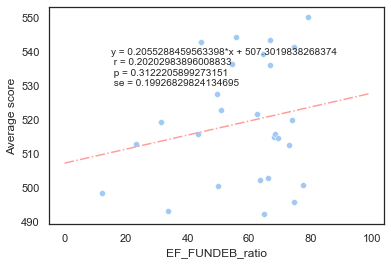

Graph considering SIOPE data from 2008 to 2022


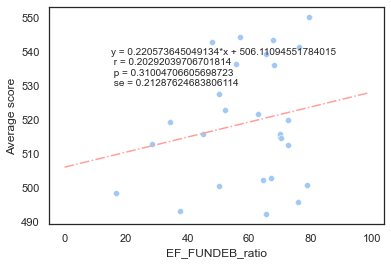

Graph considering SIOPE data from 2007 to 2022


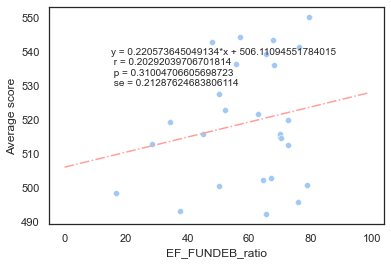

In [235]:
 n = np.arange(0,16)
# n = [0]
current_year = 2022

for window in n:
    # get metrics average values over last 'window' years
    grouped_siope_df = siope_df[(siope_df['year'] >= current_year - window)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

    siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, current_year)

    data = siope_data_with_scores_df.groupby(["UF"])[["Average score", "EF_FUNDEB_ratio"]].mean()
    print(f"Graph considering SIOPE data from {current_year - window} to {current_year}")
    sns.scatterplot(data = data,
    x = 'EF_FUNDEB_ratio',
    y = 'Average score'
    )

    data.dropna(inplace = True)
    slope, intercept, r, p, se = linregress(x = data["EF_FUNDEB_ratio"], y = data["Average score"])

    xx = np.arange(0,100)
    yy = slope*xx + intercept
    plt.plot(xx, yy, '-.r')

    plt.text(x = 15, y = 530, s = f"y = {slope}*x + {intercept}\n r = {r} \n p = {p} \n se = {se}")

    plt.show()

    del siope_data_with_scores_df


In [185]:
siope_data_with_scores_df

UF  Average score  EI_FUNDEB_ratio  EF_FUNDEB_ratio  EM_FUNDEB_ratio  \
0       CE        449.925              0.0            15.96            87.89   
1       SP        766.925              0.0            59.06            41.00   
2       GO        539.050              0.0            84.74            14.01   
3       PA        457.450              0.0            40.71            61.33   
4       RJ        477.075              NaN              NaN              NaN   
...     ..            ...              ...              ...              ...   
659247  RS        409.575              NaN              NaN              NaN   
659248  RS        512.975              NaN              NaN              NaN   
659249  RJ        503.775              NaN              NaN              NaN   
659250  MG        531.525              NaN              NaN              NaN   
659251  SC        593.825              0.0            59.21            40.27   

        EF_to_total_education_expanses  EI_to_total_education_expanses  \
0                                 2.97                            0.26   
1                                26.70                            0.02   
2                                59.19                            0.27   
3                                29.74                            0.01   
4                                  NaN                             NaN   
...                                ...                             ...   
659247                             NaN                             NaN   
659248                             NaN                             NaN   
659249                             NaN                             NaN   
659250                             NaN                             NaN   
659251                           41.45                            0.01   

        EM_to_total_education_expanses  education_to_overall_expanses  \
0                                60.33                          20.56   
1                                29.61                          15.46   
2                                18.62                          15.84   
3                                56.44                          15.75   
4                                  NaN                            NaN   
...                                ...                            ...   
659247                             NaN                            NaN   
659248                             NaN                            NaN   
659249                             NaN                            NaN   
659250                             NaN                            NaN   
659251                           31.39                          37.45   

        scholar_nutrition_to_total_education_expanses  ...  \
0                                                1.24  ...   
1                                                0.00  ...   
2                                                0.00  ...   
3                                                0.00  ...   
4                                                 NaN  ...   
...                                               ...  ...   
659247                                            NaN  ...   
659248                                            NaN  ...   
659249                                            NaN  ...   
659250                                            NaN  ...   
659251                                           0.00  ...   

        EF_investment_per_student  EM_investment_per_student  \
0                        11976.56                   12248.57   
1                         7455.36                   12117.59   
2                        15598.33                    5291.85   
3                        11130.29                    9800.40   
4                             NaN                        NaN   
...                           ...                        ...   
659247                        NaN                        NaN   
659248                  

In [198]:
siope_data_with_scores_df["EF_FUNDEB_RATIO"]

KeyError: 'EF_FUNDEB_RATIO'

In [205]:
siope_data_with_scores_df["UF"].unique()

array(['CE', 'SP', 'GO', 'PA', 'RJ', 'DF', 'MT', 'RN', 'RO', 'MA', 'BA',
       'AL', 'MG', 'SC', 'RS', 'AM', 'PI', 'PB', 'PR', 'PE', 'MS', 'ES',
       'AP', 'RR', 'SE', 'TO', 'AC'], dtype=object)

In [214]:
siope_data_with_scores_df[siope_data_with_scores_df["UF"].isin(["BH", "PI", "AP"])][["UF", "EF_FUNDEB_ratio"]][2000:3000]

UF  EF_FUNDEB_ratio
71020   PI            12.48
71123   PI            12.48
71128   PI            12.48
71169   AP            71.63
71179   PI            12.48
...     ..              ...
115696  PI            12.48
115705  PI            12.48
115773  AP            71.63
115794  PI            12.48
115800  PI            12.48

[1000 rows x 2 columns]

<AxesSubplot: xlabel='Average score', ylabel='Count'>

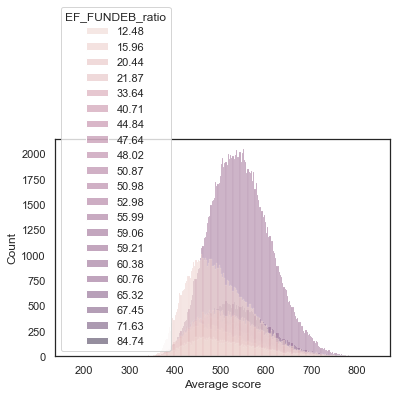

In [216]:
sns.histplot(data = siope_data_with_scores_df,
    x = 'Average score',
    hue = "EF_FUNDEB_ratio")

<ipython-input-220-bd7f086b3708>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.scatterplot(data = siope_data_with_scores_df.groupby(["UF"])["Average score", "EF_FUNDEB_ratio"].mean(),


<AxesSubplot: xlabel='EF_FUNDEB_ratio', ylabel='Average score'>

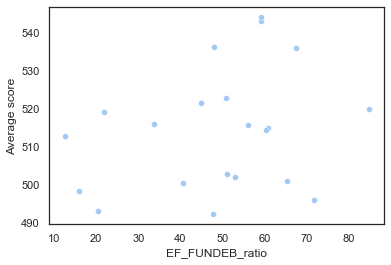

In [220]:
sns.scatterplot(data = siope_data_with_scores_df.groupby(["UF"])["Average score", "EF_FUNDEB_ratio"].mean(),
    x = 'EF_FUNDEB_ratio',
    y = 'Average score'
)

<AxesSubplot: xlabel='EF_FUNDEB_ratio', ylabel='Average score'>

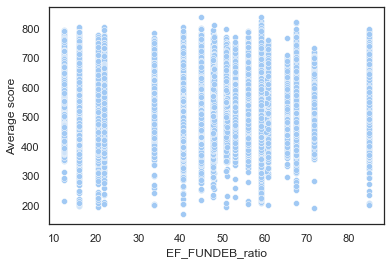

In [188]:
sns.scatterplot(data = siope_data_with_scores_df,
    x = 'EF_FUNDEB_ratio',
    y = 'Average score')

## 3. PCA

### 3.1. Joining ENEM and SIOPE data.

We chose to join ENEM's data with SIOPE indicators from the last 8 years.

In [8]:
year = 2022
window = 8
grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()


In [91]:
siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index

In [92]:
grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)

In [95]:
window = 8
for year in [2022]:
    R_external = pd.DataFrame()
    print(f"Running analysis for ENEM {year}")
    enem_df = joblib.load(f"ENEM_preprocessed_{year}_based_on_SG_UF_PROVA.pkl")
    enem_df.drop(columns = "UF", inplace = True)
    enem_df.rename(columns = {"SG_UF_PROVA": "UF"}, inplace = True)

    # get metrics average values over last 'window' years
    print(f"Processing SIOPE data")
    grouped_siope_df = siope_df[(siope_df['year'] >= year - window) & (siope_df["year"] <= year)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()
    siope_metrics_to_discard = (grouped_siope_df.isna().sum() > 0).where(lambda x: x == True).dropna().index
    grouped_siope_df.drop(columns = siope_metrics_to_discard, inplace = True)

    print(f"Merging ENEM and SIOPE data")
    enem_with_siope_df = enem_df.merge(grouped_siope_df, on = "UF", how = "left")
    siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
    
print("Done!")

Running analysis for ENEM 2022
Processing SIOPE data
Merging ENEM and SIOPE data


In [101]:
grouped_siope_df.shape

(24, 20)

In [102]:
enem_with_siope_df.dropna(inplace = True)

In [104]:
columns_to_scale = ["EB_expanses_teacher_per_student", "EB_investment_per_student", "EB_non_teaching_staff_per_student_expanses",
                    "EF_investment_per_student", "EI_investment_per_student", "EM_investment_per_student", "FUNDEB_balance",
                    "courseware_investment", "investment_per_student",
                    "superavit_or_deficit"]

df_to_scale = enem_with_siope_df[columns_to_scale]
enem_with_siope_df.drop(columns = columns_to_scale, inplace = True)

df_to_scale = (df_to_scale - df_to_scale.min())/(df_to_scale.max() - df_to_scale.min())
enem_with_siope_df = pd.concat([enem_with_siope_df, df_to_scale], axis = 1)

In [105]:
df = pd.get_dummies(enem_with_siope_df.drop(columns = ["TP_ESCOLA", "Natural Sciences score", "Humanities score", "Languages score",
                                                       "Average score", "ENEM_year", "UF", "Math score"]),
                    columns = ['Age group', 'Gender', 'Marital state', 'Ethinicity', 'Nacionality',
                                   'Q001', 'Q002', 'Q003', 'Q004',
                                   'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
                                   'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
                                   'Q023', 'Q024', 'Q025', 'School type'])

In [106]:
pca = PCA(n_components = 2)
pca.fit(df.dropna())

PCA(n_components=2)

In [38]:
pca.components_.shape

(2, 210)

In [107]:
pca.explained_variance_ratio_

array([0.83540288, 0.06384893])

In [108]:
df_pca = pca.transform(df.dropna())

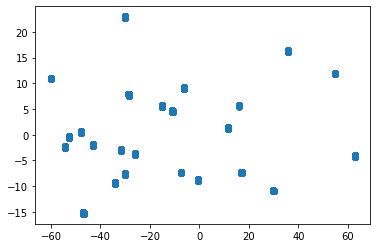

In [109]:
plt.scatter(x = df_pca[:,0], y = df_pca[:,1])

In [117]:
q1 = np.quantile(enem_with_siope_df["Average score"].dropna(),0.25)
q2 = np.quantile(enem_with_siope_df["Average score"].dropna(),0.50)
q3 = np.quantile(enem_with_siope_df["Average score"].dropna(),0.75)

In [120]:
enem_with_siope_df["Student_performance"] = enem_with_siope_df["Average score"].apply(lambda x: "Q3" if x > q3 
                                                                                      else "Q2" if x > q2
                                                                                      else "Q1")

In [121]:
enem_with_siope_df[["Average score", "Student_performance"]]

Average score Student_performance
0              507.800                  Q1
1              413.275                  Q1
2              407.625                  Q1
3              457.625                  Q1
4              485.875                  Q1
...                ...                 ...
2245643        503.775                  Q1
2245644        465.500                  Q1
2245645        587.400                  Q3
2245647        504.025                  Q1
2245648        593.825                  Q3

[1897637 rows x 2 columns]

In [123]:
enem_with_siope_df["Student_performance"].value_counts(normalize = True)

Q1    0.500081
Q3    0.249970
Q2    0.249949
Name: Student_performance, dtype: float64

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

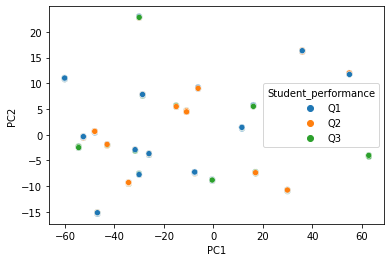

In [122]:
sns.scatterplot(data = pd.concat([pd.DataFrame(df_pca, columns = ["PC1", "PC2"]), enem_with_siope_df.dropna()["Student_performance"]],
                                 axis = 1),
                x = "PC1",
                y = "PC2",
                hue = "Student_performance")

In [77]:
grouped_siope_df.isna().sum()

metric_description
EB_expanses_teacher_per_student                   0
EB_investment_per_student                         0
EB_non_teaching_staff_per_student_expanses        0
EF_FUNDEB_ratio                                   0
EF_investment_per_student                         0
EF_to_total_education_expanses                    0
EI_FUNDEB_ratio                                   0
EI_investment_per_student                         0
EI_to_total_education_expanses                    0
EM_FUNDEB_ratio                                   0
EM_investment_per_student                         0
EM_to_total_education_expanses                    0
FUNDEB_balance                                    0
FUNDEB_not_used                                   3
FUNDEB_teacher_to_total_MDE                       0
average_teacher_expanses_EB                      16
courseware_investment                             0
education_to_overall_expanses                     0
education_to_total_MDE_investments           

In [75]:
enem_with_siope_df.head()

Age group Gender  Marital state  Ethinicity  Nacionality  \
0          5      F              1           2            1   
1          6      M              1           3            1   
2          6      F              1           2            1   
3          4      F              1           3            1   
4          2      F              1           1            1   

   High school conclusion year  TP_ESCOLA School type  UF  \
0                            2          1   No answer  BA   
1                            2          1   No answer  ES   
2                            0          1   No answer  RJ   
3                            1          1   No answer  PE   
4                            0          3     Private  SE   

   Natural Sciences score  ...  EB_non_teaching_staff_per_student_expanses  \
0                   421.1  ...                                    0.037556   
1                   490.7  ...                                    0.244621   
2                   398.1  ...                                    0.000000   
3                   467.5  ...                                    0.877172   
4                   458.7  ...                                    0.744752   

   EF_investment_per_student  EI_investment_per_student  \
0                   0.098694                   0.020477   
1                   0.194463                   0.000550   
2                   0.337511                   0.539259   
3                   0.306509                   0.029988   
4                   0.033576                   0.000740   

  EM_investment_per_student FUNDEB_balance FUNDEB_not_used  \
0                  0.225109       0.106679        0.630688   
1                  0.373627       0.035131        0.164852   
2                  0.288965       0.110213             NaN   
3                  0.290583       0.073300        1.000000   
4                  0.725414       0.000000        0.091473   

  average_teacher_expanses_EB  courseware_investment investment_per_student  \
0                         NaN               0.001130               0.343249   
1                    0.099757               0.000000               0.171743   
2                         NaN               0.000007               0.755430   
3                         NaN               0.043983               0.266016   
4                    0.048662               0.000000               0.247755   

  superavit_or_deficit  
0             0.356545  
1             0.307382  
2             0.000000  
3             0.190827  
4             0.226752  

[5 rows x 63 columns]

In [74]:
enem_with_siope_df.isna().sum().sort_values(ascending = False)[0:15]

average_teacher_expanses_EB                      1504381
FUNDEB_not_used                                   613654
investment_per_student_to_PIB_per_capita          391111
superavit_or_deficit                              348012
scholar_nutrition_to_total_education_expanses     348012
EF_FUNDEB_ratio                                   348012
EF_to_total_education_expanses                    348012
EI_FUNDEB_ratio                                   348012
EI_to_total_education_expanses                    348012
EM_FUNDEB_ratio                                   348012
EM_to_total_education_expanses                    348012
FUNDEB_teacher_to_total_MDE                       348012
education_to_overall_expanses                     348012
education_to_total_MDE_investments                348012
EB_expanses_teacher_per_student                   348012
dtype: int64

In [64]:
df.dropna().shape

(741268, 209)

In [124]:
dg = pd.DataFrame(pca.components_,columns=df.columns,index = ['PC-1','PC-2'])

In [65]:
dg.shape

(2, 209)

In [126]:
abs(dg.loc["PC-1", :]).sort_values(ascending = False)[0:15]

EM_FUNDEB_ratio                                  0.572088
EF_FUNDEB_ratio                                  0.561408
EM_to_total_education_expanses                   0.427275
EF_to_total_education_expanses                   0.411607
education_to_overall_expanses                    0.068909
EI_to_total_education_expanses                   0.017223
education_to_total_MDE_investments               0.015995
EI_FUNDEB_ratio                                  0.007279
FUNDEB_teacher_to_total_MDE                      0.006001
scholar_nutrition_to_total_education_expanses    0.003893
Q014_A                                           0.003835
Q014_B                                           0.003640
Q010_A                                           0.002982
Q016_A                                           0.002858
Q016_B                                           0.002763
Name: PC-1, dtype: float64

In [127]:
abs(dg.loc["PC-2", :]).sort_values(ascending = False)[0:15]

EM_to_total_education_expanses                0.774008
EF_to_total_education_expanses                0.408470
FUNDEB_teacher_to_total_MDE                   0.332835
EI_to_total_education_expanses                0.264869
EF_FUNDEB_ratio                               0.171515
EM_FUNDEB_ratio                               0.116762
education_to_total_MDE_investments            0.076968
EI_FUNDEB_ratio                               0.032875
investment_per_student                        0.023377
EB_investment_per_student                     0.022819
EB_non_teaching_staff_per_student_expanses    0.022429
FUNDEB_balance                                0.021094
EM_investment_per_student                     0.017075
High school conclusion year                   0.014154
education_to_overall_expanses                 0.013969
Name: PC-2, dtype: float64

In [63]:
pca.explained_variance_ratio_

array([0.64069824, 0.20520245])

## 4. Regressores

In [134]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [417]:
siope_data_with_scores_df.columns

Index(['UF', 'Average score', 'EI_FUNDEB_ratio', 'EF_FUNDEB_ratio',
       'EM_FUNDEB_ratio', 'EF_to_total_education_expanses',
       'EI_to_total_education_expanses', 'EM_to_total_education_expanses',
       'education_to_overall_expanses',
       'scholar_nutrition_to_total_education_expanses',
       'courseware_investment', 'education_to_total_MDE_investments',
       'average_teacher_expanses_EB', 'FUNDEB_teacher_to_total_MDE',
       'EI_investment_per_student', 'EF_investment_per_student',
       'EM_investment_per_student', 'EB_investment_per_student',
       'investment_per_student', 'EB_expanses_teacher_per_student',
       'EB_non_teaching_staff_per_student_expanses',
       'investment_per_student_to_PIB_per_capita', 'superavit_or_deficit',
       'FUNDEB_balance', 'FUNDEB_not_used'],
      dtype='object')

In [131]:
df_pca = pd.DataFrame(df_pca, columns = ["PC1", "PC2"])
df_pca.head()

PC1        PC2
0  29.905795 -10.752747
1 -10.888800   4.649784
2  17.009898  -7.265422
3 -15.049383   5.625712
4  16.133246   5.739628

In [133]:
df_pca["Average score"] = enem_with_siope_df.dropna()["Average score"]

In [141]:
groups = enem_with_siope_df.dropna()["UF"]
groups.shape

(1897637,)

In [143]:
data = df_pca.rename(columns = {'Average score': 'y'})
data.shape

(1897637, 3)

In [155]:
data["y"] = (data["y"] - data["y"].min())/(data["y"].max() - data["y"].min())

In [156]:
data.head()

PC1        PC2         y
0  29.905795 -10.752747  0.604668
1 -10.888800   4.649784  0.492111
2  17.009898  -7.265422  0.485383
3 -15.049383   5.625712  0.544921
4  16.133246   5.739628  0.578560

In [164]:
features_to_use = abs(dg.loc["PC-1", :]).sort_values(ascending = False)[0:15].index

In [166]:
data = df[features_to_use]

In [170]:
data["y"] = enem_with_siope_df.dropna()["Average score"]

<ipython-input-170-243a6f191069>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["y"] = enem_with_siope_df.dropna()["Average score"]


In [171]:
model = sm.MixedLM(endog = data["y"],
                   exog = data[features_to_use],
                   groups = groups).fit()

c:\Users\cstefano\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [172]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
==============================================================================================
Model:                        MixedLM            Dependent Variable:            y             
No. Observations:             1897637            Method:                        REML          
No. Groups:                   24                 Scale:                         4403.0472     
Min. group size:              4582               Log-Likelihood:                -10653372.8790
Max. group size:              363746             Converged:                     Yes           
Mean group size:              79068.2                                                         
----------------------------------------------------------------------------------------------
                                               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------------------
EM_FUNDEB_ratio                                  6.188    2.087    2.965 0.003   2.098  10.278
EF_FUNDEB_ratio                                  5.565    3.336    1.668 0.095  -0.974  12.103
EM_to_total_education_expanses                  -0.358    2.080   -0.172 0.863  -4.434   3.718
EF_to_total_education_expanses                   0.197    3.739    0.053 0.958  -7.132   7.525
education_to_overall_expanses                   -0.172    4.892   -0.035 0.972  -9.760   9.416
EI_to_total_education_expanses                  -0.394    5.691   -0.069 0.945 -11.547  10.759
education_to_total_MDE_investments              -0.426   11.313   -0.038 0.970 -22.600  21.747
EI_FUNDEB_ratio                                 14.013   15.352    0.913 0.361 -16.076  44.102
FUNDEB_teacher_to_total_MDE                     -0.547    2.406   -0.227 0.820  -5.262   4.168
scholar_nutrition_to_total_education_expanses   -5.653   39.391   -0.144 0.886 -82.857  71.551
Q014_A                                         -14.521    0.446  -32.540 0.000 -15.396 -13.647
Q014_B                                           2.275    0.431    5.282 0.000   1.431   3.119
Q010_A                                         -26.979    0.115 -235.336 0.000 -27.204 -26.755
Q016_A                                         -23.480    0.548  -42.870 0.000 -24.553 -22.406
Q016_B                                          -6.063    0.540  -11.228 0.000  -7.121  -5.004
Group Var                                     4403.047                                        
==============================================================================================

"""

In [173]:
y_pred = model.predict(data[features_to_use])

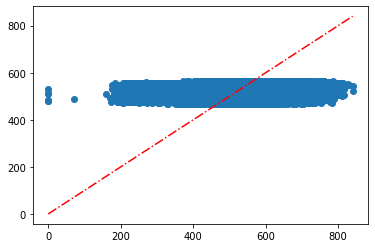

In [175]:
plt.scatter(data["y"], y_pred)

xx = np.linspace(data["y"].min(), data["y"].max())
yy = xx
plt.plot(xx, yy, 'r-.')

In [176]:
model.cov_re

Group Var
Group Var  4403.047226

In [183]:
print(model.__doc__)


    Class to contain results of fitting a linear mixed effects model.

    MixedLMResults inherits from statsmodels.LikelihoodModelResults

    Parameters
    ----------
    See statsmodels.LikelihoodModelResults

    Attributes
    ----------
    model : class instance
        Pointer to MixedLM model instance that called fit.
    normalized_cov_params : ndarray
        The sampling covariance matrix of the estimates
    params : ndarray
        A packed parameter vector for the profile parameterization.
        The first `k_fe` elements are the estimated fixed effects
        coefficients.  The remaining elements are the estimated
        variance parameters.  The variance parameters are all divided
        by `scale` and are not the variance parameters shown
        in the summary.
    fe_params : ndarray
        The fitted fixed-effects coefficients
    cov_re : ndarray
        The fitted random-effects covariance matrix
    bse_fe : ndarray
        The standard errors of the fitt

In [187]:
model.fittedvalues

0          485.961866
1          529.572857
2          543.283695
3          492.749030
4          488.678959
              ...    
2245643    515.683875
2245644    538.145068
2245645    497.188598
2245647    513.831678
2245648    550.800572
Length: 1897637, dtype: float64

In [200]:
model.fittedvalues.var()

751.9123910954969

In [191]:
np.diag(model.cov_params()).sum()

2012.01884168907

In [189]:
model.cov_params()

EM_FUNDEB_ratio  \
EM_FUNDEB_ratio                                       4.354626   
EF_FUNDEB_ratio                                      -1.749795   
EM_to_total_education_expanses                       -3.551413   
EF_to_total_education_expanses                        3.780209   
education_to_overall_expanses                        -0.472034   
EI_to_total_education_expanses                       -2.321372   
education_to_total_MDE_investments                    3.708536   
EI_FUNDEB_ratio                                       6.057841   
FUNDEB_teacher_to_total_MDE                          -2.884722   
scholar_nutrition_to_total_education_expanses       -21.862041   
Q014_A                                               -0.001453   
Q014_B                                               -0.001475   
Q010_A                                               -0.000014   
Q016_A                                               -0.002424   
Q016_B                                               -0.002485   
Group Var                                            -0.000002   

                                               EF_FUNDEB_ratio  \
EM_FUNDEB_ratio                                      -1.749795   
EF_FUNDEB_ratio                                      11.129673   
EM_to_total_education_expanses                        1.847939   
EF_to_total_education_expanses                      -10.921653   
education_to_overall_expanses                        -9.474085   
EI_to_total_education_expanses                       13.440502   
education_to_total_MDE_investments                  -24.360686   
EI_FUNDEB_ratio                                      -7.578714   
FUNDEB_teacher_to_total_MDE                           2.124606   
scholar_nutrition_to_total_education_expanses        55.002068   
Q014_A                                               -0.001288   
Q014_B                                               -0.001402   
Q010_A                                                0.000013   
Q016_A                                               -0.002314   
Q016_B                                               -0.002458   
Group Var                                             0.000003   

                                               EM_to_total_education_expanses  \
EM_FUNDEB_ratio                                                     -3.551413   
EF_FUNDEB_ratio                                                      1.847939   
EM_to_total_education_expanses                                       4.324885   
EF_to_total_education_expanses                                      -2.149423   
education_to_overall_expanses                                       -1.391911   
EI_to_total_education_expanses                                      -0.572094   
education_to_total_MDE_investments                                  -7.050182   
EI_FUNDEB_ratio                                                      4.578954   
FUNDEB_teacher_to_total_MDE                                          0.653688   
scholar_nutrition_to_total_education_expanses                       15.452790   
Q014_A                                                              -0.000076   
Q014_B                                                              -0.000014   
Q010_A                                                               0.000005   
Q016_A                                                              -0.000114   
Q016_B                                                              -0.000062   
Group Var                                                            0.000001   

                                               EF_to_total_education_expanses  \
EM_FUNDEB_ratio                                                      3.780209   
EF_FUNDEB_ratio                                                    -10.921653   
EM_to_total_education_expanses                                      -2.149423   
EF_to_total_education_expanses                                      13.980944   
education_to_overa

In [197]:
model.cov_re

Group Var
Group Var  4403.047226

In [148]:
model = smf.mixedlm(formula = "y ~ PC1 + PC2 + 1", 
    data = data,
    groups = groups,
    re_formula = "1").fit()

IndexError: index 1612678 is out of bounds for axis 0 with size 1612024

In [412]:
model.cov_re

Group
Group  313.514258

In [428]:
OLS_null = smf.ols(formula = "y ~ 1", data = siope_data_with_scores_df.rename(columns = {'Average score': 'y'})).fit()

In [431]:
OLS_null.llf

-3752392.8866953664

In [432]:
model.llf

-3729573.1750320885

In [433]:
(model.llf - OLS_null.llf)/model.llf

-0.006118585315887114

In [434]:
model.cov_re

Group
Group  331.925595

In [436]:
(model.cov_re + model.scale)/model.cov_re

Group
Group  15.461455

In [438]:
y_pred = model.predict(siope_data_with_scores_df[['EF_FUNDEB_ratio', 'EM_FUNDEB_ratio', 'EF_to_total_education_expanses', 'investment_per_student']])

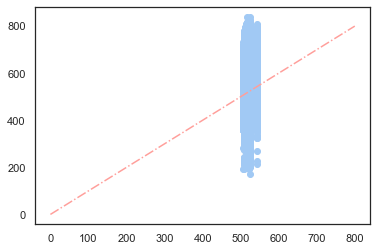

In [444]:
plt.scatter(y_pred, siope_data_with_scores_df["Average score"])
xx = np.linspace(0, 800)
yy = xx
plt.plot(xx,yy, '-.r')

In [451]:
from sklearn.metrics import r2_score
r2_score(siope_data_with_scores_df["Average score"], y_pred, force_finite = True)

-0.013944631678285191

In [437]:
model.normalized_cov_params

Intercept  EF_FUNDEB_ratio  \
Intercept                       6.419099e+00    -6.791473e-02   
EF_FUNDEB_ratio                -6.791473e-02     7.488751e-04   
EM_FUNDEB_ratio                -6.212126e-02     6.573440e-04   
EF_to_total_education_expanses  4.710293e-03    -8.156931e-05   
investment_per_student         -1.761614e-05     1.667240e-07   
Group Var                       2.140058e-07    -1.506948e-09   

                                EM_FUNDEB_ratio  \
Intercept                         -6.212126e-02   
EF_FUNDEB_ratio                    6.573440e-04   
EM_FUNDEB_ratio                    6.089317e-04   
EF_to_total_education_expanses    -4.320224e-05   
investment_per_student             1.147930e-07   
Group Var                         -1.447569e-09   

                                EF_to_total_education_expanses  \
Intercept                                         4.710293e-03   
EF_FUNDEB_ratio                                  -8.156931e-05   
EM_FUNDEB_ratio                                  -4.320224e-05   
EF_to_total_education_expanses                    4.237769e-05   
investment_per_student                           -3.686221e-08   
Group Var                                        -9.415777e-10   

                                investment_per_student     Group Var  
Intercept                                -1.761614e-05  2.140058e-07  
EF_FUNDEB_ratio                           1.667240e-07 -1.506948e-09  
EM_FUNDEB_ratio                           1.147930e-07 -1.447569e-09  
EF_to_total_education_expanses           -3.686221e-08 -9.415777e-10  
investment_per_student                    6.434971e-10 -4.850830e-12  
Group Var                                -4.850830e-12  1.067017e-07

In [425]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                  MixedLM       Dependent Variable:       y            
No. Observations:       659252        Method:                   REML         
No. Groups:             27            Scale:                    4800.1269    
Min. group size:        1293          Log-Likelihood:           -3729573.1750
Max. group size:        133816        Converged:                Yes          
Mean group size:        24416.7                                              
-----------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z|  [0.025  0.975] 
-----------------------------------------------------------------------------
Intercept                      702.755  175.535  4.004 0.000 358.713 1046.798
EF_FUNDEB_ratio                 -1.339    1.896 -0.706 0.480  -5.055    2.377
EM_FUNDEB_ratio                 -1.797    1.710 -1.051 0.293  -5.148    1.554
EF_to_total_education_expanses  -0.438    0.451 -0.971 0.331  -1.322    0.446
investment_per_student          -0.001    0.002 -0.673 0.501  -0.005    0.002
Group Var                      331.926    1.568                              
=============================================================================

"""

In [408]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: y            
No. Observations: 659252  Method:             REML         
No. Groups:       27      Scale:              4800.1408    
Min. group size:  1293    Log-Likelihood:     -3729570.4134
Max. group size:  133816  Converged:          Yes          
Mean group size:  24416.7                                  
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    519.222    3.368 154.162 0.000 512.621 525.824
Group Var    305.731    1.214                              
===========================================================

"""

In [ ]:
def run_longitudinal_correlation_analysis(years_to_analyze, time_window):
    R_external_all_years = {}
    for year in years_to_analyze:
        R_external = pd.DataFrame()
        print(f"Running analysis for ENEM {year}")
        for window in n:
            print(f"Running for the last {window} year(s)")
            # get metrics average values over last 'window' years
            grouped_siope_df = siope_df[(siope_df['year'] >= year - window)].groupby(["UF", "metric_description"])["metric_value"].mean().unstack()

            siope_data_with_scores_df = merge_siope_data_with_average_scores(SIOPE_METRICS_DICT, grouped_siope_df, enem_df, year)
            r = siope_data_with_scores_df.corr(method = 'spearman', numeric_only = True)
            r["window"] = window
            R_external = pd.concat([R_external, r[["Average score", "window"]]], axis = 0)

            del siope_data_with_scores_df
        joblib.dump(R_external, f"siope_correlations_ENEM_{year}.pkl")

        R_external_all_years[year] = R_external
        del R_external
    
    return R_external_all_years 
    